In [2]:
import pandas as pd
import networkx as nx
import numpy as np
import pickle as pk
import matplotlib.pyplot as plt 
from collections import Counter
from scipy import stats
import gseapy as gp
from community import community_louvain

In [2]:
#Let's import the final EEN
final_backbone_exp_graph_significant_combo_df = pd.read_csv("output/final_backbone_exp_graph_significant_combo_ji_df.tsv", sep="\t",index_col=0)
backbone_ss_exposure_network = nx.from_pandas_edgelist(final_backbone_exp_graph_significant_combo_df, 'Exp A', 'Exp B')


In [4]:
#We will check whether these networks have a hierarchical structure 

In [226]:
#inspired by https://github.com/benmaier/Degree-preserving-Randomization/blob/268b2f9cce8c99186ef053e66a457c10156414bb/ConstDegRand.py#L6


def degree_preserving_randomization(G):
    import random
    '''
    Randomizes a network provided by an edge list 
    producing neither self links nor duplicate links.
    The degree sequence will stay the same.
    INPUT:
    --- network
         
    OUTPUT:
    --- randomized network
    '''
    
    # make new set copy from edgelist
    edges = set( [tuple(e) for e in list(G.edges()) ]) 

    # get list of stubs
    stubs = [ ]
    [ stubs.extend(e) for e in edges ]

    # get a Counter object that counts the stubs for every node
    stub_counter = dict(Counter(stubs))

    # initialize the new edge list
    new_edges = set()

    # get available nodes (nodes that have nonzero stub count)
    nodes = np.array([ stub for stub,count in stub_counter.items() if count!=0 ])

    # loop till the number of available nodes is zero
    while len(nodes)>0:

        # initialize dummy values for new edge
        first,second = -1,-1

        # choose edges that are not self-links (only possible if len(nodes)>1)
        while first == second and len(nodes)>1:
            first,second = np.random.choice(nodes,size=(2,),replace=False)

        # if the chosen (source,target) is are not the same
        # and not yet connected 
        # and there is more than one node with available stubs
        if first!=second and \
           (first,second) not in new_edges and \
           (second,first) not in new_edges and \
           len(nodes)>1:
            new_edges.add((first,second))
            stub_counter[first] -= 1
            stub_counter[second] -= 1
        else:
            # if not, pop a random edge and put its nodes 
            # back in the stub pool
            edge = random.sample(new_edges,1)[0]
            new_edges.remove(edge)
            stub_counter[edge[0]] += 1
            stub_counter[edge[1]] += 1

        # get available nodes (nodes that have nonzero stub count)
        nodes = np.array([ stub for stub,count in stub_counter.items() if count!=0 ])
        
    new_G = nx.Graph()
    for edge in new_edges:
        new_G.add_edge(edge[0],edge[1])
        
    for node in G.nodes():
        if node not in nodes:
            new_G.add_node(node)
    return new_G

    

In [227]:
#To check whether the EEN has a hierarchical structure, we will compute the clusering coefficient for each node 
#and correlated with the degree in the EEN and comparing with a random rewiring network


random_rewired_EEN=degree_preserving_randomization(backbone_ss_exposure_network)
EEN_clustering_coefficient_node=[]
EEN_degree_node=[]
random_rewired_EEN_clustering_coefficient_node=[]
predicted_clustering_coefficient=[]

EEN_degree_dict=dict(nx.degree(backbone_ss_exposure_network))
EEN_degree_dict_sorted=dict(sorted(EEN_degree_dict.items(), key=lambda item: item[1]))

for node,degree in EEN_degree_dict_sorted.items():
    EEN_degree_node.append(degree)
    predicted_clustering_coefficient.append(1/degree)
    EEN_clustering_coefficient_node.append(nx.clustering(backbone_ss_exposure_network, node))
    random_rewired_EEN_clustering_coefficient_node.append(nx.clustering(random_rewired_EEN, node))
    

<ipython-input-226-b89fc54a3ab0>:69: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if node not in nodes:


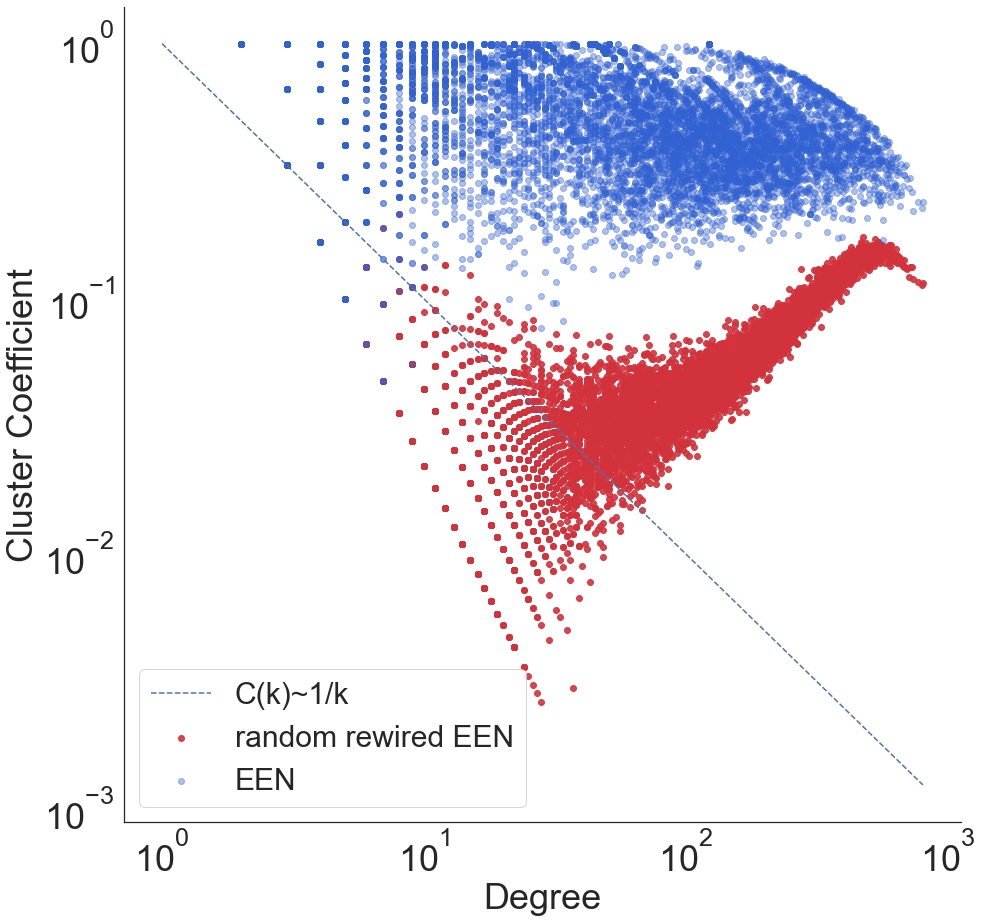

In [232]:
import matplotlib
fig, ax1 = plt.subplots(figsize=(15,15))


plt.scatter(EEN_degree_node, random_rewired_EEN_clustering_coefficient_node, c='#D2323C', alpha=0.9,label="random rewired EEN")
plt.scatter(EEN_degree_node, EEN_clustering_coefficient_node, c='#3262D2', alpha=0.4,label="EEN")
plt.plot(EEN_degree_node, predicted_clustering_coefficient, linestyle='dashed',label='C(k)~1/k')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree', fontsize=36)
plt.ylabel('Cluster Coefficient', fontsize=36)
#ax1.set_xticks([1,10, 100, 1000,20000])
#ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)

#plt.xlim(0,5000)
#plt.title('Exposures assocciated with genes')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
plt.legend(fontsize=30)
plt.xticks(fontsize=36) 
plt.yticks(fontsize=36) 
plt.savefig('output/Figures/AddFig_HierarchicalCom_1223.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()
plt.close()

In [233]:
#Let's try to group these results
#We will bin by degree size

#EEN
deg_cc_exp_dict={}
for i in range(len(EEN_degree_node)):
    deg_cc_exp_dict[EEN_clustering_coefficient_node[i]]=EEN_degree_node[i]
    
deg_cc_exp_dict_sort=dict(sorted(deg_cc_exp_dict.items(), key=lambda item: item[1]))


#Random rewiring
deg_cc_exp_rr_dict={}
for i in range(len(EEN_degree_node)):
    deg_cc_exp_rr_dict[random_rewired_EEN_clustering_coefficient_node[i]]=EEN_degree_node[i]
    
deg_cc_exp_rr_dict_sort=dict(sorted(deg_cc_exp_rr_dict.items(), key=lambda item: item[1]))
print(max(list(deg_cc_exp_dict_sort.values())))

801


In [234]:

tencile_degree=int(801/10)
cc_list_1=[]
cc_list_2=[]
cc_list_3=[]
cc_list_4=[]
cc_list_5=[]
cc_list_6=[]
cc_list_7=[]
cc_list_8=[]
cc_list_9=[]
cc_list_10=[]


for cc,deg in deg_cc_exp_dict_sort.items():
    if deg<tencile_degree:
        cc_list_1.append(cc)
    elif deg>tencile_degree and deg<2*tencile_degree:
        cc_list_2.append(cc)
    elif deg>2*tencile_degree and deg<3*tencile_degree:
        cc_list_3.append(cc)
    elif deg>3*tencile_degree and deg<4*tencile_degree:
        cc_list_4.append(cc)
    elif deg>4*tencile_degree and deg<5*tencile_degree:
        cc_list_5.append(cc)
    elif deg>5*tencile_degree and deg<6*tencile_degree:
        cc_list_6.append(cc)
    elif deg>6*tencile_degree and deg<7*tencile_degree:
        cc_list_7.append(cc)
    elif deg>7*tencile_degree and deg<8*tencile_degree:
        cc_list_8.append(cc)
    elif deg>8*tencile_degree and deg<9*tencile_degree:
        cc_list_9.append(cc)
    else:
        cc_list_10.append(cc)


In [235]:

cc_rr_list_1=[]
cc_rr_list_2=[]
cc_rr_list_3=[]
cc_rr_list_4=[]
cc_rr_list_5=[]
cc_rr_list_6=[]
cc_rr_list_7=[]
cc_rr_list_8=[]
cc_rr_list_9=[]
cc_rr_list_10=[]


for cc,deg in deg_cc_exp_rr_dict_sort.items():
    if deg<tencile_degree:
        cc_rr_list_1.append(cc)
    elif deg>tencile_degree and deg<2*tencile_degree:
        cc_rr_list_2.append(cc)
    elif deg>2*tencile_degree and deg<3*tencile_degree:
        cc_rr_list_3.append(cc)
    elif deg>3*tencile_degree and deg<4*tencile_degree:
        cc_rr_list_4.append(cc)
    elif deg>4*tencile_degree and deg<5*tencile_degree:
        cc_rr_list_5.append(cc)
    elif deg>5*tencile_degree and deg<6*tencile_degree:
        cc_rr_list_6.append(cc)
    elif deg>6*tencile_degree and deg<7*tencile_degree:
        cc_rr_list_7.append(cc)
    elif deg>7*tencile_degree and deg<8*tencile_degree:
        cc_rr_list_8.append(cc)
    elif deg>8*tencile_degree and deg<9*tencile_degree:
        cc_rr_list_9.append(cc)
    else:
        cc_rr_list_10.append(cc)


In [238]:

column_names = ["CC", "Group","Type"]

deg_cc_df = pd.DataFrame(columns = column_names)

for i in cc_list_1:
        new_row={"CC":i,"Group":"<80","Type":"EEN"}
        deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
for i in cc_list_2:
        new_row={"CC":i,"Group":"80-160","Type":"EEN"}
        deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
for i in cc_list_3:
        new_row={"CC":i,"Group":"160-240","Type":"EEN"}
        deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
for i in cc_list_4:
        new_row={"CC":i,"Group":"240-320","Type":"EEN"}
        deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
for i in cc_list_5:
        new_row={"CC":i,"Group":"320-400","Type":"EEN"}
        deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)

for i in cc_list_6:
        new_row={"CC":i,"Group":"400-480","Type":"EEN"}
        deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
for i in cc_list_7:
        new_row={"CC":i,"Group":"480-560","Type":"EEN"}
        deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
for i in cc_list_8:
        new_row={"CC":i,"Group":"560-640","Type":"EEN"}
        deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
for i in cc_list_9:
        new_row={"CC":i,"Group":"640-720","Type":"EEN"}
        deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
for i in cc_list_10:
        new_row={"CC":i,"Group":"720-801","Type":"EEN"}
        deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)


for i in cc_rr_list_1:
        new_row={"CC":i,"Group":"<80","Type":"Random Rewiring"}
        deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
for i in cc_rr_list_2:
        new_row={"CC":i,"Group":"80-160","Type":"Random Rewiring"}
        deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
for i in cc_rr_list_3:
        new_row={"CC":i,"Group":"160-240","Type":"Random Rewiring"}
        deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
for i in cc_rr_list_4:
        new_row={"CC":i,"Group":"240-320","Type":"Random Rewiring"}
        deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
for i in cc_rr_list_5:
        new_row={"CC":i,"Group":"320-400","Type":"Random Rewiring"}
        deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
for i in cc_rr_list_6:
        new_row={"CC":i,"Group":"400-480","Type":"Random Rewiring"}
        deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
for i in cc_rr_list_7:
        new_row={"CC":i,"Group":"480-560","Type":"Random Rewiring"}
        deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
for i in cc_rr_list_8:
        new_row={"CC":i,"Group":"560-640","Type":"Random Rewiring"}
        deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
for i in cc_rr_list_9:
        new_row={"CC":i,"Group":"640-720","Type":"Random Rewiring"}
        deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
for i in cc_rr_list_10:
        new_row={"CC":i,"Group":"720-801","Type":"Random Rewiring"}
        deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)

<ipython-input-238-3042cc902479>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:7: FutureWarning: The frame.append method is deprecated

<ipython-input-238-3042cc902479>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:7: FutureWarning: The frame.append method is deprecated

<ipython-input-238-3042cc902479>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:7: FutureWarning: The frame.append method is deprecated

<ipython-input-238-3042cc902479>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:7: FutureWarning: The frame.append method is deprecated

<ipython-input-238-3042cc902479>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:7: FutureWarning: The frame.append method is deprecated

<ipython-input-238-3042cc902479>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:7: FutureWarning: The frame.append method is deprecated

<ipython-input-238-3042cc902479>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:10: FutureWarning: The frame.append method is depre

<ipython-input-238-3042cc902479>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:10: FutureWarning: The frame.append method is depre

<ipython-input-238-3042cc902479>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:10: FutureWarning: The frame.append method is depre

<ipython-input-238-3042cc902479>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:10: FutureWarning: The frame.append method is depre

<ipython-input-238-3042cc902479>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:10: FutureWarning: The frame.append method is depre

<ipython-input-238-3042cc902479>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:13: FutureWarning: The frame.append method is depre

<ipython-input-238-3042cc902479>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:13: FutureWarning: The frame.append method is depre

<ipython-input-238-3042cc902479>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:16: FutureWarning: The frame.append method is depre

<ipython-input-238-3042cc902479>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:16: FutureWarning: The frame.append method is depre

<ipython-input-238-3042cc902479>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:19: FutureWarning: The frame.append method is depre

<ipython-input-238-3042cc902479>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:26: FutureWarning: The frame.append method is depre

<ipython-input-238-3042cc902479>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:40: FutureWarning: The frame.append method is depre

<ipython-input-238-3042cc902479>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:40: FutureWarning: The frame.append method is depre

<ipython-input-238-3042cc902479>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:40: FutureWarning: The frame.append method is depre

<ipython-input-238-3042cc902479>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:40: FutureWarning: The frame.append method is depre

<ipython-input-238-3042cc902479>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:43: FutureWarning: The frame.append method is depre

<ipython-input-238-3042cc902479>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:43: FutureWarning: The frame.append method is depre

<ipython-input-238-3042cc902479>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:43: FutureWarning: The frame.append method is depre

<ipython-input-238-3042cc902479>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:43: FutureWarning: The frame.append method is depre

<ipython-input-238-3042cc902479>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:43: FutureWarning: The frame.append method is depre

<ipython-input-238-3042cc902479>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:43: FutureWarning: The frame.append method is depre

<ipython-input-238-3042cc902479>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:46: FutureWarning: The frame.append method is depre

<ipython-input-238-3042cc902479>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:46: FutureWarning: The frame.append method is depre

<ipython-input-238-3042cc902479>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:46: FutureWarning: The frame.append method is depre

<ipython-input-238-3042cc902479>:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:49: FutureWarning: The frame.append method is depre

<ipython-input-238-3042cc902479>:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:52: FutureWarning: The frame.append method is depre

<ipython-input-238-3042cc902479>:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:55: FutureWarning: The frame.append method is depre

<ipython-input-238-3042cc902479>:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deg_cc_df = deg_cc_df.append(new_row, ignore_index=True)
<ipython-input-238-3042cc902479>:67: FutureWarning: The frame.append method is depre

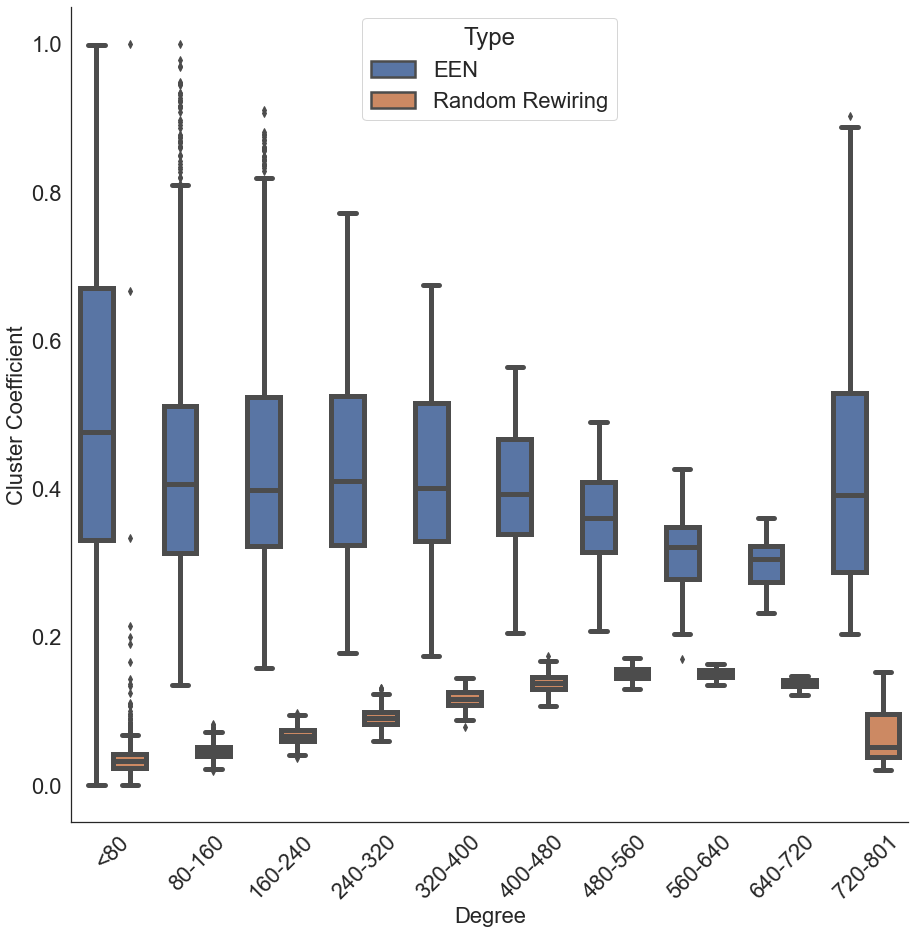

In [248]:
#Let's visualize as boxplot
import seaborn as sns
import matplotlib.pyplot as plt

# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
fig, ax = plt.subplots(figsize=(15, 15))

sns.set_style('white')
sns.set(style="white",font_scale = 2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
g=sns.boxplot(data=deg_cc_df,x="Group", y="CC",hue="Type",order=['<80','80-160','160-240',
                                                                 '240-320','320-400','400-480',
                                                                 '480-560','560-640','640-720','720-801'],linewidth=5)

plt.xlabel('Degree',fontsize=22)
plt.ylabel('Cluster Coefficient', fontsize=22)
plt.xticks(rotation=45, fontsize=22)
ax.grid(False)
#ax.set_yticklabels([int(i) for i in ax.get_yticks()], size = 36)
#ax.set_xticklabels(ax.get_xticks(), size = 36)
#g.set_yscale("log")
#g.set_xscale("log")
plt.savefig('output/Figures/AddFig_HierarchicalCom_binned_1223.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()


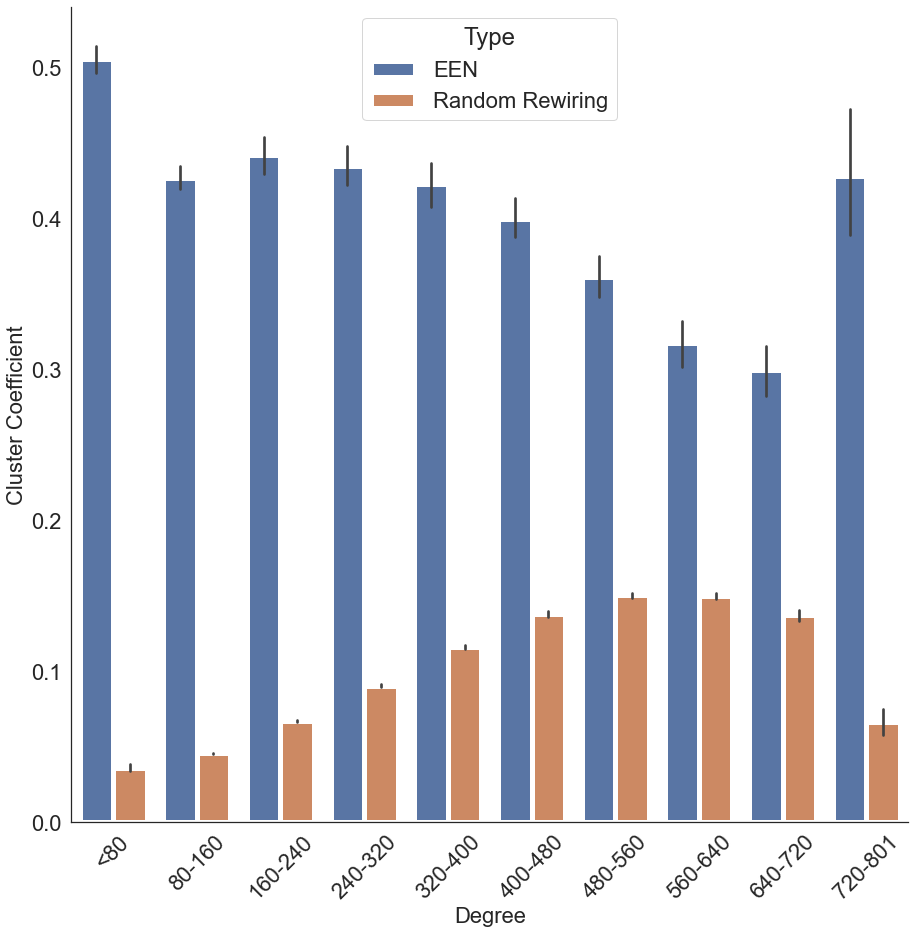

In [249]:
#Let's visualize as boxplot
import seaborn as sns
import matplotlib.pyplot as plt

# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
fig, ax = plt.subplots(figsize=(15, 15))

sns.set_style('white')
sns.set(style="white",font_scale = 2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
g=sns.barplot(data=deg_cc_df,x="Group", y="CC",hue="Type",order=['<80','80-160','160-240',
                                                                 '240-320','320-400','400-480',
                                                                 '480-560','560-640','640-720','720-801'],linewidth=5)


plt.xlabel('Degree',fontsize=22)
plt.ylabel('Cluster Coefficient', fontsize=22)
plt.xticks(rotation=45, fontsize=22)
ax.grid(False)
#ax.set_yticklabels([int(i) for i in ax.get_yticks()], size = 36)
#ax.set_xticklabels(ax.get_xticks(), size = 36)
#g.set_yscale("log")
#g.set_xscale("log")
plt.savefig('output/Figures/AddFig_HierarchicalCom_binned_bar1223.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()


In [3]:
#Here, we define a function that allows us to select the resolution parameter that corresponds to the 
#maximum value of modularity

from community import community_louvain

def optimal_resolution(G, resolution_list):
    """
    Param:
    G: A networkx graph
    resolution_list: List of resolution values to check
    """

    max_modularity = -1 # initialize maximum modularity as negative value
    for resolution in resolution_list:
        partition = community_louvain.best_partition(G, resolution=resolution)
        modularity = community_louvain.modularity(partition,G)

        if modularity > max_modularity:   # save the partition and resolution giving the maximum modularity
            max_modularity = modularity
            best_partition = partition
            best_resolution = resolution
            
    return best_partition, best_resolution, max_modularity

In [4]:
resolution_list = np.linspace(0.1, 2, 20)    # create list of resolution values to check
best_partition, best_resolution, max_modularity = optimal_resolution(backbone_ss_exposure_network, resolution_list)
print('Optimal resolution value: ', best_resolution)

Optimal resolution value:  0.7999999999999999


In [5]:
#Here, we calculate the communities in hierarchical fashion with Louvain
dendo = community_louvain.generate_dendrogram(backbone_ss_exposure_network,resolution=0.9, random_state=5495)

In [6]:
#There are three hierarchical levels
len(dendo)

3

In [7]:
#This is the number of nodes
len(dendo[0])

9302

In [8]:
#This is the finest grained communities
len(dendo[1])

526

In [9]:
len(dendo[2])

254

In [12]:
com_node_dict={}
backbone_louvain_bp=community_louvain.best_partition(backbone_ss_exposure_network,resolution=0.9)
for com in set(backbone_louvain_bp.values()):
    node_list=[]
    for node, comcom in backbone_louvain_bp.items():
        if com==comcom:
            node_list.append(node)
    com_node_dict[com]=node_list

In [13]:
#This is the broad level communities
len(com_node_dict)

230

In [54]:
#Let's define the three hierarchical communities as dictionaries
ee_first_louvain_iteration_exposures={}   

for com in set(list(dendo[0].values())):
    exp_list=[]
    for exp, comcom in dendo[0].items():
        if com==comcom:
            exp_list.append(exp)
    ee_first_louvain_iteration_exposures[com]=exp_list
    
ee_first_louvain_iteration={}  #this dictionary contains the middle-hierarchical level as keys and the respective (dividing)
                               #finest (first) hierarchical communities as values
for com in set(list(dendo[1].values())):
    exp_list=[]
    for exp, comcom in dendo[1].items():
        if com==comcom:
            exp_list.append(exp)
    ee_first_louvain_iteration[com]=exp_list
    
ee_second_louvain_iteration={} #this dictionary has the broad-hierarchical (third) level as keys and the respective (dividing)
                               #middle (second) hierarchical communities as values
for com in set(list(dendo[2].values())):
    exp_list=[]
    for exp, comcom in dendo[2].items():
        if com==comcom:
            exp_list.append(exp)
    ee_second_louvain_iteration[com]=exp_list


In [55]:
len(ee_first_louvain_iteration_exposures)

526

In [18]:
#Let's import the chemical-gene interactions from CTD (downloaded on 5th April 2021)
chem_gene_df = pd.read_csv("input/CTD/CTD_chem_gene_ixns.tsv",delimiter= '\t', skipinitialspace=True)
#Here, we filter for only the interactions that regards the H. Sapiens
chem_homo = chem_gene_df[(chem_gene_df['Organism'] == 'Homo sapiens')]


In [57]:
#This cells create a dictionary where each key is a chemical compound and the correspondent value is a genelist 
chem_gene = {}
for i,v in chem_homo.iterrows():
    try:
        chem_gene[v["ChemicalID"]] |= {v["GeneSymbol"]}
    except KeyError as e:
        chem_gene[v["ChemicalID"]] = set([v["GeneSymbol"]])

In [58]:
#Here, we keep only the exposures which perturb at least one gene
chem_gene_cleaned = {}
tot_gene_list=[]
for k,v in chem_gene.items():
    if len(v)>0:
        chem_gene_cleaned[k]=v
        for gene in v:
            tot_gene_list.append(gene)
    else:
        pass

In [59]:
#These communities are the middle and the broad level related to each community

ee_second_louvain_iteration_exposures={}  
for com, com_list in ee_first_louvain_iteration.items():
    exp_list=[]
    for comcom in com_list:
        exp_list.extend(ee_first_louvain_iteration_exposures[comcom])
    ee_second_louvain_iteration_exposures[com]=exp_list

ee_third_louvain_iteration_exposures={}
for com, com_list in ee_second_louvain_iteration.items():
    exp_list=[]
    for comcom in com_list:
        exp_list.extend(ee_second_louvain_iteration_exposures[comcom])
    ee_third_louvain_iteration_exposures[com]=exp_list

In [60]:
len(ee_first_louvain_iteration_exposures)

526

In [61]:
with open('output/Communities/Louvain/ee_ji_first_louvain_iteration_exposures.pickle', 'wb') as handle:
    pk.dump(ee_first_louvain_iteration_exposures, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/Louvain/ee_ji_second_louvain_iteration_exposures.pickle', 'wb') as handle:
    pk.dump(ee_second_louvain_iteration_exposures, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/Louvain/ee_ji_third_louvain_iteration_exposures.pickle', 'wb') as handle:
    pk.dump(ee_third_louvain_iteration_exposures, handle, protocol=pk.HIGHEST_PROTOCOL)

In [62]:
with open('output/Communities/Louvain/ee_ji_first_louvain_iteration.pickle', 'wb') as handle:
    pk.dump(ee_first_louvain_iteration, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/Louvain/ee_ji_second_louvain_iteration.pickle', 'wb') as handle:
    pk.dump(ee_second_louvain_iteration, handle, protocol=pk.HIGHEST_PROTOCOL)

In [5]:
with open('output/Communities/Louvain/ee_ji_first_louvain_iteration_exposures.pickle', 'rb') as handle:
    ee_first_louvain_iteration_exposures = pk.load(handle)   
with open('output/Communities/Louvain/ee_ji_second_louvain_iteration_exposures.pickle', 'rb') as handle:
    ee_second_louvain_iteration_exposures = pk.load(handle)       
with open('output/Communities/Louvain/ee_ji_third_louvain_iteration_exposures.pickle', 'rb') as handle:
    ee_third_louvain_iteration_exposures = pk.load(handle)       
with open('output/Communities/Louvain/ee_ji_first_louvain_iteration.pickle', 'rb') as handle:
    ee_first_louvain_iteration = pk.load(handle)   
with open('output/Communities/Louvain/ee_ji_second_louvain_iteration.pickle', 'rb') as handle:
    ee_second_louvain_iteration = pk.load(handle)       

    

In [6]:
#Let's change the nomenclature of these communities

#BROADEST==third
third_level_louvain_sort=dict(sorted(ee_third_louvain_iteration_exposures.items(), key=lambda item: len(item[1]), reverse = True))
third_renamed_third_conversion_dict={}
renamed_third_level_louvain_sort={}
c=1
for com,explist in third_level_louvain_sort.items():
    renamed_third_level_louvain_sort[str(c)]=explist
    third_renamed_third_conversion_dict[com]=str(c)
    c=c+1
    
#MIDDLE==second

second_renamed_second_conversion_dict={}
renamed_second_level_louvain_sort={}

for br_com,mid_com in ee_second_louvain_iteration.items():
    if len(mid_com)==1:
        newcom=third_renamed_third_conversion_dict[br_com]
        renamed_second_level_louvain_sort[newcom]=ee_second_louvain_iteration_exposures[mid_com[0]]
        second_renamed_second_conversion_dict[mid_com[0]]=newcom
    else:
        sorted_list=list(sorted(mid_com, key=lambda item: len(ee_second_louvain_iteration_exposures[item]), reverse = True))
        for i in range(len(sorted_list)):
            q=i+1
            newcom=third_renamed_third_conversion_dict[br_com]+"_"+str(q)
            renamed_second_level_louvain_sort[newcom]=ee_second_louvain_iteration_exposures[sorted_list[i]]
            second_renamed_second_conversion_dict[sorted_list[i]]=newcom
        
#FINEST==first  

first_renamed_first_conversion_dict={}
renamed_first_level_louvain_sort={}

for mid_com,fin_com in ee_first_louvain_iteration.items():
    if len(fin_com)==1:
        newcom=second_renamed_second_conversion_dict[mid_com]
        renamed_first_level_louvain_sort[newcom]=ee_first_louvain_iteration_exposures[fin_com[0]]
        first_renamed_first_conversion_dict[fin_com[0]]=newcom
    else:
        sorted_list=list(sorted(fin_com, key=lambda item: len(ee_first_louvain_iteration_exposures[item]), reverse = True))
        for i in range(len(sorted_list)):
            q=i+1
            newcom=second_renamed_second_conversion_dict[mid_com]+"_"+str(q)
            renamed_first_level_louvain_sort[newcom]=ee_first_louvain_iteration_exposures[sorted_list[i]]
            first_renamed_first_conversion_dict[sorted_list[i]]=newcom
        
third_renamed_third_conversion_dict_rev={}
for k,v in third_renamed_third_conversion_dict.items():
    third_renamed_third_conversion_dict_rev[v]=k

second_renamed_second_conversion_dict_rev={}
for k,v in second_renamed_second_conversion_dict.items():
    second_renamed_second_conversion_dict_rev[v]=k

first_renamed_first_conversion_dict_rev={}
for k,v in first_renamed_first_conversion_dict.items():
    first_renamed_first_conversion_dict_rev[v]=k
    

In [7]:
#We are using the new nomenclature
fine_grained_communities_list=[]
middle_communities_list=[]
broad_communities_list=[]

for com,explist in renamed_first_level_louvain_sort.items():
    comlist=com.split("_")
    if len(comlist)==1:
        fine_grained_communities_list.append(com)
    elif len(comlist)==2:
        fine_grained_communities_list.append(com)
        middle_communities_list.append(comlist[0])
    else:
        fine_grained_communities_list.append(com)
        middle_communities_list.append(comlist[0]+"_"+comlist[1])
        broad_communities_list.append(comlist[0])

fine_grained_communities_set=set(fine_grained_communities_list)
middle_communities_set=set(middle_communities_list)
broad_communities_set=set(broad_communities_list)
print(len(broad_communities_set))  
print(len(middle_communities_set))  
print(len(fine_grained_communities_set))  

11
50
526


In [8]:
len([x for x in fine_grained_communities_set if len(x.split("_"))>2])

245

In [11]:
len([x for x in middle_communities_set if len(x.split("_"))>1])

33

In [65]:
fine_grained_communities_community_size=[]
middle_communities_community_size=[]
broad_communities_community_size=[]

for com in fine_grained_communities_set:
    fine_grained_communities_community_size.append(len(renamed_first_level_louvain_sort[com]))
    
for com in middle_communities_set:
    middle_communities_community_size.append(len(renamed_second_level_louvain_sort[com]))

for com in broad_communities_set:
    broad_communities_community_size.append(len(renamed_third_level_louvain_sort[com]))

In [66]:
fine_grained_communities_dict={}
middle_communities_dict={}
broad_communities_dict={}

for com in fine_grained_communities_set:
    fine_grained_communities_dict[com]=renamed_first_level_louvain_sort[com]
    
for com in middle_communities_set:
    middle_communities_dict[com]=renamed_second_level_louvain_sort[com]

for com in broad_communities_set:
    broad_communities_dict[com]=renamed_third_level_louvain_sort[com]
    
with open('output/Communities/Louvain/ji_fine_grained_communities_dict.pickle', 'wb') as handle:
    pk.dump(fine_grained_communities_dict, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/Louvain/ji_middle_communities_dict.pickle', 'wb') as handle:
    pk.dump(middle_communities_dict, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/Louvain/ji_broad_communities_dict.pickle', 'wb') as handle:
    pk.dump(broad_communities_dict, handle, protocol=pk.HIGHEST_PROTOCOL)

In [3]:
with open('output/Communities/Louvain/ji_fine_grained_communities_dict.pickle', 'rb') as handle:
    fine_grained_communities_dict = pk.load(handle)   
with open('output/Communities/Louvain/ji_middle_communities_dict.pickle', 'rb') as handle:
    middle_communities_dict = pk.load(handle)       
with open('output/Communities/Louvain/ji_broad_communities_dict.pickle', 'rb') as handle:
    broad_communities_dict = pk.load(handle)       
    

In [4]:
len(middle_communities_dict)

50

In [19]:
#Let's define a dictionary that will convert the chemical name in chemical ID
chem_name_id_conversion = {}
for i,v in chem_gene_df.iterrows():
        chem_name_id_conversion[v["ChemicalID"]] = v["# ChemicalName"]

/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_14548/800863006.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Louvain Iteration", y="Exposure size", data=EEN_louvain_com_df, estimator=np.mean,
/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_14548/800863006.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), size = 36)
/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_14548/800863006.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, size = 36)


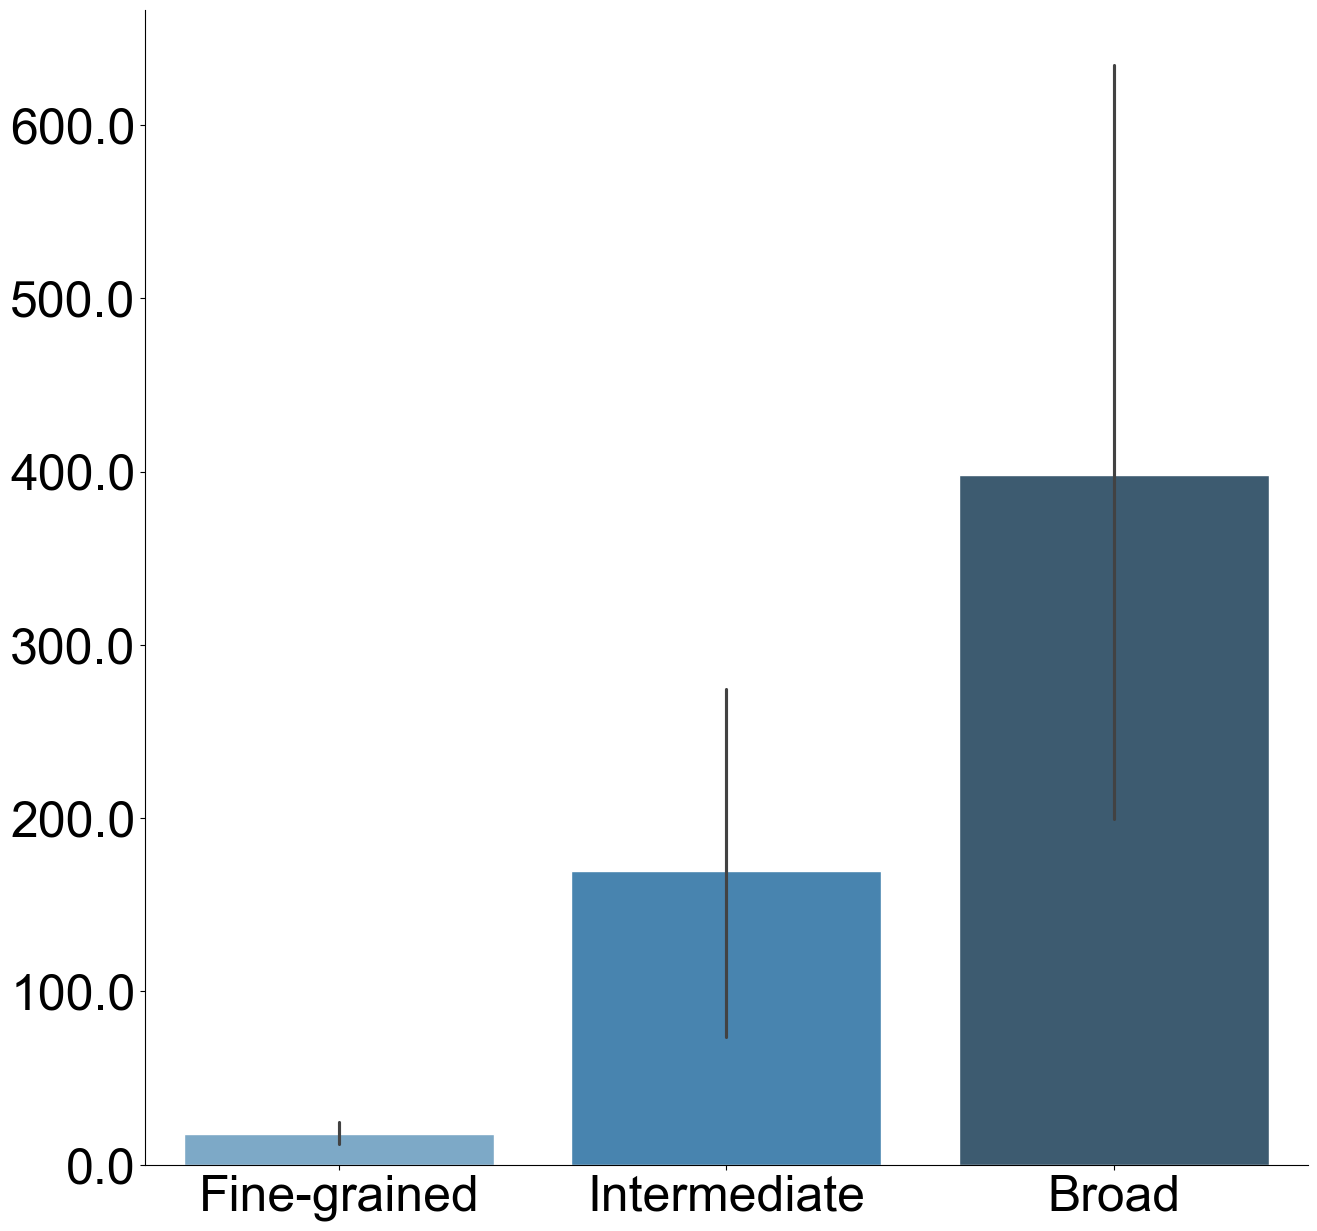

In [69]:
column_names = ["Exposure size", "louvain Iteration"]
labels=['Fine-grained','Intermediate','Broad']
exposuresize_list_tot=[]
group_list=[]
for i in fine_grained_communities_community_size:
    exposuresize_list_tot.append(i)
    group_list.append("Fine-grained")
    
for i in middle_communities_community_size:
    exposuresize_list_tot.append(i)
    group_list.append("Intermediate")

for i in broad_communities_community_size:
    exposuresize_list_tot.append(i)
    group_list.append("Broad")
    
EEN_louvain_com_df = pd.DataFrame(columns = column_names)
EEN_louvain_com_df["Exposure size"]=exposuresize_list_tot
EEN_louvain_com_df["Louvain Iteration"]=group_list

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 15))
sns.set(style="white")


ax = sns.barplot(x="Louvain Iteration", y="Exposure size", data=EEN_louvain_com_df, estimator=np.mean,
                 palette="Blues_d")

ax.set_xlabel("",fontsize=32)
ax.set_ylabel("",fontsize=32)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_yticklabels(ax.get_yticks(), size = 36)
ax.set_xticklabels(labels, size = 36)
plt.savefig('output/Figures/SF5A_v02.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()

In [25]:
#Now, we will provide a biological characterization via enrichment analysis

#These analyses are performed in the cluster and described in the file CTD_Louvain_partial_rankedgsea.py

#I will describe the key steps also here

In [44]:
with open('output/Communities/Louvain/ji_fine_grained_communities_dict.pickle', 'rb') as handle:
    ee_first_louvain_iteration_exposures = pk.load(handle)

with open('output/Communities/Louvain/ji_middle_communities_dict.pickle', 'rb') as handle:
    ee_second_louvain_iteration_exposures = pk.load(handle)

with open('output/Communities/Louvain/ji_broad_communities_dict.pickle', 'rb') as handle:
    ee_third_louvain_iteration_exposures = pk.load(handle)


def enr_df_dict(gene_list):   #This function returns the enrichment df for GOBP,GOCC,GOMF,KeGG
    libraries=['GO_Biological_Process_2023']
    c = 0
    while c<10:
        try:
            geneset_to_enrich_GOBP_df = gp.enrichr(gene_list=gene_list,
                                 gene_sets=libraries,
                                 organism='human',
                                 outdir=None,
                                )
            break
        except (NameError, AttributeError):
            c += 1
    libraries=['GO_Molecular_Function_2023']
    c = 0
    while c<10:
        try:
            geneset_to_enrich_GOMF_df = gp.enrichr(gene_list=gene_list,
                                 gene_sets=libraries,
                                 organism='human',
                                 outdir=None,
                                )
            break
        except (NameError, AttributeError):
            c += 1
    libraries=['GO_Cellular_Component_2023']
    c = 0
    while c<10:
        try:
            geneset_to_enrich_GOCC_df = gp.enrichr(gene_list=gene_list,
                                 gene_sets=libraries,
                                 organism='human',
                                 outdir=None,
                                )
            break
        except (NameError, AttributeError):
            c += 1
    libraries=['KEGG_2021_Human']
    c = 0
    while c<10:
        try:
            geneset_to_enrich_KEGG_df = gp.enrichr(gene_list=gene_list,
                                 gene_sets=libraries,
                                 organism='human',
                                 outdir=None,
                                )
            break
        except (NameError, AttributeError):
            c += 1
    enrdf_dict={}
    enrdf_dict['KEGG']=geneset_to_enrich_KEGG_df
    enrdf_dict['GOBP']=geneset_to_enrich_GOBP_df
    enrdf_dict['GOMF']=geneset_to_enrich_GOMF_df
    enrdf_dict['GOCC']=geneset_to_enrich_GOCC_df
    return enrdf_dict

def enr_fdr_list(enrdf_dict):
    sig_dict={}
    for lib, enr_df in enrdf_dict.items():
        lib_significant_terms=[]
        for i,v in enr_df.res2d.iterrows():
            if v['Adjusted P-value']<0.05:
                lib_significant_terms.append(v['Term'])
        sig_dict[lib]=lib_significant_terms
    return sig_dict


def enr_ranking_leading_genes(pre_rank_df,library_list):   #This function returns the leading genes
    leading_genes_tot=[]
    for lib in library_list:
        c=0
        while c<10:
            try:
                lib_pre_res = gp.prerank(rnk=pre_rank_df, gene_sets=lib,
                                 processes=4,min_size=3,max_size=5000,outdir=None,   #we impose at least 5 enriched common genes
                                 permutation_num=500) # reduce number to speed up testing
                leading_gene_lib_list=[]
                for gene_str in lib_pre_res.res2d['Lead_genes'].tolist():    #lib_pre_res.res2d['Lead_genes'] if in the cluster
                    leading_gene_lib_list.extend(gene_str.split(";"))
                leading_genes_tot.extend(leading_gene_lib_list)
                if 'Lead_genes' in lib_pre_res.res2d:
                    break
            except (NameError, AttributeError):
                c += 1
    return set(leading_genes_tot)

#Here, we define the list of gene libraries for which we perform the biological enrichment
lib_list=['GO_Biological_Process_2023','GO_Molecular_Function_2023','GO_Cellular_Component_2023','KEGG_2021_Human']

#I consider a pre-rank for making a choice on the gene cutoff
#defining for each comunity a set of genes that is well-representative of each cluster
from collections import Counter
pre_rank_first_louvain_cluster_genelist={}
for com,explist in ee_first_louvain_iteration_exposures.items():
    gene_list=[]
    rank_genelist=[]
    if len(explist)>1:
        G_sub = nx.subgraph(backbone_ss_exposure_network,explist)   #let's create the subgraph corresponding to the cluster
        for edge in G_sub.edges():
            overlap_geneset=chem_gene_cleaned[edge[0]] & chem_gene_cleaned[edge[1]]
            for gene in overlap_geneset:
                gene_list.append(gene)
        count_dict=Counter(gene_list)
        for gene in set(gene_list):
            rank_genelist.append([gene,count_dict[gene]])
    else:
        for gene in chem_gene_cleaned[explist[0]]:
            rank_genelist.append([gene,1])
    pre_rank_first_louvain_cluster_genelist[com]=rank_genelist

pre_rank_first_louvain_cluster_genelist_df={}
for com,genelist in pre_rank_first_louvain_cluster_genelist.items():
    rank_df=pd.DataFrame(columns=('gene', 'rank'))
    for n in range(len(genelist)):
        rank_df.loc[n] = [genelist[n][0], float(genelist[n][1])]
    rank_df=rank_df.sort_values(by=['rank'],ascending=False)
    pre_rank_first_louvain_cluster_genelist_df[com]=rank_df

pre_rank_second_louvain_cluster_genelist={}
for com,explist in ee_second_louvain_iteration_exposures.items():
    gene_list=[]
    rank_genelist=[]
    if len(explist)>1:
        G_sub = nx.subgraph(backbone_ss_exposure_network,explist)   #let's create the subgraph corresponding to the cluster
        for edge in G_sub.edges():
            overlap_geneset=chem_gene_cleaned[edge[0]] & chem_gene_cleaned[edge[1]]
            for gene in overlap_geneset:
                gene_list.append(gene)
        count_dict=Counter(gene_list)
        for gene in set(gene_list):
            rank_genelist.append([gene,count_dict[gene]])
    else:
        for gene in chem_gene_cleaned[explist[0]]:
            rank_genelist.append([gene,1])
    pre_rank_second_louvain_cluster_genelist[com]=rank_genelist

pre_rank_second_louvain_cluster_genelist_df={}
for com,genelist in pre_rank_second_louvain_cluster_genelist.items():
    rank_df=pd.DataFrame(columns=('gene', 'rank'))
    for n in range(len(genelist)):
        rank_df.loc[n] = [genelist[n][0], float(genelist[n][1])]
    rank_df=rank_df.sort_values(by=['rank'],ascending=False)
    pre_rank_second_louvain_cluster_genelist_df[com]=rank_df

pre_rank_third_louvain_cluster_genelist={}
for com,explist in ee_third_louvain_iteration_exposures.items():
    gene_list=[]
    rank_genelist=[]
    if len(explist)>1:
        G_sub = nx.subgraph(backbone_ss_exposure_network,explist)   #let's create the subgraph corresponding to the cluster
        for edge in G_sub.edges():
            overlap_geneset=chem_gene_cleaned[edge[0]] & chem_gene_cleaned[edge[1]]
            for gene in overlap_geneset:
                gene_list.append(gene)
        count_dict=Counter(gene_list)
        for gene in set(gene_list):
            rank_genelist.append([gene,count_dict[gene]])
    else:
        for gene in chem_gene_cleaned[explist[0]]:
            rank_genelist.append([gene,1])
    pre_rank_third_louvain_cluster_genelist[com]=rank_genelist

pre_rank_third_louvain_cluster_genelist_df={}
for com,genelist in pre_rank_third_louvain_cluster_genelist.items():
    rank_df=pd.DataFrame(columns=('gene', 'rank'))
    for n in range(len(genelist)):
        rank_df.loc[n] = [genelist[n][0], float(genelist[n][1])]
    rank_df=rank_df.sort_values(by=['rank'],ascending=False)
    pre_rank_third_louvain_cluster_genelist_df[com]=rank_df


#First louvain interation
#Now we will run the traditional enrichment analysis for (Fisher's exact test + BH correction for those communties
#that perturb less than 20 genes, otherwise we will collect the leading genes from the GSEA with ranking
#and then performing again a traditional enrichment analysis

lead_genes_kegg_first_louvain_cluster_significant_fdr={}
lead_genes_gobp_first_louvain_cluster_significant_fdr={}
lead_genes_gocc_first_louvain_cluster_significant_fdr={}
lead_genes_gomf_first_louvain_cluster_significant_fdr={}
for com in list(pre_rank_first_louvain_cluster_genelist_df.keys()):
    num_of_genes=len(pre_rank_first_louvain_cluster_genelist_df[com])
    if num_of_genes>20:
        try:
            lead_genelist =list(enr_ranking_leading_genes(pre_rank_first_louvain_cluster_genelist_df[com],lib_list))
            come_enr_df_dict=enr_df_dict(lead_genelist)
            come_enr_fdr_df_dict=enr_fdr_list(come_enr_df_dict)
            lead_genes_kegg_first_louvain_cluster_significant_fdr[com]=[len(lead_genelist),come_enr_fdr_df_dict['KEGG']]
            lead_genes_gobp_first_louvain_cluster_significant_fdr[com]=[len(lead_genelist),come_enr_fdr_df_dict['GOBP']]
            lead_genes_gomf_first_louvain_cluster_significant_fdr[com]=[len(lead_genelist),come_enr_fdr_df_dict['GOMF']]
            lead_genes_gocc_first_louvain_cluster_significant_fdr[com]=[len(lead_genelist),come_enr_fdr_df_dict['GOCC']]

        except:
            lead_genes_kegg_first_louvain_cluster_significant_fdr[com]=[len(lead_genelist),'no enrichment with leading genes']
            lead_genes_gobp_first_louvain_cluster_significant_fdr[com]=[len(lead_genelist),'no enrichment with leading genes']
            lead_genes_gomf_first_louvain_cluster_significant_fdr[com]=[len(lead_genelist),'no enrichment with leading genes']
            lead_genes_gocc_first_louvain_cluster_significant_fdr[com]=[len(lead_genelist),'no enrichment with leading genes']

    else:
        com_genelist=pre_rank_first_louvain_cluster_genelist_df[com]['gene'].tolist()
        try:
            come_enr_df_dict=enr_df_dict(com_genelist)
            come_enr_fdr_df_dict=enr_fdr_list(come_enr_df_dict)
            lead_genes_kegg_first_louvain_cluster_significant_fdr[com]=[num_of_genes,come_enr_fdr_df_dict['KEGG']]
            lead_genes_gobp_first_louvain_cluster_significant_fdr[com]=[num_of_genes,come_enr_fdr_df_dict['GOBP']]
            lead_genes_gomf_first_louvain_cluster_significant_fdr[com]=[num_of_genes,come_enr_fdr_df_dict['GOMF']]
            lead_genes_gocc_first_louvain_cluster_significant_fdr[com]=[num_of_genes,come_enr_fdr_df_dict['GOCC']]
        except:
            lead_genes_kegg_first_louvain_cluster_significant_fdr[com]=[num_of_genes,'not found']
            lead_genes_gobp_first_louvain_cluster_significant_fdr[com]=[num_of_genes,'not found']
            lead_genes_gomf_first_louvain_cluster_significant_fdr[com]=[num_of_genes,'not found']
            lead_genes_gocc_first_louvain_cluster_significant_fdr[com]=[num_of_genes,'not found']
        print(com,len(pre_rank_first_louvain_cluster_genelist_df[com]),'not ranked')


#second louvain interation
#Now we will run the traditional enrichment analysis for (Fisher's exact test + BH correction for those communties
#that perturb less than 20 genes, otherwise we will collect the leading genes from the GSEA with ranking
#and then performing again a traditional enrichment analysis

lead_genes_kegg_second_louvain_cluster_significant_fdr={}
lead_genes_gobp_second_louvain_cluster_significant_fdr={}
lead_genes_gocc_second_louvain_cluster_significant_fdr={}
lead_genes_gomf_second_louvain_cluster_significant_fdr={}
for com in list(pre_rank_second_louvain_cluster_genelist_df.keys()):
    num_of_genes=len(pre_rank_second_louvain_cluster_genelist_df[com])
    if num_of_genes>20:
        try:
            lead_genelist =list(enr_ranking_leading_genes(pre_rank_second_louvain_cluster_genelist_df[com],lib_list))
            come_enr_df_dict=enr_df_dict(lead_genelist)
            come_enr_fdr_df_dict=enr_fdr_list(come_enr_df_dict)
            lead_genes_kegg_second_louvain_cluster_significant_fdr[com]=[len(lead_genelist),come_enr_fdr_df_dict['KEGG']]
            lead_genes_gobp_second_louvain_cluster_significant_fdr[com]=[len(lead_genelist),come_enr_fdr_df_dict['GOBP']]
            lead_genes_gomf_second_louvain_cluster_significant_fdr[com]=[len(lead_genelist),come_enr_fdr_df_dict['GOMF']]
            lead_genes_gocc_second_louvain_cluster_significant_fdr[com]=[len(lead_genelist),come_enr_fdr_df_dict['GOCC']]

        except:
            lead_genes_kegg_second_louvain_cluster_significant_fdr[com]=[len(lead_genelist),'no enrichment with leading genes']
            lead_genes_gobp_second_louvain_cluster_significant_fdr[com]=[len(lead_genelist),'no enrichment with leading genes']
            lead_genes_gomf_second_louvain_cluster_significant_fdr[com]=[len(lead_genelist),'no enrichment with leading genes']
            lead_genes_gocc_second_louvain_cluster_significant_fdr[com]=[len(lead_genelist),'no enrichment with leading genes']

    else:
        com_genelist=pre_rank_second_louvain_cluster_genelist_df[com]['gene'].tolist()
        try:
            come_enr_df_dict=enr_df_dict(com_genelist)
            come_enr_fdr_df_dict=enr_fdr_list(come_enr_df_dict)
            lead_genes_kegg_second_louvain_cluster_significant_fdr[com]=[num_of_genes,come_enr_fdr_df_dict['KEGG']]
            lead_genes_gobp_second_louvain_cluster_significant_fdr[com]=[num_of_genes,come_enr_fdr_df_dict['GOBP']]
            lead_genes_gomf_second_louvain_cluster_significant_fdr[com]=[num_of_genes,come_enr_fdr_df_dict['GOMF']]
            lead_genes_gocc_second_louvain_cluster_significant_fdr[com]=[num_of_genes,come_enr_fdr_df_dict['GOCC']]
        except:
            lead_genes_kegg_second_louvain_cluster_significant_fdr[com]=[num_of_genes,'not found']
            lead_genes_gobp_second_louvain_cluster_significant_fdr[com]=[num_of_genes,'not found']
            lead_genes_gomf_second_louvain_cluster_significant_fdr[com]=[num_of_genes,'not found']
            lead_genes_gocc_second_louvain_cluster_significant_fdr[com]=[num_of_genes,'not found']
        print(com,len(pre_rank_second_louvain_cluster_genelist_df[com]),'not ranked')


#third louvain interation
#Now we will run the traditional enrichment analysis for (Fisher's exact test + BH correction for those communties
#that perturb less than 20 genes, otherwise we will collect the leading genes from the GSEA with ranking
#and then performing again a traditional enrichment analysis

lead_genes_kegg_third_louvain_cluster_significant_fdr={}
lead_genes_gobp_third_louvain_cluster_significant_fdr={}
lead_genes_gocc_third_louvain_cluster_significant_fdr={}
lead_genes_gomf_third_louvain_cluster_significant_fdr={}
for com in list(pre_rank_third_louvain_cluster_genelist_df.keys()):
    num_of_genes=len(pre_rank_third_louvain_cluster_genelist_df[com])
    if num_of_genes>20:
        try:
            lead_genelist =list(enr_ranking_leading_genes(pre_rank_third_louvain_cluster_genelist_df[com],lib_list))
            come_enr_df_dict=enr_df_dict(lead_genelist)
            come_enr_fdr_df_dict=enr_fdr_list(come_enr_df_dict)
            lead_genes_kegg_third_louvain_cluster_significant_fdr[com]=[len(lead_genelist),come_enr_fdr_df_dict['KEGG']]
            lead_genes_gobp_third_louvain_cluster_significant_fdr[com]=[len(lead_genelist),come_enr_fdr_df_dict['GOBP']]
            lead_genes_gomf_third_louvain_cluster_significant_fdr[com]=[len(lead_genelist),come_enr_fdr_df_dict['GOMF']]
            lead_genes_gocc_third_louvain_cluster_significant_fdr[com]=[len(lead_genelist),come_enr_fdr_df_dict['GOCC']]

        except:
            lead_genes_kegg_third_louvain_cluster_significant_fdr[com]=[len(lead_genelist),'no enrichment with leading genes']
            lead_genes_gobp_third_louvain_cluster_significant_fdr[com]=[len(lead_genelist),'no enrichment with leading genes']
            lead_genes_gomf_third_louvain_cluster_significant_fdr[com]=[len(lead_genelist),'no enrichment with leading genes']
            lead_genes_gocc_third_louvain_cluster_significant_fdr[com]=[len(lead_genelist),'no enrichment with leading genes']

    else:
        com_genelist=pre_rank_third_louvain_cluster_genelist_df[com]['gene'].tolist()
        try:
            come_enr_df_dict=enr_df_dict(com_genelist)
            come_enr_fdr_df_dict=enr_fdr_list(come_enr_df_dict)
            lead_genes_kegg_third_louvain_cluster_significant_fdr[com]=[num_of_genes,come_enr_fdr_df_dict['KEGG']]
            lead_genes_gobp_third_louvain_cluster_significant_fdr[com]=[num_of_genes,come_enr_fdr_df_dict['GOBP']]
            lead_genes_gomf_third_louvain_cluster_significant_fdr[com]=[num_of_genes,come_enr_fdr_df_dict['GOMF']]
            lead_genes_gocc_third_louvain_cluster_significant_fdr[com]=[num_of_genes,come_enr_fdr_df_dict['GOCC']]
        except:
            lead_genes_kegg_third_louvain_cluster_significant_fdr[com]=[num_of_genes,'not found']
            lead_genes_gobp_third_louvain_cluster_significant_fdr[com]=[num_of_genes,'not found']
            lead_genes_gomf_third_louvain_cluster_significant_fdr[com]=[num_of_genes,'not found']
            lead_genes_gocc_third_louvain_cluster_significant_fdr[com]=[num_of_genes,'not found']
        print(com,len(pre_rank_third_louvain_cluster_genelist_df[com]),'not ranked')


with open('output/Communities/Louvain/ji_lead_genes_kegg_broad_louvain_cluster_significant_fdr.pickle', 'wb') as handle:
    pk.dump(lead_genes_kegg_third_louvain_cluster_significant_fdr, handle, protocol=pk.HIGHEST_PROTOCOL)
with open('output/Communities/Louvain/ji_lead_genes_gobp_broad_louvain_cluster_significant_fdr.pickle', 'wb') as handle:
    pk.dump(lead_genes_gobp_third_louvain_cluster_significant_fdr, handle, protocol=pk.HIGHEST_PROTOCOL)
with open('output/Communities/Louvain/ji_lead_genes_gomf_broad_louvain_cluster_significant_fdr.pickle', 'wb') as handle:
    pk.dump(lead_genes_gomf_third_louvain_cluster_significant_fdr, handle, protocol=pk.HIGHEST_PROTOCOL)
with open('output/Communities/Louvain/ji_lead_genes_gocc_broad_louvain_cluster_significant_fdr.pickle', 'wb') as handle:
    pk.dump(lead_genes_gocc_third_louvain_cluster_significant_fdr, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/Louvain/ji_lead_genes_kegg_middle_louvain_cluster_significant_fdr.pickle', 'wb') as handle:
    pk.dump(lead_genes_kegg_second_louvain_cluster_significant_fdr, handle, protocol=pk.HIGHEST_PROTOCOL)
with open('output/Communities/Louvain/ji_lead_genes_gobp_middle_louvain_cluster_significant_fdr.pickle', 'wb') as handle:
    pk.dump(lead_genes_gobp_second_louvain_cluster_significant_fdr, handle, protocol=pk.HIGHEST_PROTOCOL)
with open('output/Communities/Louvain/ji_lead_genes_gomf_middle_louvain_cluster_significant_fdr.pickle', 'wb') as handle:
    pk.dump(lead_genes_gomf_second_louvain_cluster_significant_fdr, handle, protocol=pk.HIGHEST_PROTOCOL)
with open('output/Communities/Louvain/ji_lead_genes_gocc_middle_louvain_cluster_significant_fdr.pickle', 'wb') as handle:
    pk.dump(lead_genes_gocc_second_louvain_cluster_significant_fdr, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/Louvain/ji_lead_genes_kegg_fine_grained_louvain_cluster_significant_fdr.pickle', 'wb') as handle:
    pk.dump(lead_genes_kegg_first_louvain_cluster_significant_fdr, handle, protocol=pk.HIGHEST_PROTOCOL)
with open('output/Communities/Louvain/ji_lead_genes_gobp_fine_grained_louvain_cluster_significant_fdr.pickle', 'wb') as handle:
    pk.dump(lead_genes_gobp_first_louvain_cluster_significant_fdr, handle, protocol=pk.HIGHEST_PROTOCOL)
with open('output/Communities/Louvain/ji_lead_genes_gomf_fine_grained_louvain_cluster_significant_fdr.pickle', 'wb') as handle:
    pk.dump(lead_genes_gomf_first_louvain_cluster_significant_fdr, handle, protocol=pk.HIGHEST_PROTOCOL)
with open('output/Communities/Louvain/ji_lead_genes_gocc_fine_grained_louvain_cluster_significant_fdr.pickle', 'wb') as handle:
    pk.dump(lead_genes_gocc_first_louvain_cluster_significant_fdr, handle, protocol=pk.HIGHEST_PROTOCOL)


In [48]:
#Here, we import the results that have been calculated in the cluster
    
with open('output/Communities/Louvain/ji_lead_genes_kegg_fine_grained_louvain_cluster_significant_fdr.pickle', 'rb') as handle:
    fine_grained_communities_kegg = pk.load(handle)   
with open('output/Communities/Louvain/ji_lead_genes_kegg_middle_louvain_cluster_significant_fdr.pickle', 'rb') as handle:
    middle_communities_kegg = pk.load(handle)       
with open('output/Communities/Louvain/ji_lead_genes_kegg_broad_louvain_cluster_significant_fdr.pickle', 'rb') as handle:
    broad_communities_kegg = pk.load(handle)       
    
with open('output/Communities/Louvain/ji_lead_genes_gobp_fine_grained_louvain_cluster_significant_fdr.pickle', 'rb') as handle:
    fine_grained_communities_gobp = pk.load(handle)   
with open('output/Communities/Louvain/ji_lead_genes_gobp_middle_louvain_cluster_significant_fdr.pickle', 'rb') as handle:
    middle_communities_gobp = pk.load(handle)       
with open('output/Communities/Louvain/ji_lead_genes_gobp_broad_louvain_cluster_significant_fdr.pickle', 'rb') as handle:
    broad_communities_gobp = pk.load(handle)  
    
with open('output/Communities/Louvain/ji_lead_genes_gomf_fine_grained_louvain_cluster_significant_fdr.pickle', 'rb') as handle:
    fine_grained_communities_gomf = pk.load(handle)   
with open('output/Communities/Louvain/ji_lead_genes_gomf_middle_louvain_cluster_significant_fdr.pickle', 'rb') as handle:
    middle_communities_gomf = pk.load(handle)       
with open('output/Communities/Louvain/ji_lead_genes_gomf_broad_louvain_cluster_significant_fdr.pickle', 'rb') as handle:
    broad_communities_gomf = pk.load(handle)  
    
with open('output/Communities/Louvain/ji_lead_genes_gocc_fine_grained_louvain_cluster_significant_fdr.pickle', 'rb') as handle:
    fine_grained_communities_gocc = pk.load(handle)   
with open('output/Communities/Louvain/ji_lead_genes_gocc_middle_louvain_cluster_significant_fdr.pickle', 'rb') as handle:
    middle_communities_gocc = pk.load(handle)       
with open('output/Communities/Louvain/ji_lead_genes_gocc_broad_louvain_cluster_significant_fdr.pickle', 'rb') as handle:
    broad_communities_gocc = pk.load(handle)  
    
    
    

In [49]:
#Let's collect the number of associated enriched terms

fine_grained_communities_gobp_len=[]
for com,term_list in fine_grained_communities_gobp.items():
    if type(term_list[1])!=str:
        fine_grained_communities_gobp_len.append(len(term_list[1]))

fine_grained_communities_gomf_len=[]
for com,term_list in fine_grained_communities_gomf.items():
    if type(term_list[1])!=str:
        fine_grained_communities_gomf_len.append(len(term_list[1]))
    
fine_grained_communities_gocc_len=[]
for com,term_list in fine_grained_communities_gocc.items():
    if type(term_list[1])!=str:
        fine_grained_communities_gocc_len.append(len(term_list[1]))
    
fine_grained_communities_kegg_len=[]
for com,term_list in fine_grained_communities_kegg.items():
    if type(term_list[1])!=str:
        fine_grained_communities_kegg_len.append(len(term_list[1]))

middle_communities_gobp_len=[]
for com,term_list in middle_communities_gobp.items():
    if type(term_list[1])!=str:
        middle_communities_gobp_len.append(len(term_list[1]))

middle_communities_gomf_len=[]
for com,term_list in middle_communities_gomf.items():
    if type(term_list[1])!=str:
        middle_communities_gomf_len.append(len(term_list[1]))
    
middle_communities_gocc_len=[]
for com,term_list in middle_communities_gocc.items():
    if type(term_list[1])!=str:
        middle_communities_gocc_len.append(len(term_list[1]))
    
middle_communities_kegg_len=[]
for com,term_list in middle_communities_kegg.items():
    if type(term_list[1])!=str:
        middle_communities_kegg_len.append(len(term_list[1]))
    
broad_communities_gobp_len=[]
for com,term_list in broad_communities_gobp.items():
    if type(term_list[1])!=str:
        broad_communities_gobp_len.append(len(term_list[1]))

broad_communities_gomf_len=[]
for com,term_list in broad_communities_gomf.items():
    if type(term_list[1])!=str:
        broad_communities_gomf_len.append(len(term_list[1]))
    
broad_communities_gocc_len=[]
for com,term_list in broad_communities_gocc.items():
    if type(term_list[1])!=str:
        broad_communities_gocc_len.append(len(term_list[1]))

broad_communities_kegg_len=[]
for com,term_list in broad_communities_kegg.items():
    if type(term_list[1])!=str:
        broad_communities_kegg_len.append(len(term_list[1]))
        

/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_31137/2937995385.py:85: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size=36)


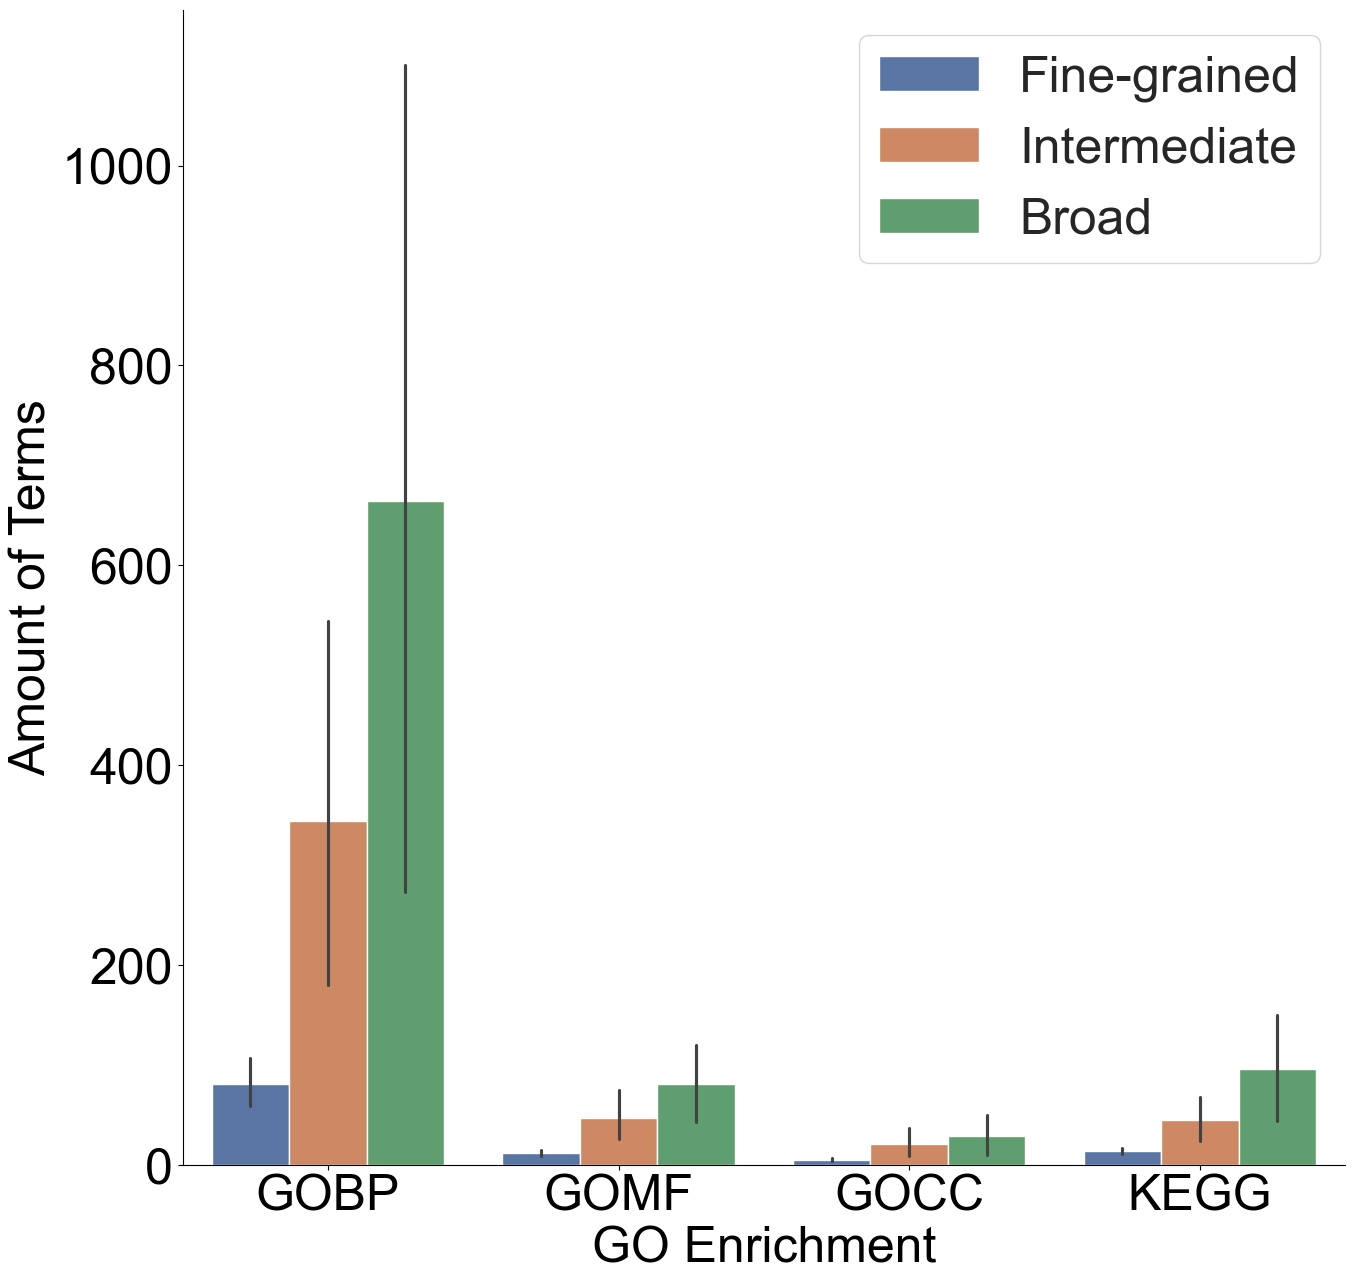

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

go_com_df=pd.DataFrame()

status_list=[]
num_terms_list=[]
level_list=[]

for i in fine_grained_communities_gobp_len:
    status_list.append("GOBP")
    num_terms_list.append(i)
    level_list.append("Fine-grained")
    
for i in fine_grained_communities_gomf_len:
    status_list.append("GOMF")
    num_terms_list.append(i)
    level_list.append("Fine-grained")
    
for i in fine_grained_communities_gocc_len:
    status_list.append("GOCC")
    num_terms_list.append(i)
    level_list.append("Fine-grained")   
    
for i in fine_grained_communities_kegg_len:
    status_list.append("KEGG")
    num_terms_list.append(i)
    level_list.append("Fine-grained")   
    
for i in middle_communities_gobp_len:
    status_list.append("GOBP")
    num_terms_list.append(i)
    level_list.append("Intermediate")
    
for i in middle_communities_gomf_len:
    status_list.append("GOMF")
    num_terms_list.append(i)
    level_list.append("Intermediate")
    
for i in middle_communities_gocc_len:
    status_list.append("GOCC")
    num_terms_list.append(i)
    level_list.append("Intermediate")   
    
for i in middle_communities_kegg_len:
    status_list.append("KEGG")
    num_terms_list.append(i)
    level_list.append("Intermediate")   
    
for i in broad_communities_gobp_len:
    status_list.append("GOBP")
    num_terms_list.append(i)
    level_list.append("Broad")
    
for i in broad_communities_gomf_len:
    status_list.append("GOMF")
    num_terms_list.append(i)
    level_list.append("Broad")
    
for i in broad_communities_gocc_len:
    status_list.append("GOCC")
    num_terms_list.append(i)
    level_list.append("Broad")  
    
for i in broad_communities_kegg_len:
    status_list.append("KEGG")
    num_terms_list.append(i)
    level_list.append("Broad")  
    
go_com_df['Status']=status_list
go_com_df['Enriched Terms']=num_terms_list
go_com_df['Hierarchy']=level_list


# Create a boxplot using seaborn
fig, ax = plt.subplots(figsize=(15, 15))
sns.set(style="white")

g=sns.barplot(x='Status', y='Enriched Terms', hue='Hierarchy', data=go_com_df)
#g.set_yscale("log")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size=36)
plt.xticks(fontsize=36)

plt.xlabel('GO Enrichment', fontsize=36)
plt.ylabel('Amount of Terms', fontsize=36)
plt.legend(fontsize=36)
#plt.savefig('output/Figures/Fig2D.pdf', format='pdf', dpi=300, bbox_inches="tight")
plt.show()



In [107]:
#Here, we will define a funnction that calculates the lcc for each set of terms in the GO tree to check for the 
#cohesiveness of the enrichment terms in each community
def lcc_significance(term_list,network):
    import random as rd
    import numpy as np
    z='nan'
    if len(set(term_list))>1:
        try:
            G_sub = nx.subgraph(network,term_list)
            G_sub_lcc = G_sub.subgraph(max(nx.connected_components(G_sub), key=len))  # extract lcc graph
            f_lcc_size = G_sub_lcc.number_of_nodes()
        except:
            f_lcc_size = 1
            
        l_random_lccs = []

        S = 1000
        for s in range(S):
            term_sample = rd.sample(network.nodes(),len(set(term_list)))
            G_sub_rnd = nx.subgraph(network,term_sample)
            G_sub_rnd_lcc = G_sub_rnd.subgraph(max(nx.connected_components(G_sub_rnd), key=len))  # extract lcc graph
            lcc_size = G_sub_rnd_lcc.number_of_nodes()
            l_random_lccs.append(lcc_size)
        mu = np.mean(l_random_lccs)
        std = np.std(l_random_lccs)

        z = (f_lcc_size-mu)/std
    
    return z


#Here, we define a function that allows us to identify enrichment terms in the GO tree
def find_enclosed(s): 
    import re
    # find all matches
    matches = re.findall(r"\((.*?)\)", s) 
    matches = [x for x in matches if str(x).startswith("GO:")]
    # if there are no matches return None
    if len(matches) == 0:
        return None
    # if it is a valid number change its type to a number
    for i in range(len(matches)):
        try:
            matches[i] = int(matches[i])
        except:
            pass
    # if there is only one match return it without a list
    if len(matches) ==  1:
        return matches[0]
    return matches


def terms_extraction(enriched_terms):
    id_list1=[]
    for el in enriched_terms:
        id_list1.append(find_enclosed(el))
    return id_list1


In [110]:
#Let's import the latest release of the GO ontology
import obonet

url = 'http://purl.obolibrary.org/obo/go.obo'
graph = obonet.read_obo(url)
graph_up = nx.DiGraph.reverse(graph)

In [113]:
#Let's divide in the three branches
#BP
GOBP = graph_up.subgraph(list(nx.descendants(graph_up,'GO:0008150')))
GOBP_undirected=GOBP.to_undirected()
#MF
GOMF = graph_up.subgraph(list(nx.descendants(graph_up,'GO:0003674')))
GOMF_undirected=GOMF.to_undirected()
#CC
GOCC = graph_up.subgraph(list(nx.descendants(graph_up,'GO:0005575')))
GOCC_undirected=GOCC.to_undirected()



fine_grained_communities_gobp_lcc_zscore={}
for com,term_list in fine_grained_communities_gobp.items():
    enriched_terms_id=terms_extraction(term_list[1])
    fine_grained_communities_gobp_lcc_zscore[com]=lcc_significance(enriched_terms_id,GOBP_undirected)

fine_grained_communities_gomf_lcc_zscore={}
for com,term_list in fine_grained_communities_gomf.items():
    enriched_terms_id=terms_extraction(term_list[1])
    fine_grained_communities_gomf_lcc_zscore[com]=lcc_significance(enriched_terms_id,GOMF_undirected)

fine_grained_communities_gocc_lcc_zscore={}
for com,term_list in fine_grained_communities_gocc.items():
    enriched_terms_id=terms_extraction(term_list[1])
    fine_grained_communities_gocc_lcc_zscore[com]=lcc_significance(enriched_terms_id,GOCC_undirected)


middle_communities_gobp_lcc_zscore={}
for com,term_list in middle_communities_gobp.items():
    enriched_terms_id=terms_extraction(term_list[1])
    middle_communities_gobp_lcc_zscore[com]=lcc_significance(enriched_terms_id,GOBP_undirected)

middle_communities_gomf_lcc_zscore={}
for com,term_list in middle_communities_gomf.items():
    enriched_terms_id=terms_extraction(term_list[1])
    middle_communities_gomf_lcc_zscore[com]=lcc_significance(enriched_terms_id,GOMF_undirected)

middle_communities_gocc_lcc_zscore={}
for com,term_list in middle_communities_gocc.items():
    enriched_terms_id=terms_extraction(term_list[1])
    middle_communities_gocc_lcc_zscore[com]=lcc_significance(enriched_terms_id,GOCC_undirected)

    
broad_communities_gobp_lcc_zscore={}
for com,term_list in broad_communities_gobp.items():
    enriched_terms_id=terms_extraction(term_list[1])
    broad_communities_gobp_lcc_zscore[com]=lcc_significance(enriched_terms_id,GOBP_undirected)

broad_communities_gomf_lcc_zscore={}
for com,term_list in broad_communities_gomf.items():
    enriched_terms_id=terms_extraction(term_list[1])
    broad_communities_gomf_lcc_zscore[com]=lcc_significance(enriched_terms_id,GOMF_undirected)

broad_communities_gocc_lcc_zscore={}
for com,term_list in broad_communities_gocc.items():
    enriched_terms_id=terms_extraction(term_list[1])
    broad_communities_gocc_lcc_zscore[com]=lcc_significance(enriched_terms_id,GOCC_undirected)


/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_14548/2487402823.py:19: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  term_sample = rd.sample(network.nodes(),len(set(term_list)))
/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_14548/2487402823.py:27: RuntimeWarning: divide by zero encountered in scalar divide
  z = (f_lcc_size-mu)/std
/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_14548/2487402823.py:27: RuntimeWarning: invalid value encountered in scalar divide
  z = (f_lcc_size-mu)/std


In [114]:
with open('output/Communities/Louvain/fine_grained_communities_gobp_lcc_zscore.pickle', 'wb') as handle:
    pk.dump(fine_grained_communities_gobp_lcc_zscore, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/Louvain/fine_grained_communities_gomf_lcc_zscore.pickle', 'wb') as handle:
    pk.dump(fine_grained_communities_gomf_lcc_zscore, handle, protocol=pk.HIGHEST_PROTOCOL)
    
with open('output/Communities/Louvain/fine_grained_communities_gocc_lcc_zscore.pickle', 'wb') as handle:
    pk.dump(fine_grained_communities_gocc_lcc_zscore, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/Louvain/middle_communities_gobp_lcc_zscore.pickle', 'wb') as handle:
    pk.dump(middle_communities_gobp_lcc_zscore, handle, protocol=pk.HIGHEST_PROTOCOL)
    
with open('output/Communities/Louvain/middle_communities_gomf_lcc_zscore.pickle', 'wb') as handle:
    pk.dump(middle_communities_gomf_lcc_zscore, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/Louvain/middle_communities_gocc_lcc_zscore.pickle', 'wb') as handle:
    pk.dump(middle_communities_gocc_lcc_zscore, handle, protocol=pk.HIGHEST_PROTOCOL)
    
with open('output/Communities/Louvain/broad_communities_gobp_lcc_zscore.pickle', 'wb') as handle:
    pk.dump(broad_communities_gobp_lcc_zscore, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/Louvain/broad_communities_gomf_lcc_zscore.pickle', 'wb') as handle:
    pk.dump(broad_communities_gomf_lcc_zscore, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/Louvain/broad_communities_gocc_lcc_zscore.pickle', 'wb') as handle:
    pk.dump(broad_communities_gocc_lcc_zscore, handle, protocol=pk.HIGHEST_PROTOCOL)
    


In [115]:
with open('output/Communities/Louvain/fine_grained_communities_gobp_lcc_zscore.pickle', 'rb') as handle:
    fine_grained_communities_gobp_lcc_zscore = pk.load(handle)    
with open('output/Communities/Louvain/fine_grained_communities_gomf_lcc_zscore.pickle', 'rb') as handle:
    fine_grained_communities_gomf_lcc_zscore = pk.load(handle)    
with open('output/Communities/Louvain/fine_grained_communities_gocc_lcc_zscore.pickle', 'rb') as handle:
    fine_grained_communities_gocc_lcc_zscore = pk.load(handle)
with open('output/Communities/Louvain/middle_communities_gobp_lcc_zscore.pickle', 'rb') as handle:
    middle_communities_gobp_lcc_zscore = pk.load(handle)    
with open('output/Communities/Louvain/middle_communities_gomf_lcc_zscore.pickle', 'rb') as handle:
    middle_communities_gomf_lcc_zscore = pk.load(handle)    
with open('output/Communities/Louvain/middle_communities_gocc_lcc_zscore.pickle', 'rb') as handle:
    middle_communities_gocc_lcc_zscore = pk.load(handle)
with open('output/Communities/Louvain/broad_communities_gobp_lcc_zscore.pickle', 'rb') as handle:
    broad_communities_gobp_lcc_zscore = pk.load(handle)    
with open('output/Communities/Louvain/broad_communities_gomf_lcc_zscore.pickle', 'rb') as handle:
    broad_communities_gomf_lcc_zscore = pk.load(handle)    
with open('output/Communities/Louvain/broad_communities_gocc_lcc_zscore.pickle', 'rb') as handle:
    broad_communities_gocc_lcc_zscore = pk.load(handle)
    

/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_14548/4216662255.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_14548/4216662255.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)


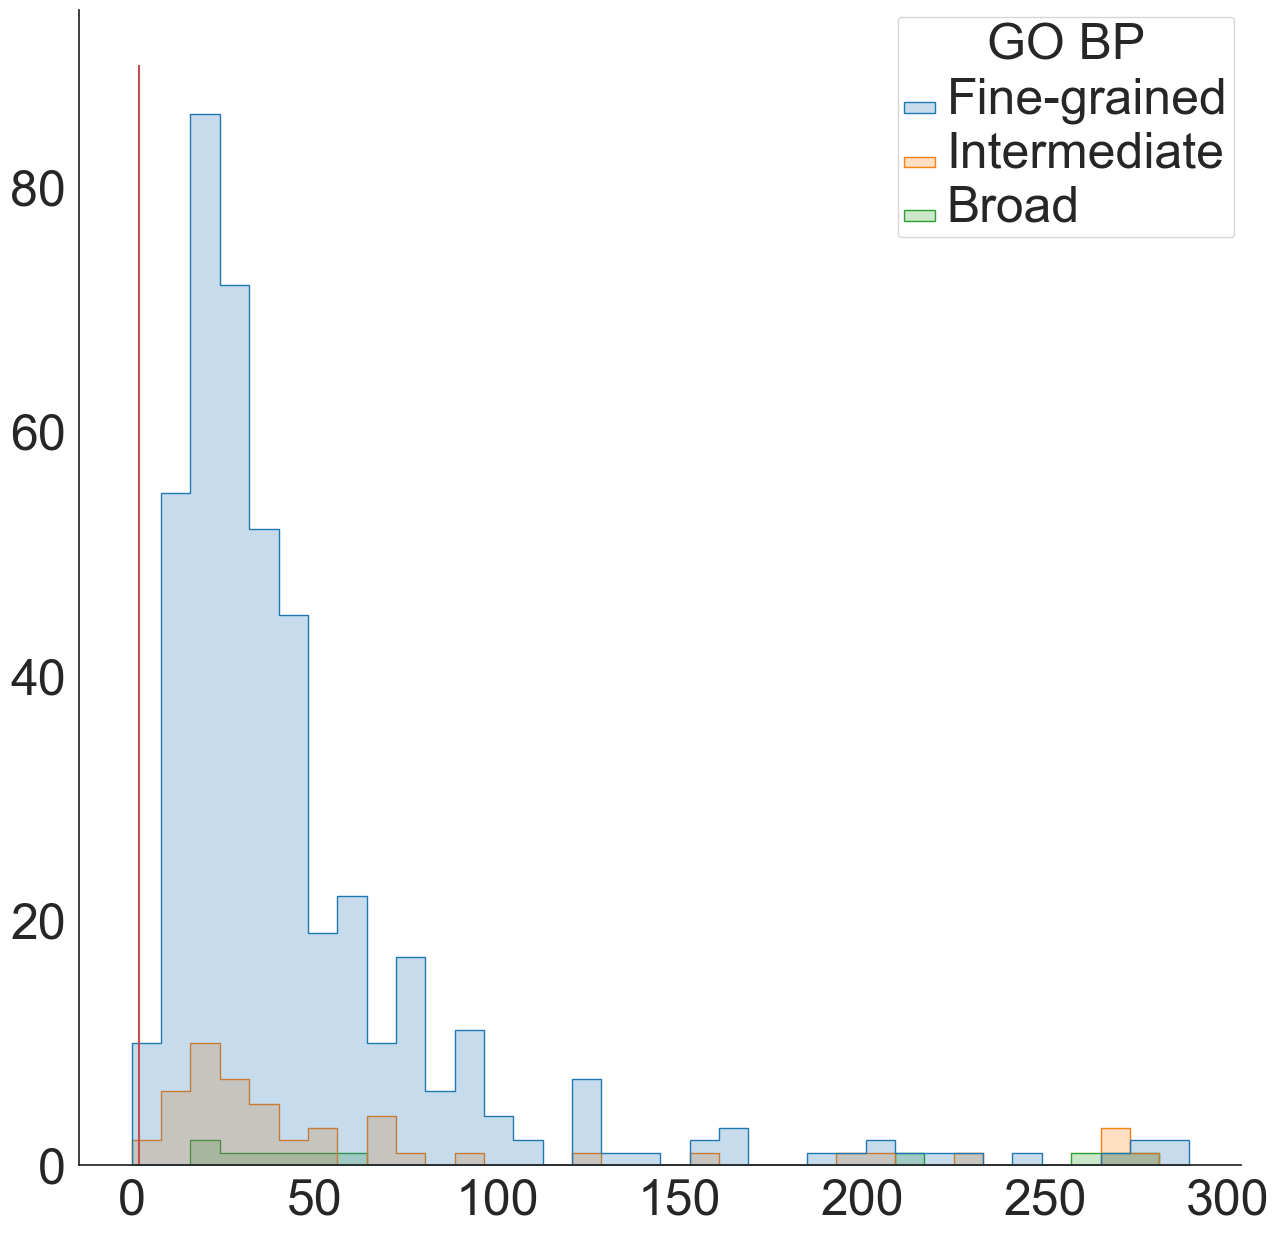

In [116]:
import seaborn as sns
goterms_lcc_df=pd.DataFrame()

finegrained_BP_lcc_zscore=[]
iteration=[]
for com, zscore in fine_grained_communities_gobp_lcc_zscore.items():
    if str(zscore)!="nan" and str(zscore)!="inf":
        finegrained_BP_lcc_zscore.append(float(zscore))
        iteration.append("Fine-grained")
        
        
middle_BP_lcc_zscore=[]

for com, zscore in middle_communities_gobp_lcc_zscore.items():
    if str(zscore)!="nan" and str(zscore)!="inf":
        middle_BP_lcc_zscore.append(float(zscore))
        iteration.append("Intermediate")
        
        
broad_BP_lcc_zscore=[]

for com, zscore in broad_communities_gobp_lcc_zscore.items():
    if str(zscore)!="nan" and str(zscore)!="inf":
        broad_BP_lcc_zscore.append(float(zscore))
        iteration.append("Broad")
        

goterms_lcc_df['zscore']=finegrained_BP_lcc_zscore+middle_BP_lcc_zscore+broad_BP_lcc_zscore
goterms_lcc_df['GO BP']=iteration
fig, ax = plt.subplots(figsize=(15,15))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

#plt.yscale('log')
plt.vlines(x=2,ymin=0,ymax=90,color='r',label='random thershold')
#plt.title('Distribution of lcc z-score for enriched terms GO CC of EEN communities across iterations', fontsize=28)
sns.histplot(
    goterms_lcc_df, x="zscore", hue="GO BP", element="step",palette='tab10',
)
ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)
plt.setp(ax.get_legend().get_texts(), fontsize='36') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='36') # for legend title
plt.xlabel('',fontsize=36)
plt.ylabel('', fontsize=36)
plt.savefig('output/Figures/SF5C_1_v02.pdf',format='pdf',dpi=300, bbox_inches = "tight")



/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_14548/4059598194.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_14548/4059598194.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)


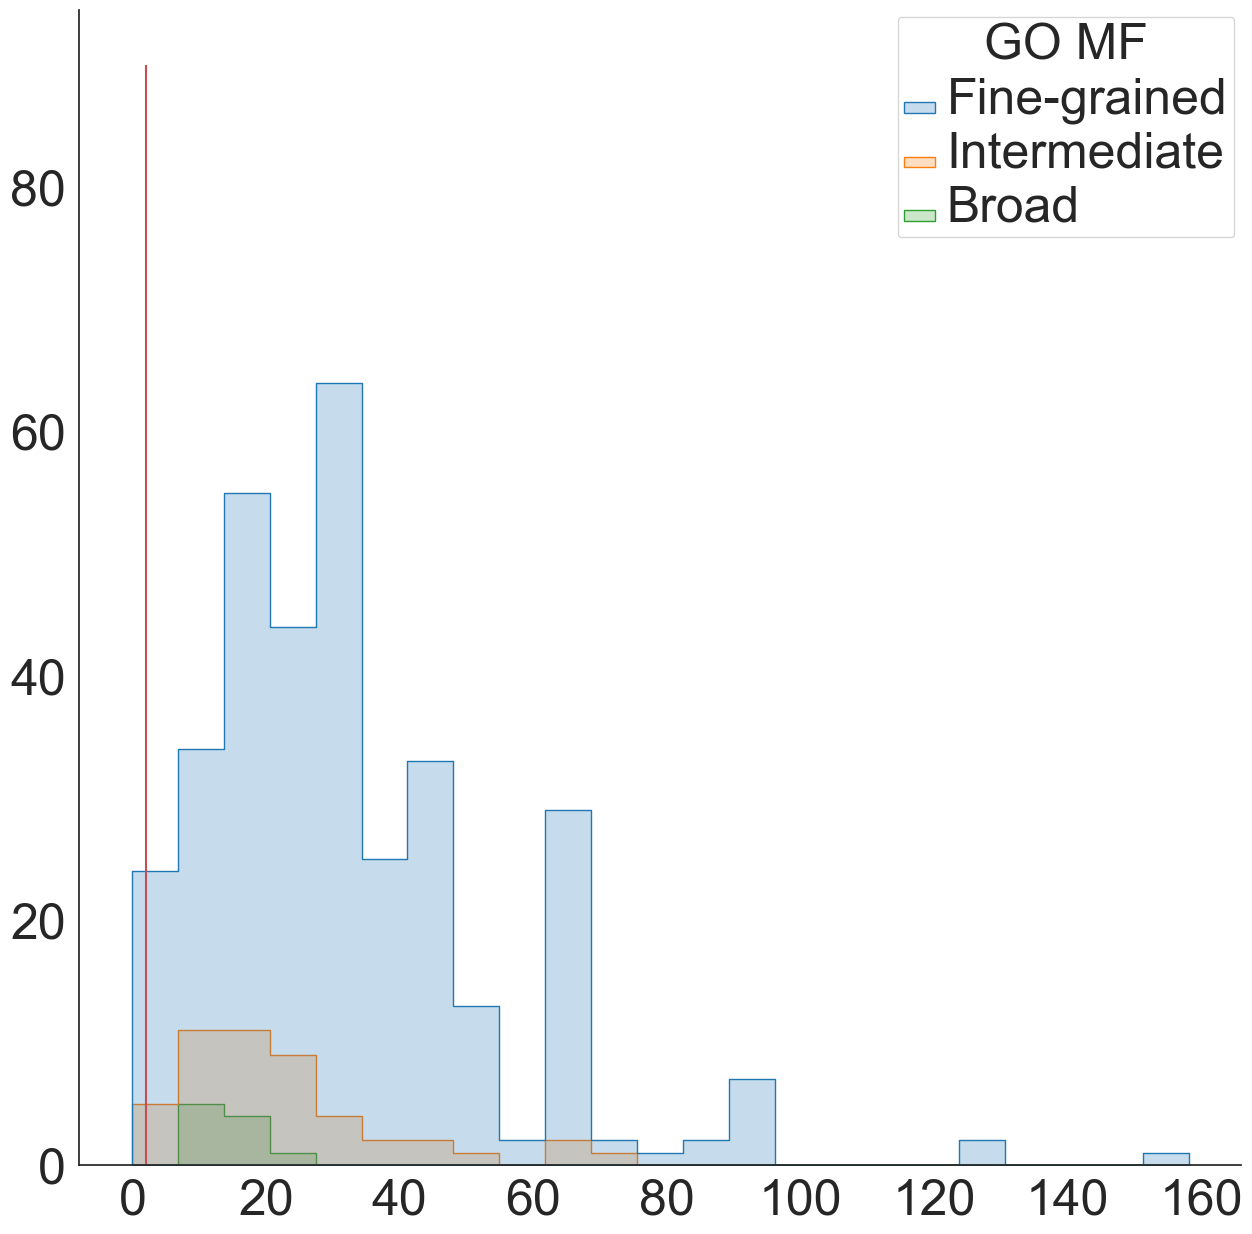

In [117]:
import seaborn as sns
goterms_lcc_df=pd.DataFrame()

finegrained_MF_lcc_zscore=[]
iteration=[]
for com, zscore in fine_grained_communities_gomf_lcc_zscore.items():
    if str(zscore)!="nan" and str(zscore)!="inf":
        finegrained_MF_lcc_zscore.append(float(zscore))
        iteration.append("Fine-grained")
        
        
middle_MF_lcc_zscore=[]

for com, zscore in middle_communities_gomf_lcc_zscore.items():
    if str(zscore)!="nan" and str(zscore)!="inf":
        middle_MF_lcc_zscore.append(float(zscore))
        iteration.append("Intermediate")
        
        
broad_MF_lcc_zscore=[]

for com, zscore in broad_communities_gomf_lcc_zscore.items():
    if str(zscore)!="nan" and str(zscore)!="inf":
        broad_MF_lcc_zscore.append(float(zscore))
        iteration.append("Broad")
        

goterms_lcc_df['zscore']=finegrained_MF_lcc_zscore+middle_MF_lcc_zscore+broad_MF_lcc_zscore
goterms_lcc_df['GO MF']=iteration
fig, ax = plt.subplots(figsize=(15,15))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

#plt.yscale('log')
plt.vlines(x=2,ymin=0,ymax=90,color='r',label='random thershold')
#plt.title('Distribution of lcc z-score for enriched terms GO CC of EEN communities across iterations', fontsize=28)
sns.histplot(
    goterms_lcc_df, x="zscore", hue="GO MF", element="step",palette='tab10',
)
ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)
plt.setp(ax.get_legend().get_texts(), fontsize='36') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='36') # for legend title
plt.xlabel('',fontsize=36)
plt.ylabel('', fontsize=36)
plt.savefig('output/Figures/SF5C_2_v02.pdf',format='pdf',dpi=300, bbox_inches = "tight")


/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_14548/1420835553.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_14548/1420835553.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)


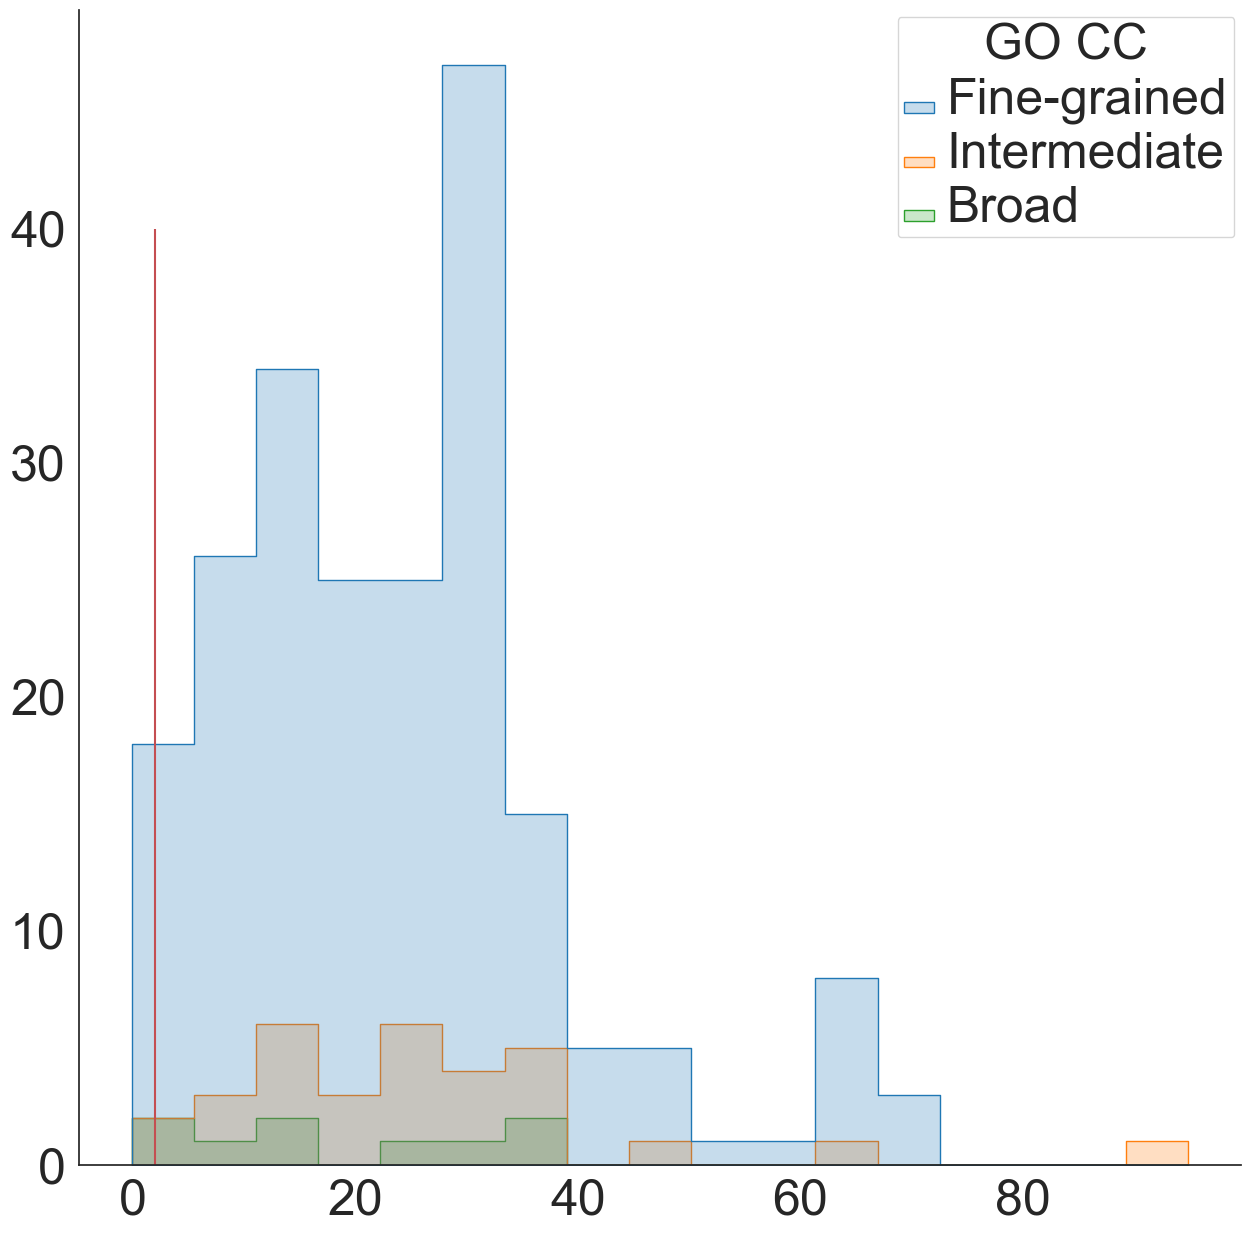

In [118]:
import seaborn as sns
goterms_lcc_df=pd.DataFrame()

finegrained_CC_lcc_zscore=[]
iteration=[]
for com, zscore in fine_grained_communities_gocc_lcc_zscore.items():
    if str(zscore)!="nan" and str(zscore)!="inf":
        finegrained_CC_lcc_zscore.append(float(zscore))
        iteration.append("Fine-grained")
        
        
middle_CC_lcc_zscore=[]

for com, zscore in middle_communities_gocc_lcc_zscore.items():
    if str(zscore)!="nan" and str(zscore)!="inf":
        middle_CC_lcc_zscore.append(float(zscore))
        iteration.append("Intermediate")
        
        
broad_CC_lcc_zscore=[]

for com, zscore in broad_communities_gocc_lcc_zscore.items():
    if str(zscore)!="nan" and str(zscore)!="inf":
        broad_CC_lcc_zscore.append(float(zscore))
        iteration.append("Broad")
        

goterms_lcc_df['zscore']=finegrained_CC_lcc_zscore+middle_CC_lcc_zscore+broad_CC_lcc_zscore
goterms_lcc_df['GO CC']=iteration
fig, ax = plt.subplots(figsize=(15,15))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

#plt.yscale('log')
plt.vlines(x=2,ymin=0,ymax=40,color='r',label='random thershold')
#plt.title('Distribution of lcc z-score for enriched terms GO CC of EEN communities across iterations', fontsize=28)
sns.histplot(
    goterms_lcc_df, x="zscore", hue="GO CC", element="step",palette='tab10',
)
ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)
plt.setp(ax.get_legend().get_texts(), fontsize='36') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='36') # for legend title
plt.xlabel('',fontsize=36)
plt.ylabel('', fontsize=36)
plt.savefig('output/Figures/SF5C_3_v02.pdf',format='pdf',dpi=300, bbox_inches = "tight")

In [119]:
finegrained_enriched_terms=finegrained_BP_lcc_zscore+finegrained_MF_lcc_zscore+finegrained_CC_lcc_zscore
middle_enriched_terms=middle_BP_lcc_zscore+middle_MF_lcc_zscore+middle_CC_lcc_zscore
broad_enriched_terms=broad_BP_lcc_zscore+broad_MF_lcc_zscore+broad_CC_lcc_zscore


In [120]:
t_value,p_value=stats.ttest_ind(finegrained_enriched_terms,middle_enriched_terms)
print("The p-value between fine-grained and middle communities GO z-score distributions is %s" %p_value)
t_value,p_value=stats.ttest_ind(broad_enriched_terms,middle_enriched_terms)
print("The p-value between broad and middle communities of GO z-score distributions is %s" %p_value)
t_value,p_value=stats.ttest_ind(broad_enriched_terms,finegrained_enriched_terms)
print("The p-value between broad and fine-grained communities of GO z-score distributions is %s" %p_value)

The p-value between fine-grained and middle communities GO z-score distributions is 0.2763550522683193
The p-value between broad and middle communities of GO z-score distributions is 0.3221068489747092
The p-value between broad and fine-grained communities of GO z-score distributions is 0.01847162319195063


/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_14548/3947399849.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g=sns.barplot(x=EEN_louvain_com_df["Louvain Iteration"], y=EEN_louvain_com_df["z-score lcc"],estimator=np.median, palette="Blues_d",linewidth=5)
/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_14548/3947399849.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)
/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_14548/3947399849.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, size = 36)


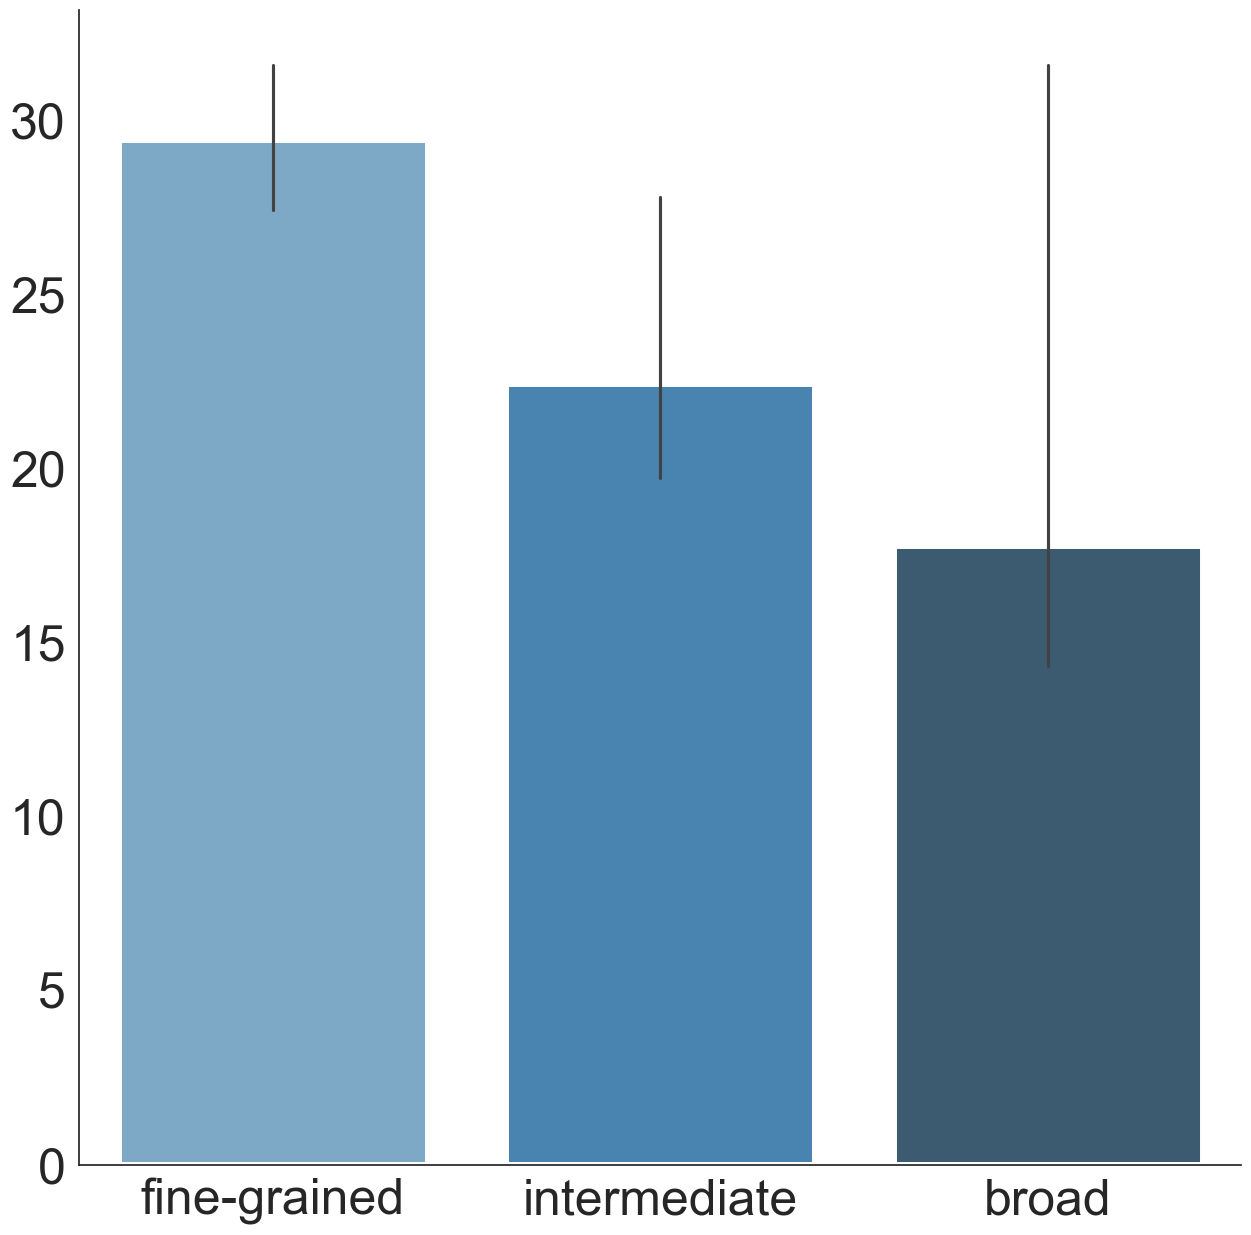

In [123]:
#Here, we check the biological cohesiveness of the enrichment terms for each dividing community


column_names = ["z-score lcc", "louvain Iteration"]
labels=['fine-grained','intermediate','broad']
zscore_list_tot=[]
group_list=[]
for i in finegrained_enriched_terms:
    zscore_list_tot.append(i)
    group_list.append("fine-grained")
    
for i in middle_enriched_terms:
    zscore_list_tot.append(i)
    group_list.append("intermediate")

for i in broad_enriched_terms:
    zscore_list_tot.append(i)
    group_list.append("broad")
    
EEN_louvain_com_df = pd.DataFrame(columns = column_names)
EEN_louvain_com_df["z-score lcc"]=zscore_list_tot
EEN_louvain_com_df["Louvain Iteration"]=group_list

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 15))
sns.set(style="white")

g=sns.barplot(x=EEN_louvain_com_df["Louvain Iteration"], y=EEN_louvain_com_df["z-score lcc"],estimator=np.median, palette="Blues_d",linewidth=5)

#ax = sns.barplot(x="louvain Iteration", y="z-score lcc", data=EEN_louvain_com_df,
#                 palette="Blues_d")
#g.set_yscale("log")
#ax.set_xlabel("Louvain iteration",fontsize=32)
#ax.set_ylabel("lcc z-score enriched terms",fontsize=32)
ax.set_xlabel("",fontsize=32)
ax.set_ylabel("",fontsize=32)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)
ax.set_xticklabels(labels, size = 36)
#plt.savefig('output/Figures/Fig2E.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()

In [122]:
from scipy import stats

t_value,p_value=stats.ttest_ind(finegrained_MF_lcc_zscore,middle_MF_lcc_zscore)
print("The p-value between fine-grained and middle communities of MF z-score distributions is %s" %p_value)
t_value,p_value=stats.ttest_ind(broad_MF_lcc_zscore,middle_MF_lcc_zscore)
print("The p-value between broad and middle communities of MF z-score distributions is %s" %p_value)
t_value,p_value=stats.ttest_ind(broad_MF_lcc_zscore,finegrained_MF_lcc_zscore)
print("The p-value between broad and fine-grained communities of MF z-score distributions is %s" %p_value)


t_value,p_value=stats.ttest_ind(finegrained_BP_lcc_zscore,middle_BP_lcc_zscore)
print("The p-value between fine-grained and middle communities of BP z-score distributions is %s" %p_value)
t_value,p_value=stats.ttest_ind(broad_BP_lcc_zscore,middle_BP_lcc_zscore)
print("The p-value between broad and middle communities of BP z-score distributions is %s" %p_value)
t_value,p_value=stats.ttest_ind(broad_BP_lcc_zscore,finegrained_BP_lcc_zscore)
print("The p-value between broad and fine-grained communities of BP z-score distributions is %s" %p_value)

t_value,p_value=stats.ttest_ind(finegrained_CC_lcc_zscore,middle_CC_lcc_zscore)
print("The p-value between fine-grained and middle communities of CC z-score distributions is %s" %p_value)
t_value,p_value=stats.ttest_ind(broad_CC_lcc_zscore,middle_CC_lcc_zscore)
print("The p-value between broad and middle communities of CC z-score distributions is %s" %p_value)
t_value,p_value=stats.ttest_ind(broad_CC_lcc_zscore,finegrained_CC_lcc_zscore)
print("The p-value between broad and fine-grained communities of CC z-score distributions is %s" %p_value)



The p-value between fine-grained and middle communities of MF z-score distributions is 0.0023558169281339466
The p-value between broad and middle communities of MF z-score distributions is 0.09743317248621532
The p-value between broad and fine-grained communities of MF z-score distributions is 0.007223011124956755
The p-value between fine-grained and middle communities of BP z-score distributions is 0.003946414816983689
The p-value between broad and middle communities of BP z-score distributions is 0.09098038683408209
The p-value between broad and fine-grained communities of BP z-score distributions is 1.5808703349559264e-06
The p-value between fine-grained and middle communities of CC z-score distributions is 0.5394762629909957
The p-value between broad and middle communities of CC z-score distributions is 0.2839679137333817
The p-value between broad and fine-grained communities of CC z-score distributions is 0.3113543173604344


In [ ]:
#Let's calculate the resnik in the Ontology tree 
#This step is performed in the Cluster


import pandas as pd
import networkx as nx
import numpy as np
import pickle as pk
import gseapy as gp
import re
import itertools as it
import math
from collections import (defaultdict,Counter)
import obonet




def precalc_lower_bounds(G):
    """Pre-calculate the number of lower bounds of the graph nodes
    """
    G.lower_bounds = Counter()
    for n in G:
        G.lower_bounds[n] += 1
        for ans in nx.ancestors(G, n):
            G.lower_bounds[ans] += 1
   # G.descriptors.add("Pre-calculated lower bounds")
#This function is the second step for the resnik score calculation
def information_content(G, term):
    """Information content
    Args:
        G(Ontology Graph): Ontology graph object
        term(str): ontolgy term
    Returns:
        str - Information content
    Raises:
        PGSSLookupError: The term was not found in Ontology Graph
        PGSSInvalidOperation: see `pygosemsim.similarity.precalc_lower_bounds`
    """
    if term not in G.lower_bounds:
        raise exception.PGSSLookupError(f"Missing term: {term}")
    freq = G.lower_bounds[term] / len(G)
    return round(-1 * math.log2(freq), 3)

#This function is the third step for the resnik score calculation
def lowest_common_ancestor(G, term1, term2):
    """Naive implementation of lowest common ancestor (LCA)
    Args:
        G(GoGraph): Graph object
        term1(str): Ontology term 1
        term2(str): Ontology term 2
    Returns:
        str - Lowest common ancestor term
        or None if the terms have no common ancestors
    Raises:
        PGSSLookupError: The term was not found in Ontology Graph
        PGSSInvalidOperation: see `pygosemsim.similarity.precalc_lower_bounds`
    """
    if term1 not in G:
        raise exception.PGSSLookupError(f"Missing term: {term1}")
    if term2 not in G:
        raise exception.PGSSLookupError(f"Missing term: {term2}")
    lb1 = nx.ancestors(G, term1) | {term1}
    lb2 = nx.ancestors(G, term2) | {term2}
    common_ans = lb1 & lb2
    if not common_ans:
        return
    return min(common_ans, key=lambda x: G.lower_bounds[x])

#This function would return the resnik score between two terms
def resnik(G, term1, term2):
    """Semantic similarity based on Resnik method
    Args:
        G(GoGraph): Ontology graph object
        term1(str): term 1
        term2(str): term 2
    Returns:
        float - Resnik similarity value (Information content of LCA)
        or None if the terms have no common ancestors
    Raises:
        PGSSLookupError: The term was not found in GoGraph
        PGSSInvalidOperation: see `pygosemsim.similarity.precalc_lower_bounds`
    """
    mica = lowest_common_ancestor(G, term1, term2)
    if mica is not None:
        return information_content(G, mica)



url = 'http://purl.obolibrary.org/obo/go.obo'
graph = obonet.read_obo(url)
graph_up = nx.DiGraph.reverse(graph)
precalc_lower_bounds(graph_up)
term_list=list(graph_up.nodes())
pairwise_list = list(it.combinations(term_list, 2))
GO_resnik={}
for pair in pairwise_list:
    try:
        try:
            GO_resnik[pair[0],pair[1]]=round(resnik(graph_up, pair[0], pair[1]),3)
        except:
            GO_resnik[pair[0],pair[1]]=round(resnik(graph_up, pair[1], pair[0]),3)
    except:
        pass

with open('intermediate/GO_resnik.pickle', 'wb') as handle:
    pk.dump(GO_resnik, handle, protocol=pk.HIGHEST_PROTOCOL)

In [43]:
#We are going to calculate the resnik and a random expectation for each community
#This step is calculated in the cluster


with open('intermediate/GO_resnik.pickle', 'rb') as handle:
    GO_resnik = pk.load(handle)    

GOMF = graph_up.subgraph(list(nx.descendants(graph_up,'GO:0003674')))
GOCC = graph_up.subgraph(list(nx.descendants(graph_up,'GO:0005575')))
GOBP = graph_up.subgraph(list(nx.descendants(graph_up,'GO:0008150')))


#This function is used to calculate the resnik values between a list of terms
def resnik_terms_calculation(terms,resnik_dict):
    resnik_id_list1=[]
    pairwise_list = list(it.combinations(terms, 2))
    for i,j in pairwise_list:
        try:
            resnik_id_list1.append(round(resnik_dict[i,j],3))
        except:
            try:
                resnik_id_list1.append(round(resnik_dict[j,i],3))
            except:
                pass 
    return resnik_id_list1


fine_grained_communities_gomf_resnik={}
for com,term_list in fine_grained_communities_gomf.items():
    enriched_terms_id=terms_extraction(term_list[1])
    fine_grained_communities_gomf_resnik[com]=resnik_terms_calculation(enriched_terms_id,GO_resnik)
middle_communities_gomf_resnik={}
for com,term_list in middle_communities_gomf.items():
    enriched_terms_id=terms_extraction(term_list[1])
    middle_communities_gomf_resnik[com]=resnik_terms_calculation(enriched_terms_id,GO_resnik)
broad_communities_gomf_resnik={}
for com,term_list in broad_communities_gomf.items():
    enriched_terms_id=terms_extraction(term_list[1])
    broad_communities_gomf_resnik[com]=resnik_terms_calculation(enriched_terms_id,GO_resnik)

fine_grained_communities_gocc_resnik={}
for com,term_list in fine_grained_communities_gocc.items():
    enriched_terms_id=terms_extraction(term_list[1])
    fine_grained_communities_gocc_resnik[com]=resnik_terms_calculation(enriched_terms_id,GO_resnik)
middle_communities_gocc_resnik={}
for com,term_list in middle_communities_gocc.items():
    enriched_terms_id=terms_extraction(term_list[1])
    middle_communities_gocc_resnik[com]=resnik_terms_calculation(enriched_terms_id,GO_resnik)
broad_communities_gocc_resnik={}
for com,term_list in broad_communities_gocc.items():
    enriched_terms_id=terms_extraction(term_list[1])
    broad_communities_gocc_resnik[com]=resnik_terms_calculation(enriched_terms_id,GO_resnik)

fine_grained_communities_gobp_resnik={}
for com,term_list in fine_grained_communities_gobp.items():
    enriched_terms_id=terms_extraction(term_list[1])
    fine_grained_communities_gobp_resnik[com]=resnik_terms_calculation(enriched_terms_id,GO_resnik)
middle_communities_gobp_resnik={}
for com,term_list in middle_communities_gobp.items():
    enriched_terms_id=terms_extraction(term_list[1])
    middle_communities_gobp_resnik[com]=resnik_terms_calculation(enriched_terms_id,GO_resnik)
broad_communities_gobp_resnik={}
for com,term_list in broad_communities_gobp.items():
    enriched_terms_id=terms_extraction(term_list[1])
    broad_communities_gobp_resnik[com]=resnik_terms_calculation(enriched_terms_id,GO_resnik)

with open('output/Communities/Louvain/fine_grained_communities_gomf_resnik.pickle', 'wb') as handle:
    pk.dump(fine_grained_communities_gomf_resnik, handle, protocol=pk.HIGHEST_PROTOCOL)
with open('output/Communities/Louvain/middle_communities_gomf_resnik.pickle', 'wb') as handle:
    pk.dump(middle_communities_gomf_resnik, handle, protocol=pk.HIGHEST_PROTOCOL)
with open('output/Communities/Louvain/broad_communities_gomf_resnik.pickle', 'wb') as handle:
    pk.dump(broad_communities_gomf_resnik, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/Louvain/fine_grained_communities_gocc_resnik.pickle', 'wb') as handle:
    pk.dump(fine_grained_communities_gocc_resnik, handle, protocol=pk.HIGHEST_PROTOCOL)
with open('output/Communities/Louvain/middle_communities_gocc_resnik.pickle', 'wb') as handle:
    pk.dump(middle_communities_gocc_resnik, handle, protocol=pk.HIGHEST_PROTOCOL)
with open('output/Communities/Louvain/broad_communities_gocc_resnik.pickle', 'wb') as handle:
    pk.dump(broad_communities_gocc_resnik, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/Louvain/fine_grained_communities_gobp_resnik.pickle', 'wb') as handle:
    pk.dump(fine_grained_communities_gobp_resnik, handle, protocol=pk.HIGHEST_PROTOCOL)
with open('output/Communities/Louvain/middle_communities_gobp_resnik.pickle', 'wb') as handle:
    pk.dump(middle_communities_gobp_resnik, handle, protocol=pk.HIGHEST_PROTOCOL)
with open('output/Communities/Louvain/broad_communities_gobp_resnik.pickle', 'wb') as handle:
    pk.dump(broad_communities_gobp_resnik, handle, protocol=pk.HIGHEST_PROTOCOL)

#Let's go for calculating the random expectation


#This function will create a random expectation for a list of enriched terms
#it returns the avg random expected resnik values and a z-score for significance

def random_resnik_expectation(terms, resnik_id_list1,resnik_dict, ontology_tree):   #it needs the list of enriched terms, calculated resnik and HPO tree
    term_sample_size = len(set(terms))
    avg_random_resnik_list = []
    if term_sample_size>2:
        while len(avg_random_resnik_list) < 1000:
            term_sample = rd.sample(ontology_tree.nodes(), term_sample_size)
            resnik_randomid_list1 = []
            pairwise_list = list(it.combinations(term_sample, 2))
            for i, j in pairwise_list:
                try:
                    try:
                        resnik_randomid_list1.append(round(resnik_dict[i,j],3))
                    except:
                        resnik_randomid_list1.append(round(resnik_dict[j,i],3))
                except:
                    pass
            resnik_randomid_list1_cleaned = [x for x in resnik_randomid_list1 if str(x) != 'nan']
            if str(np.mean(resnik_randomid_list1_cleaned)) != 'nan':
                avg_random_resnik_list.append(np.mean(resnik_randomid_list1_cleaned))
            else:
                pass
        mu = np.mean(avg_random_resnik_list)
        std = np.std(avg_random_resnik_list)
        z = (np.mean(resnik_id_list1) - mu) / std
    else:
        z = 'nan'
    return avg_random_resnik_list,z


rd_fine_grained_communities_gomf_resnik={}
for com,term_list in fine_grained_communities_gomf.items():
    rd_fine_grained_communities_gomf_resnik[com]=random_resnik_expectation(term_list,fine_grained_communities_gomf_resnik[com],GO_resnik,GOMF)
    
rd_middle_communities_gomf_resnik={}
for com,term_list in middle_communities_gomf.items():
    rd_middle_communities_gomf_resnik[com]=random_resnik_expectation(term_list,middle_communities_gomf_resnik[com],GO_resnik,GOMF)

rd_broad_communities_gomf_resnik={}
for com,term_list in broad_communities_gomf.items():
    rd_braod_communities_gomf_resnik[com]=random_resnik_expectation(term_list,broad_communities_gomf_resnik[com],GO_resnik,GOMF)

rd_fine_grained_communities_gocc_resnik={}
for com,term_list in fine_grained_communities_gocc.items():
    rd_fine_grained_communities_gocc_resnik[com]=random_resnik_expectation(term_list,fine_grained_communities_gocc_resnik[com],GO_resnik,GOCC)   

rd_middle_communities_gocc_resnik={}
for com,term_list in middle_communities_gocc.items():
    rd_middle_communities_gocc_resnik[com]=random_resnik_expectation(term_list,middle_communities_gocc_resnik[com],GO_resnik,GOCC)

rd_broad_communities_gocc_resnik={}
for com,term_list in broad_communities_gocc.items():
    rd_braod_communities_gocc_resnik[com]=random_resnik_expectation(term_list,broad_communities_gocc_resnik[com],GO_resnik,GOCC)
    
rd_fine_grained_communities_gobp_resnik={}
for com,term_list in fine_grained_communities_gobp.items():
    rd_fine_grained_communities_gobp_resnik[com]=random_resnik_expectation(term_list,fine_grained_communities_gobp_resnik[com],GO_resnik,GOBP) 

rd_middle_communities_gobp_resnik={}
for com,term_list in middle_communities_gobp.items():
    rd_middle_communities_gobp_resnik[com]=random_resnik_expectation(term_list,middle_communities_gobp_resnik[com],GO_resnik,GOBP)

rd_broad_communities_gobp_resnik={}
for com,term_list in broad_communities_gobp.items():
    rd_braod_communities_gobp_resnik[com]=random_resnik_expectation(term_list,broad_communities_gobp_resnik[com],GO_resnik,GOBP)

with open('output/Communities/Louvain/rd_fine_grained_communities_gomf_resnik.pickle', 'wb') as handle:
    pk.dump(rd_fine_grained_communities_gomf_resnik, handle, protocol=pk.HIGHEST_PROTOCOL)
with open('output/Communities/Louvain/rd_middle_communities_gomf_resnik.pickle', 'wb') as handle:
    pk.dump(rd_middle_communities_gomf_resnik, handle, protocol=pk.HIGHEST_PROTOCOL)
with open('output/Communities/Louvain/rd_broad_communities_gomf_resnik.pickle', 'wb') as handle:
    pk.dump(rd_broad_communities_gomf_resnik, handle, protocol=pk.HIGHEST_PROTOCOL)
with open('output/Communities/Louvain/rd_fine_grained_communities_gocc_resnik.pickle', 'wb') as handle:
    pk.dump(rd_fine_grained_communities_gocc_resnik, handle, protocol=pk.HIGHEST_PROTOCOL)
with open('output/Communities/Louvain/rd_middle_communities_gocc_resnik.pickle', 'wb') as handle:
    pk.dump(rd_middle_communities_gocc_resnik, handle, protocol=pk.HIGHEST_PROTOCOL)
with open('output/Communities/Louvain/rd_broad_communities_gocc_resnik.pickle', 'wb') as handle:
    pk.dump(rd_broad_communities_gocc_resnik, handle, protocol=pk.HIGHEST_PROTOCOL)
with open('output/Communities/Louvain/rd_fine_grained_communities_gobp_resnik.pickle', 'wb') as handle:
    pk.dump(rd_fine_grained_communities_gobp_resnik, handle, protocol=pk.HIGHEST_PROTOCOL)
with open('output/Communities/Louvain/rd_middle_communities_gobp_resnik.pickle', 'wb') as handle:
    pk.dump(rd_middle_communities_gobp_resnik, handle, protocol=pk.HIGHEST_PROTOCOL)
with open('output/Communities/Louvain/rd_broad_communities_gobp_resnik.pickle', 'wb') as handle:
    pk.dump(rd_broad_communities_gobp_resnik, handle, protocol=pk.HIGHEST_PROTOCOL)



In [232]:
#Let's import the results
with open('output/Communities/Louvain/fine_grained_communities_gobp_resnik.pickle', 'rb') as handle:
    fine_grained_communities_gobp_resnik = pk.load(handle)    
with open('output/Communities/Louvain/fine_grained_communities_gomf_resnik.pickle', 'rb') as handle:
    fine_grained_communities_gomf_resnik = pk.load(handle)    
with open('output/Communities/Louvain/fine_grained_communities_gocc_resnik.pickle', 'rb') as handle:
    fine_grained_communities_gocc_resnik = pk.load(handle)
with open('output/Communities/Louvain/middle_communities_gobp_resnik.pickle', 'rb') as handle:
    middle_communities_gobp_resnik = pk.load(handle)    
with open('output/Communities/Louvain/middle_communities_gomf_resnik.pickle', 'rb') as handle:
    middle_communities_gomf_resnik = pk.load(handle)    
with open('output/Communities/Louvain/middle_communities_gocc_resnik.pickle', 'rb') as handle:
    middle_communities_gocc_resnik = pk.load(handle)
with open('output/Communities/Louvain/broad_communities_gobp_resnik.pickle', 'rb') as handle:
    broad_communities_gobp_resnik = pk.load(handle)    
with open('output/Communities/Louvain/broad_communities_gomf_resnik.pickle', 'rb') as handle:
    broad_communities_gomf_resnik = pk.load(handle)    
with open('output/Communities/Louvain/broad_communities_gocc_resnik.pickle', 'rb') as handle:
    broad_communities_gocc_resnik = pk.load(handle)
    

/Users/lsd/anaconda3/envs/Exposurome/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/lsd/anaconda3/envs/Exposurome/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_14548/2284232827.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_14548/2284232827.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)


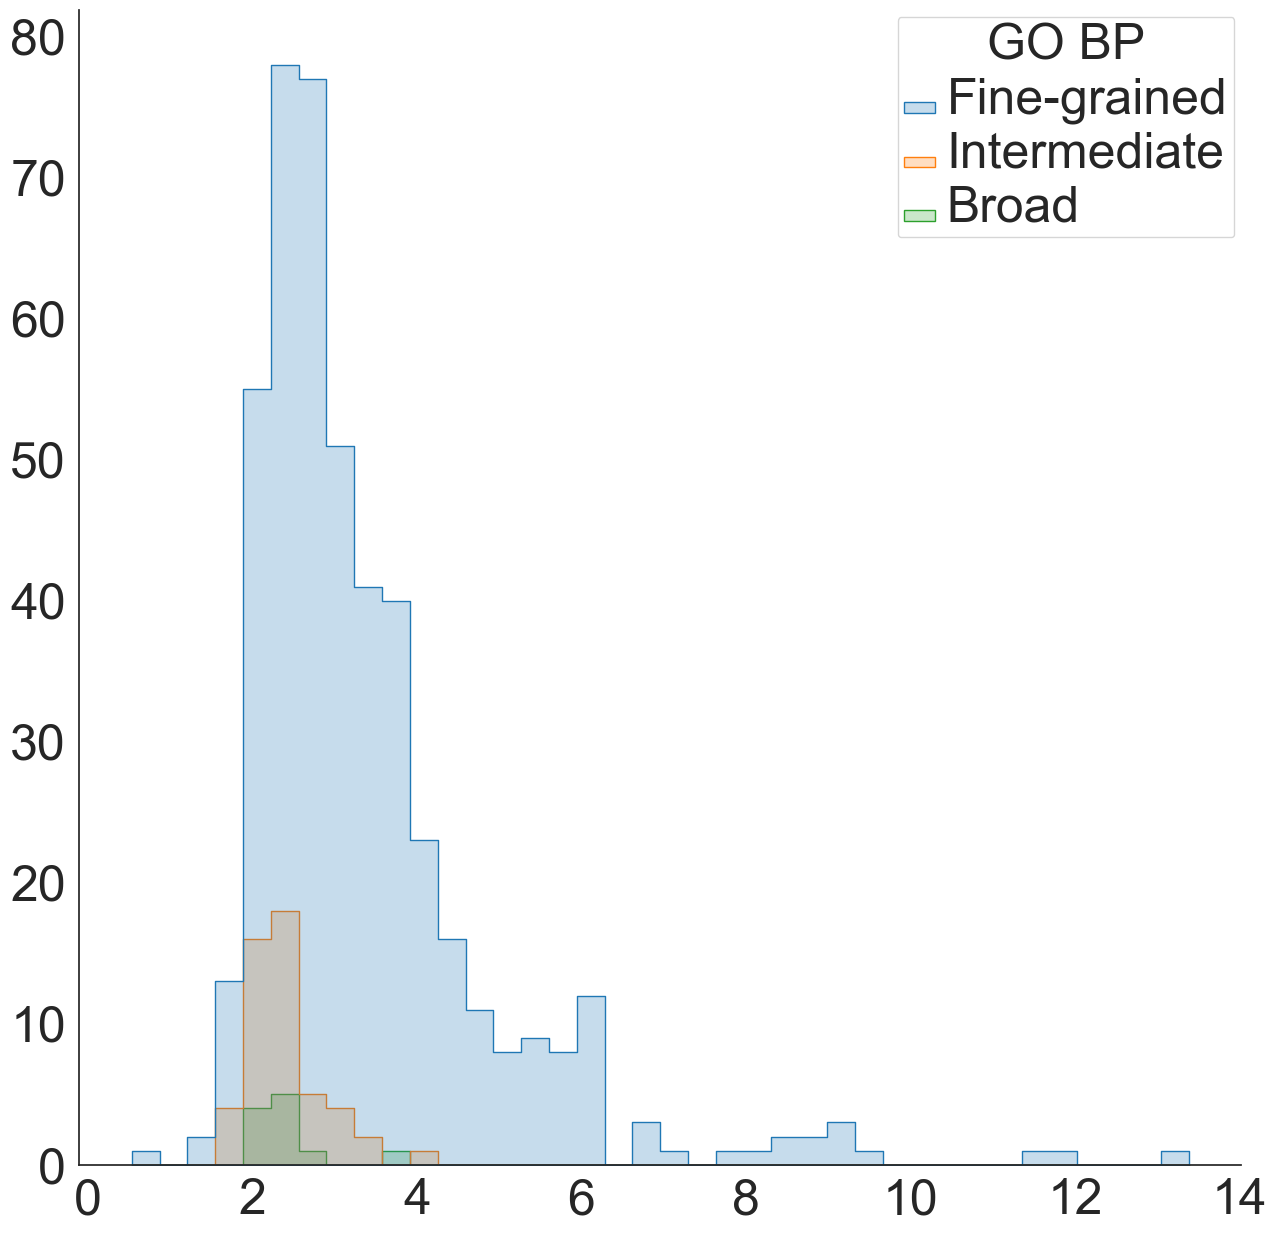

In [292]:
goterms_resnik_df=pd.DataFrame()

finegrained_BP_resnik=[]
iteration=[]
for com, resnik in fine_grained_communities_gobp_resnik.items():
    cl_resnik_list=[]
    for r in resnik:
        if str(r)!="nan" and str(r)!="inf":
            cl_resnik_list.append(r)
    finegrained_BP_resnik.append(float(np.mean(cl_resnik_list)))
    iteration.append("Fine-grained")
        
        
middle_BP_resnik=[]
for com, resnik in middle_communities_gobp_resnik.items():
    cl_resnik_list=[]
    for r in resnik:
        if str(r)!="nan" and str(r)!="inf":
            cl_resnik_list.append(r)
    middle_BP_resnik.append(float(np.mean(cl_resnik_list)))
    iteration.append("Intermediate")
        
        
broad_BP_resnik=[]
for com, resnik in broad_communities_gobp_resnik.items():
    cl_resnik_list=[]
    for r in resnik:
        if str(r)!="nan" and str(r)!="inf":
            cl_resnik_list.append(r)
    broad_BP_resnik.append(float(np.mean(cl_resnik_list)))
    iteration.append("Broad")
        
goterms_resnik_df['resnik']=finegrained_BP_resnik+middle_BP_resnik+broad_BP_resnik
goterms_resnik_df['GO BP']=iteration
fig, ax = plt.subplots(figsize=(15,15))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

#plt.yscale('log')


sns.histplot(
    goterms_resnik_df, x="resnik", hue="GO BP", element="step",palette='tab10',
)
ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)
plt.setp(ax.get_legend().get_texts(), fontsize='36') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='36') # for legend title
plt.xlabel('',fontsize=36)
plt.ylabel('', fontsize=36)
plt.savefig('output/Figures/SF6A_1_v03.pdf',format='pdf',dpi=300, bbox_inches = "tight")


/Users/lsd/anaconda3/envs/Exposurome/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/lsd/anaconda3/envs/Exposurome/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_14548/3738086849.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_14548/3738086849.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)


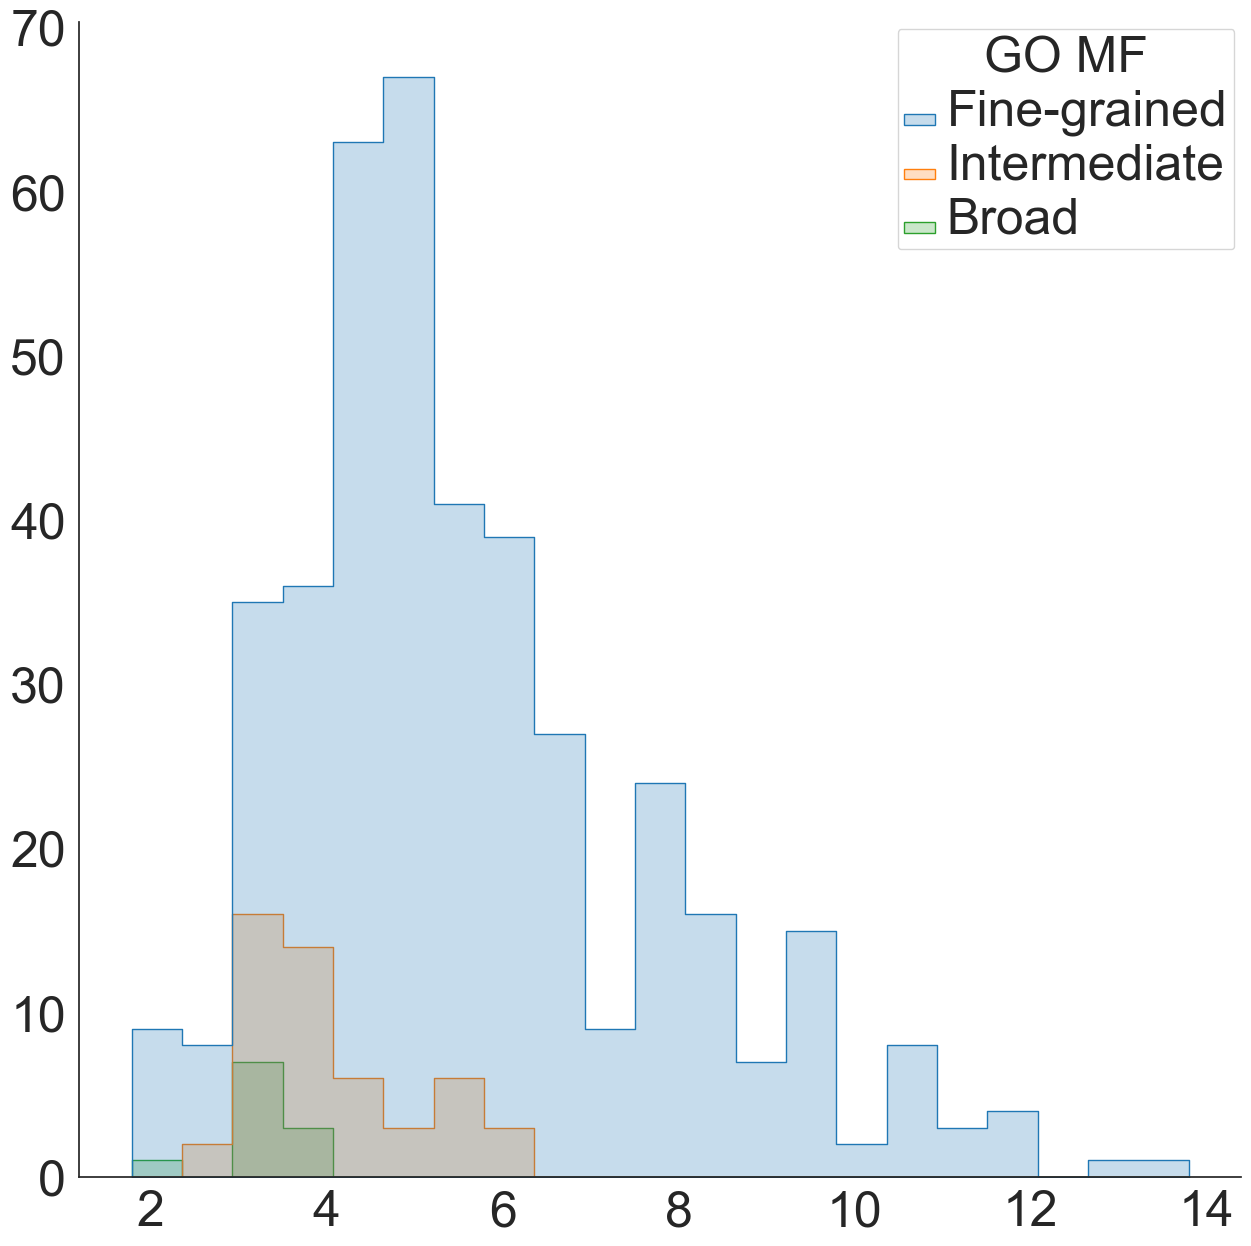

In [293]:
goterms_resnik_df=pd.DataFrame()

finegrained_MF_resnik=[]
iteration=[]
for com, resnik in fine_grained_communities_gomf_resnik.items():
    cl_resnik_list=[]
    for r in resnik:
        if str(r)!="nan" and str(r)!="inf":
            cl_resnik_list.append(r)
    finegrained_MF_resnik.append(float(np.mean(cl_resnik_list)))
    iteration.append("Fine-grained")
        
        
middle_MF_resnik=[]
for com, resnik in middle_communities_gomf_resnik.items():
    cl_resnik_list=[]
    for r in resnik:
        if str(r)!="nan" and str(r)!="inf":
            cl_resnik_list.append(r)
    middle_MF_resnik.append(float(np.mean(cl_resnik_list)))
    iteration.append("Intermediate")
        
        
broad_MF_resnik=[]
for com, resnik in broad_communities_gomf_resnik.items():
    cl_resnik_list=[]
    for r in resnik:
        if str(r)!="nan" and str(r)!="inf":
            cl_resnik_list.append(r)
    broad_MF_resnik.append(float(np.mean(cl_resnik_list)))
    iteration.append("Broad")
        
goterms_resnik_df['resnik']=finegrained_MF_resnik+middle_MF_resnik+broad_MF_resnik
goterms_resnik_df['GO MF']=iteration
fig, ax = plt.subplots(figsize=(15,15))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

#plt.yscale('log')

#plt.title('Distribution of lcc z-score for enriched terms GO CC of EEN communities across iterations', fontsize=28)
sns.histplot(
    goterms_resnik_df, x="resnik", hue="GO MF", element="step",palette='tab10',
)
ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)
plt.setp(ax.get_legend().get_texts(), fontsize='36') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='36') # for legend title
plt.xlabel('',fontsize=36)
plt.ylabel('', fontsize=36)
plt.savefig('output/Figures/SF6A_2_v03.pdf',format='pdf',dpi=300, bbox_inches = "tight")


/Users/lsd/anaconda3/envs/Exposurome/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/lsd/anaconda3/envs/Exposurome/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_14548/1566488919.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_14548/1566488919.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)


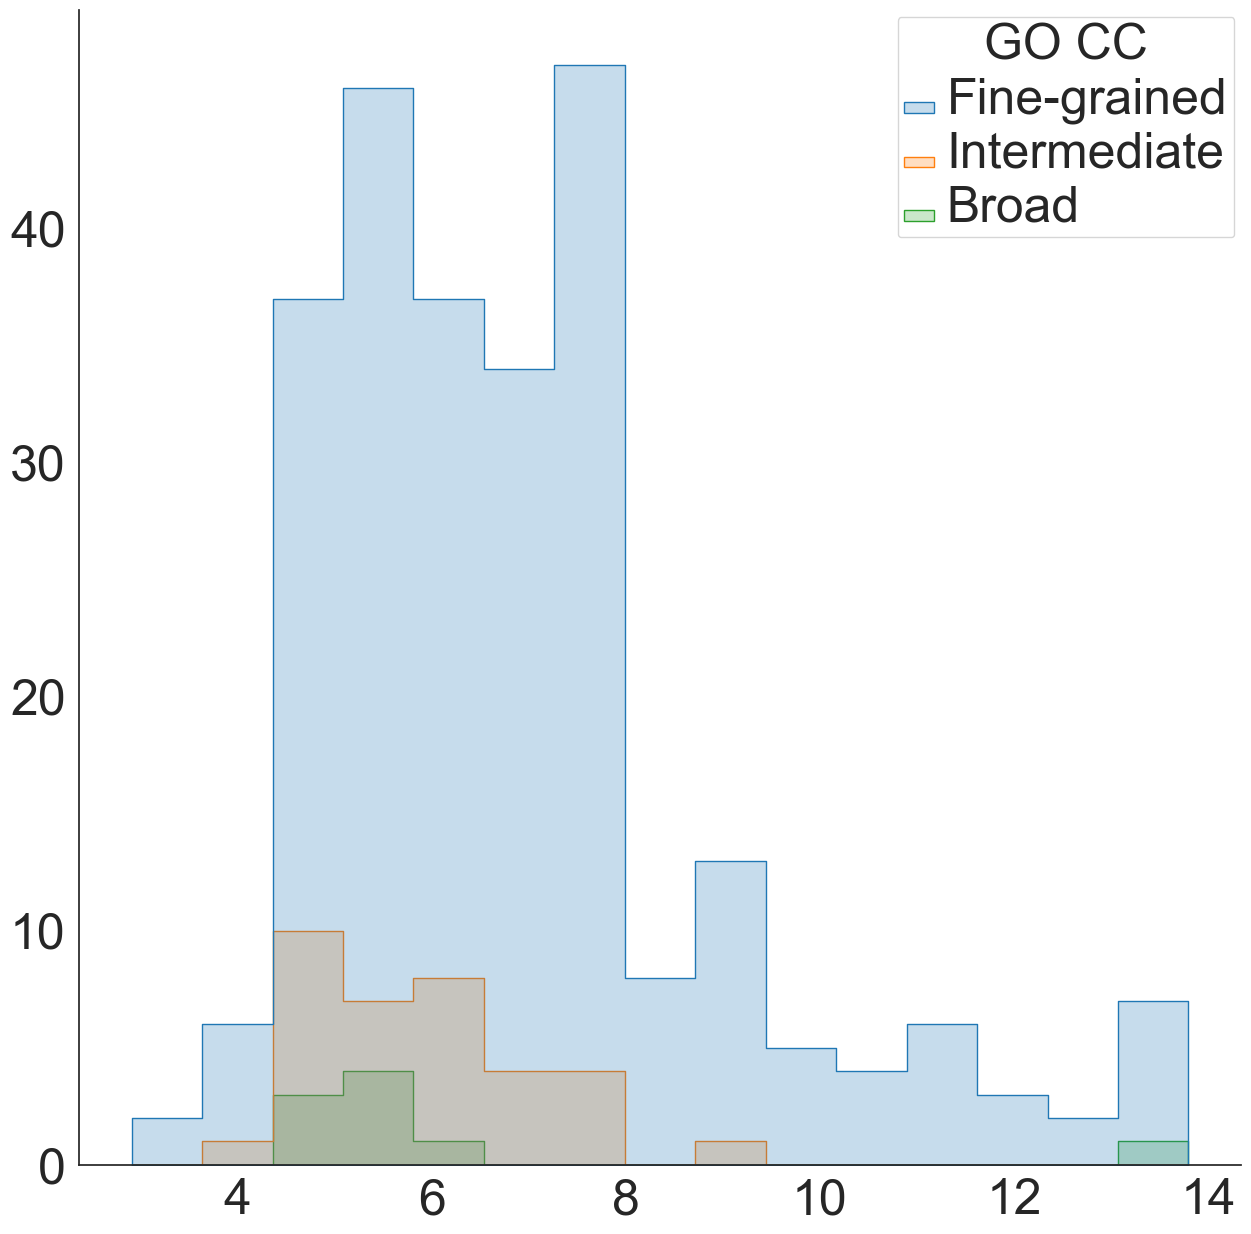

In [294]:
goterms_resnik_df=pd.DataFrame()

finegrained_CC_resnik=[]
iteration=[]
for com, resnik in fine_grained_communities_gocc_resnik.items():
    cl_resnik_list=[]
    for r in resnik:
        if str(r)!="nan" and str(r)!="inf":
            cl_resnik_list.append(r)
    finegrained_CC_resnik.append(float(np.mean(cl_resnik_list)))
    iteration.append("Fine-grained")
        
        
middle_CC_resnik=[]
for com, resnik in middle_communities_gocc_resnik.items():
    cl_resnik_list=[]
    for r in resnik:
        if str(r)!="nan" and str(r)!="inf":
            cl_resnik_list.append(r)
    middle_CC_resnik.append(float(np.mean(cl_resnik_list)))
    iteration.append("Intermediate")
        
        
broad_CC_resnik=[]
for com, resnik in broad_communities_gocc_resnik.items():
    cl_resnik_list=[]
    for r in resnik:
        if str(r)!="nan" and str(r)!="inf":
            cl_resnik_list.append(r)
    broad_CC_resnik.append(float(np.mean(cl_resnik_list)))
    iteration.append("Broad")
        
goterms_resnik_df['resnik']=finegrained_CC_resnik+middle_CC_resnik+broad_CC_resnik
goterms_resnik_df['GO CC']=iteration
fig, ax = plt.subplots(figsize=(15,15))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

#plt.yscale('log')

#plt.title('Distribution of lcc z-score for enriched terms GO CC of EEN communities across iterations', fontsize=28)
sns.histplot(
    goterms_resnik_df, x="resnik", hue="GO CC", element="step",palette='tab10',
)
ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)
plt.setp(ax.get_legend().get_texts(), fontsize='36') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='36') # for legend title
plt.xlabel('',fontsize=36)
plt.ylabel('', fontsize=36)
plt.savefig('output/Figures/SF6A_3_v03.pdf',format='pdf',dpi=300, bbox_inches = "tight")


In [249]:
finegrained_enriched_terms_resnik = finegrained_BP_resnik+finegrained_MF_resnik+finegrained_CC_resnik
middle_enriched_terms_resnik = middle_BP_resnik+middle_MF_resnik+middle_CC_resnik
broad_enriched_terms_resnik = broad_BP_resnik+broad_MF_resnik+broad_CC_resnik

finegrained_enriched_terms_resnik_clean = [i for i in finegrained_enriched_terms_resnik if str(i)!='nan']
middle_enriched_terms_resnik_clean = [i for i in middle_enriched_terms_resnik if str(i)!='nan']
broad_enriched_terms_resnik_clean = [i for i in broad_enriched_terms_resnik if str(i)!='nan']

/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_14548/83960292.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)
/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_14548/83960292.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, size = 36)


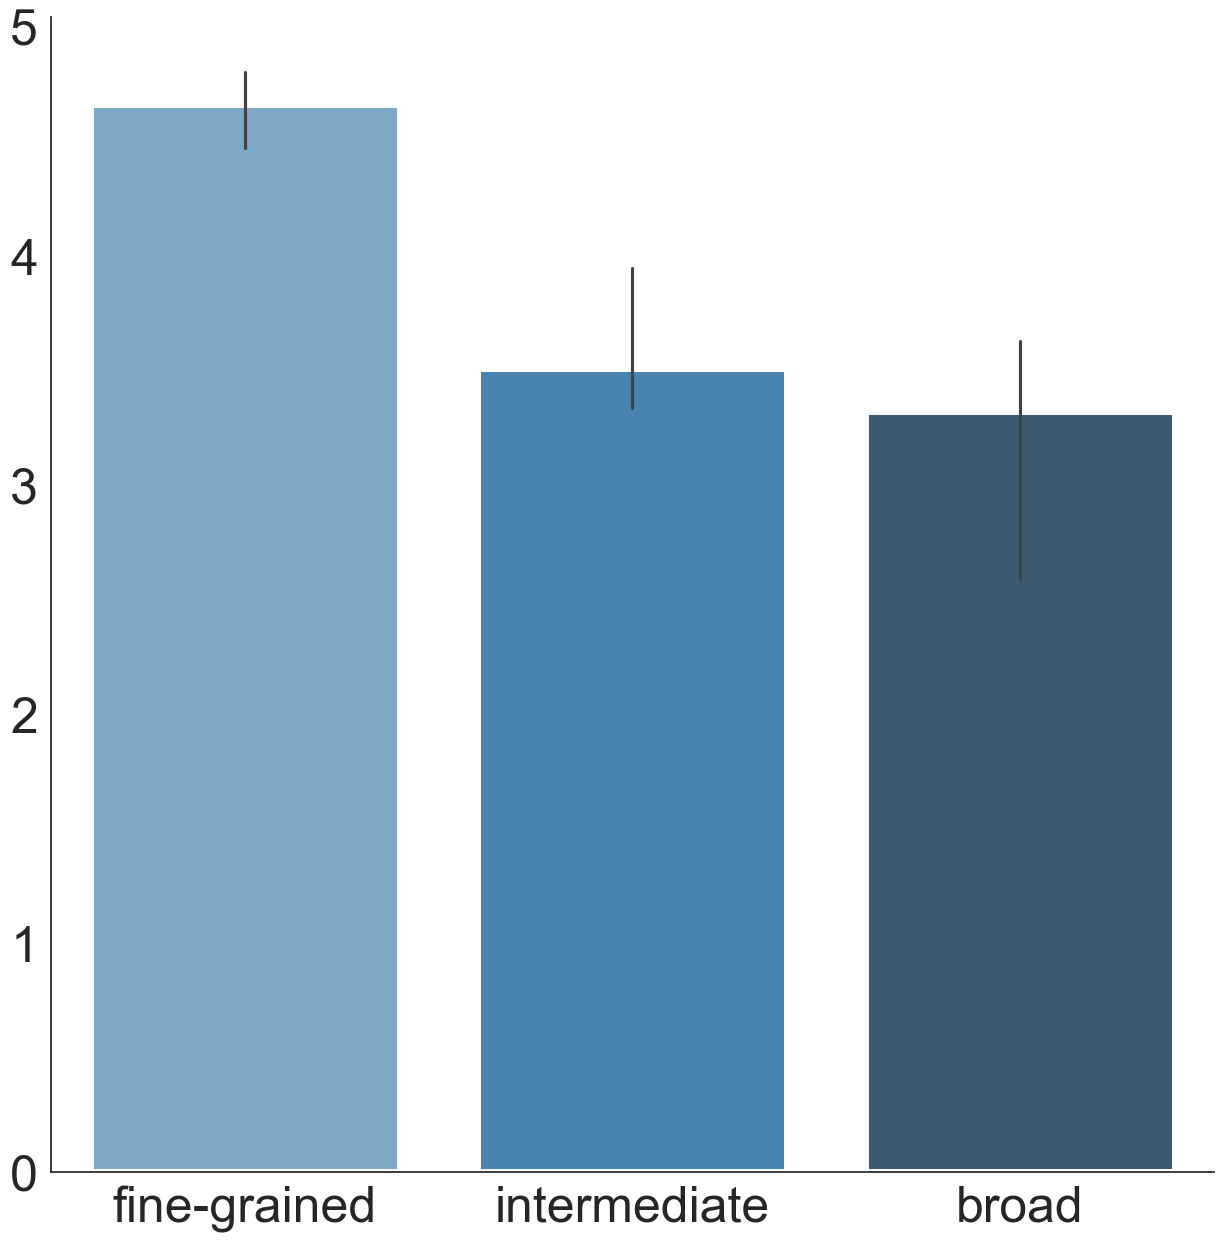

In [291]:
#Here, we check the biological cohesiveness of the enrichment terms for each dividing community

column_names = ["resnik", "louvain Iteration"]
labels=['fine-grained','intermediate','broad']
resnik_list_tot=[]
group_list=[]
for i in finegrained_enriched_terms_resnik_clean:
    resnik_list_tot.append(i)
    group_list.append("fine-grained")
    
for i in middle_enriched_terms_resnik_clean:
    resnik_list_tot.append(i)
    group_list.append("intermediate")

for i in broad_enriched_terms_resnik_clean:
    resnik_list_tot.append(i)
    group_list.append("broad")
    
EEN_louvain_com_df = pd.DataFrame(columns = column_names)
EEN_louvain_com_df["resnik"]=resnik_list_tot
EEN_louvain_com_df["Louvain Iteration"]=group_list


fig, ax = plt.subplots(figsize=(15, 15))
sns.set(style="white")

g=sns.barplot(x=EEN_louvain_com_df["Louvain Iteration"], y=EEN_louvain_com_df["resnik"],estimator=np.median, hue=EEN_louvain_com_df["Louvain Iteration"], palette="Blues_d",legend=False,linewidth=5)


ax.set_xlabel("",fontsize=32)
ax.set_ylabel("",fontsize=32)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)
ax.set_xticklabels(labels, size = 36)
plt.savefig('output/Figures/SF6C_v03.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()

In [290]:
t_value,p_value=stats.ttest_ind(finegrained_enriched_terms_resnik_clean,middle_enriched_terms_resnik_clean)
print("The p-value between fine-grained and middle communities GO Resnik distributions is %s" %p_value)
t_value,p_value=stats.ttest_ind(broad_enriched_terms_resnik_clean,middle_enriched_terms_resnik_clean)
print("The p-value between broad and middle communities of GO Resnik distributions is %s" %p_value)
t_value,p_value=stats.ttest_ind(broad_enriched_terms_resnik_clean,finegrained_enriched_terms_resnik_clean)
print("The p-value between broad and fine-grained communities of GO Resnik distributions is %s" %p_value)

The p-value between fine-grained and middle communities GO Resnik distributions is 2.304913367195078e-07
The p-value between broad and middle communities of GO Resnik distributions is 0.6638942884444843
The p-value between broad and fine-grained communities of GO Resnik distributions is 0.004027625562821207


In [351]:
#Let's import the random expectations


with open('output/Communities/Louvain/rd_fine_grained_communities_gomf_resnik.pickle', 'rb') as handle:
    rd_fine_grained_communities_gomf_resnik = pk.load(handle)    
with open('output/Communities/Louvain/rd_middle_communities_gomf_resnik.pickle', 'rb') as handle:
    rd_middle_communities_gomf_resnik = pk.load(handle)    
with open('output/Communities/Louvain/rd_broad_communities_gomf_resnik.pickle', 'rb') as handle:
    rd_broad_communities_gomf_resnik = pk.load(handle)
with open('output/Communities/Louvain/rd_fine_grained_communities_gocc_resnik.pickle', 'rb') as handle:
    rd_fine_grained_communities_gocc_resnik = pk.load(handle)    
with open('output/Communities/Louvain/rd_middle_communities_gocc_resnik.pickle', 'rb') as handle:
    rd_middle_communities_gocc_resnik = pk.load(handle)    
with open('output/Communities/Louvain/rd_broad_communities_gocc_resnik.pickle', 'rb') as handle:
    rd_broad_communities_gocc_resnik = pk.load(handle)
with open('output/Communities/Louvain/rd_fine_grained_communities_gobp_resnik.pickle', 'rb') as handle:
    rd_fine_grained_communities_gobp_resnik = pk.load(handle)    
with open('output/Communities/Louvain/rd_middle_communities_gobp_resnik.pickle', 'rb') as handle:
    rd_middle_communities_gobp_resnik = pk.load(handle)    
with open('output/Communities/Louvain/rd_broad_communities_gobp_resnik.pickle', 'rb') as handle:
    rd_broad_communities_gobp_resnik = pk.load(handle)
    

/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_14548/628456827.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_14548/628456827.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)


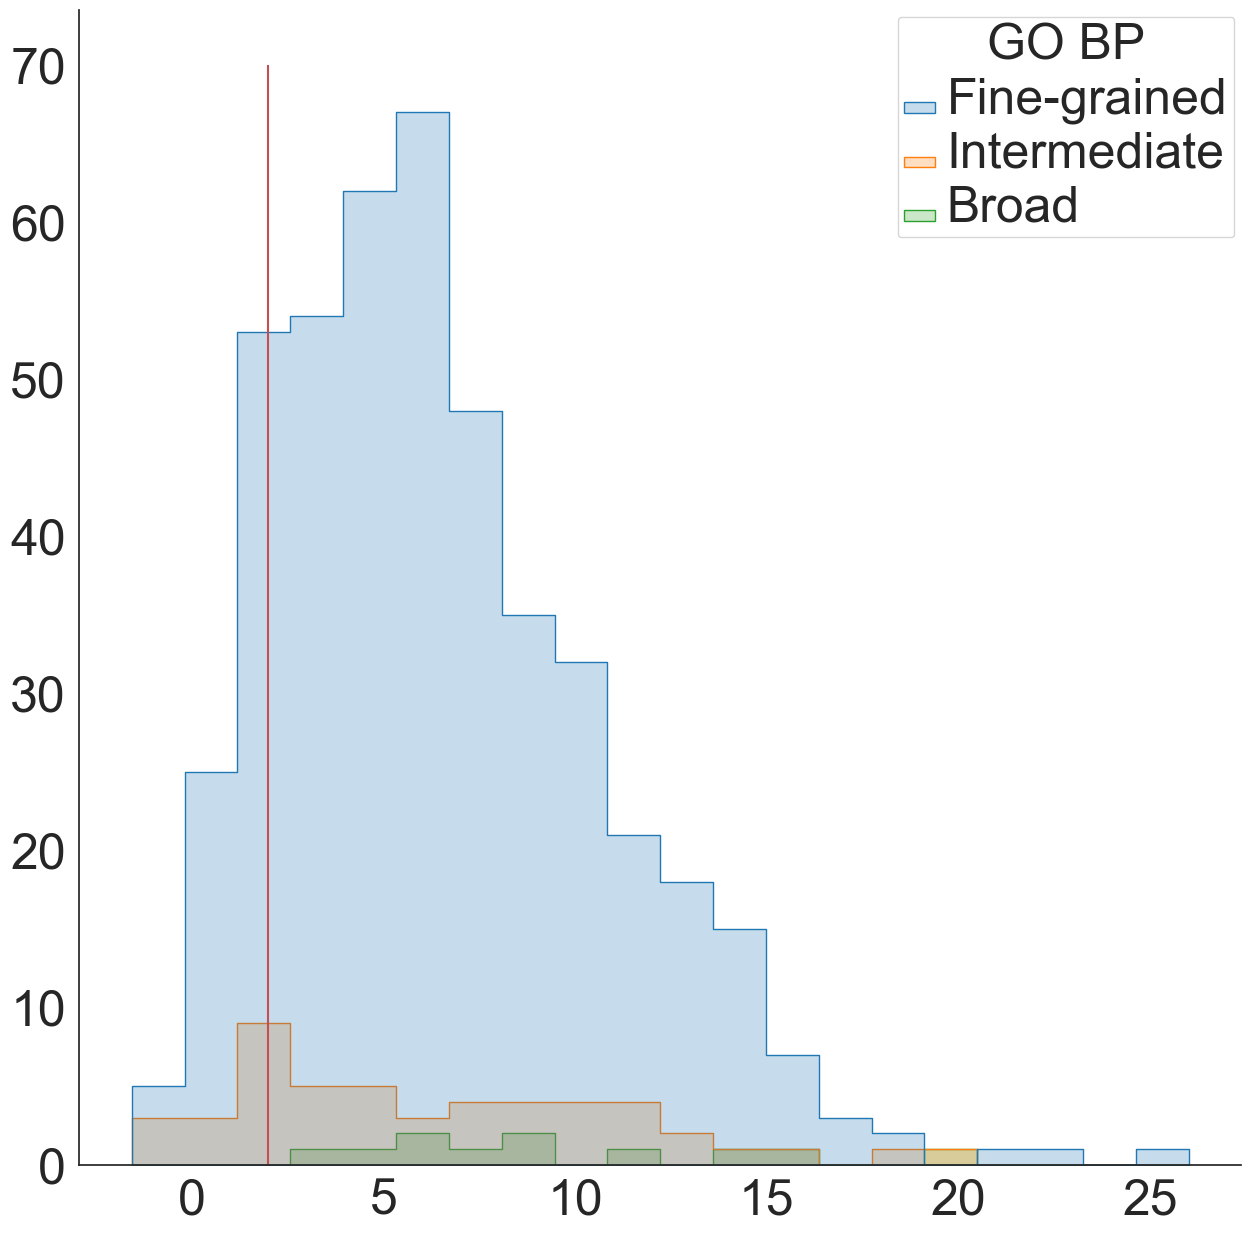

In [352]:

goterms_resnik_zscore_df=pd.DataFrame()

finegrained_BP_resnik_zscore=[]
iteration=[]
for com, zscore_list in rd_fine_grained_communities_gobp_resnik.items():
    if str(zscore_list[1])!="nan" and str(zscore_list[1])!="inf":
        finegrained_BP_resnik_zscore.append(float(zscore_list[1]))
        iteration.append("Fine-grained")

middle_BP_resnik_zscore=[]
for com, zscore_list in rd_middle_communities_gobp_resnik.items():
    if str(zscore_list[1])!="nan" and str(zscore_list[1])!="inf":
        middle_BP_resnik_zscore.append(float(zscore_list[1]))
        iteration.append("Intermediate")

broad_BP_resnik_zscore=[]
for com, zscore_list in rd_broad_communities_gobp_resnik.items():
    if str(zscore_list[1])!="nan" and str(zscore_list[1])!="inf":
        broad_BP_resnik_zscore.append(float(zscore_list[1]))
        iteration.append("Broad")    


goterms_resnik_zscore_df['zscore']=finegrained_BP_resnik_zscore+middle_BP_resnik_zscore+broad_BP_resnik_zscore
goterms_resnik_zscore_df['GO BP']=iteration
fig, ax = plt.subplots(figsize=(15,15))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

#plt.yscale('log')
plt.vlines(x=2,ymin=0,ymax=70,color='r',label='random thershold')
#plt.title('Distribution of lcc z-score for enriched terms GO CC of EEN communities across iterations', fontsize=28)
sns.histplot(
    goterms_resnik_zscore_df, x="zscore", hue="GO BP", element="step",palette='tab10',
)
ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)
plt.setp(ax.get_legend().get_texts(), fontsize='36') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='36') # for legend title
plt.xlabel('',fontsize=36)
plt.ylabel('', fontsize=36)
plt.savefig('output/Figures/SF6B_1_v03.pdf',format='pdf',dpi=300, bbox_inches = "tight")


/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_14548/1979277667.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_14548/1979277667.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)


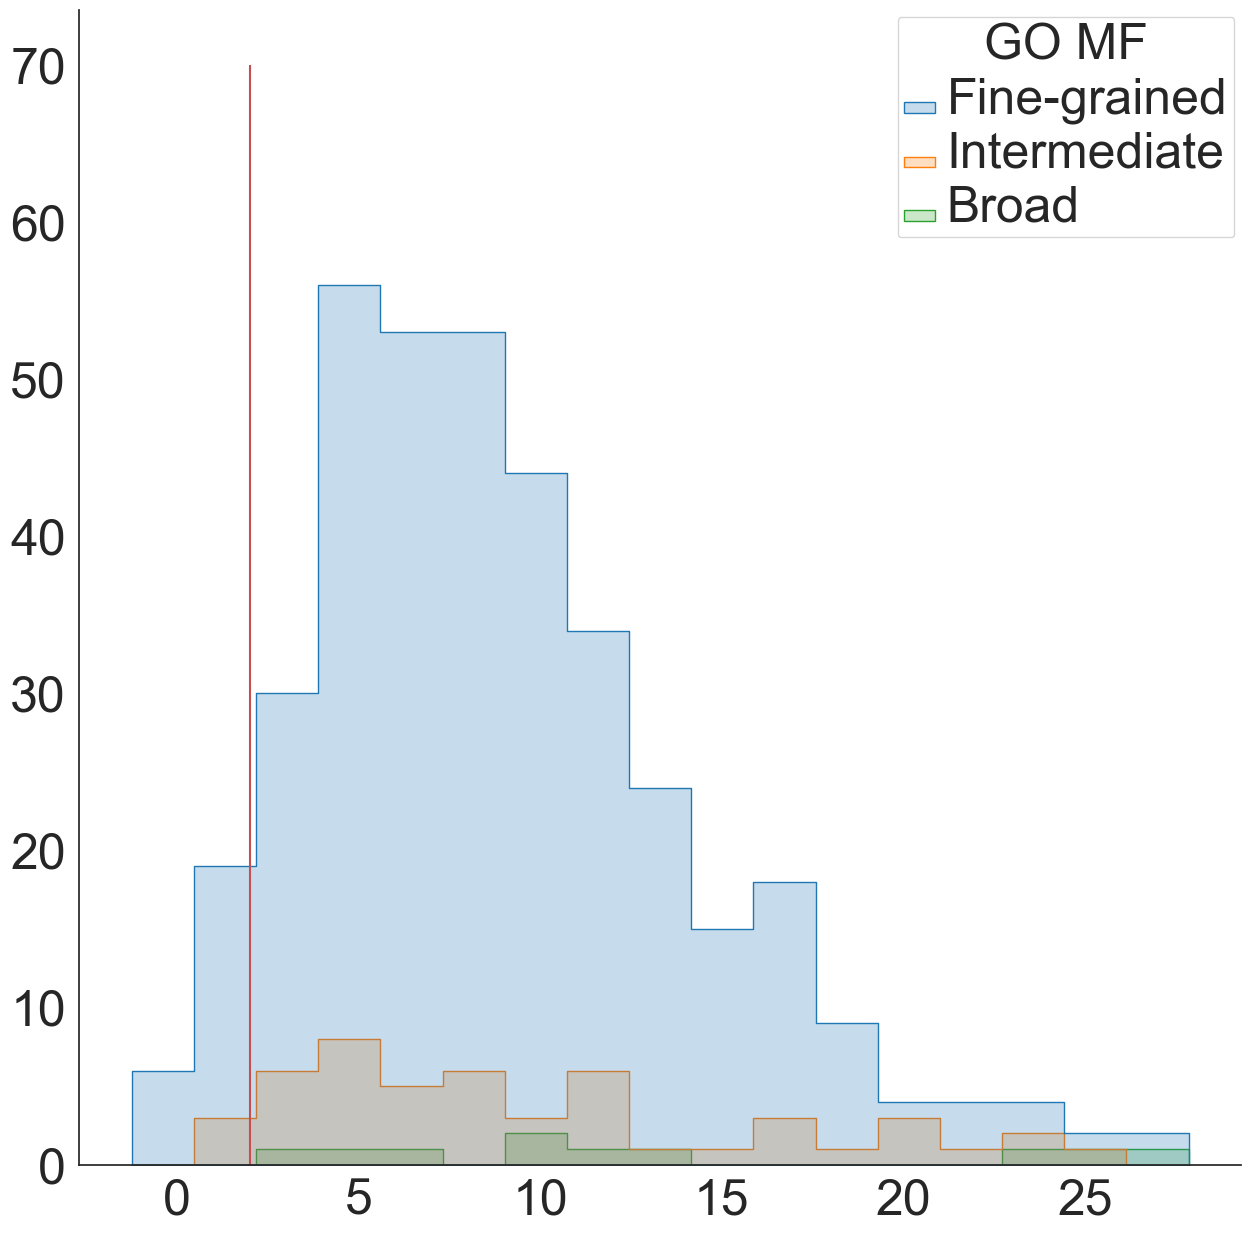

In [296]:

goterms_resnik_zscore_df=pd.DataFrame()

finegrained_MF_resnik_zscore=[]
iteration=[]
for com, zscore_list in rd_fine_grained_communities_gomf_resnik.items():
    if str(zscore_list[1])!="nan" and str(zscore_list[1])!="inf":
        finegrained_MF_resnik_zscore.append(float(zscore_list[1]))
        iteration.append("Fine-grained")

middle_MF_resnik_zscore=[]
for com, zscore_list in rd_middle_communities_gomf_resnik.items():
    if str(zscore_list[1])!="nan" and str(zscore_list[1])!="inf":
        middle_MF_resnik_zscore.append(float(zscore_list[1]))
        iteration.append("Intermediate")

broad_MF_resnik_zscore=[]
for com, zscore_list in rd_broad_communities_gomf_resnik.items():
    if str(zscore_list[1])!="nan" and str(zscore_list[1])!="inf":
        broad_MF_resnik_zscore.append(float(zscore_list[1]))
        iteration.append("Broad")    


goterms_resnik_zscore_df['zscore']=finegrained_MF_resnik_zscore+middle_MF_resnik_zscore+broad_MF_resnik_zscore
goterms_resnik_zscore_df['GO MF']=iteration
fig, ax = plt.subplots(figsize=(15,15))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

#plt.yscale('log')
plt.vlines(x=2,ymin=0,ymax=70,color='r',label='random thershold')
#plt.title('Distribution of lcc z-score for enriched terms GO CC of EEN communities across iterations', fontsize=28)
sns.histplot(
    goterms_resnik_zscore_df, x="zscore", hue="GO MF", element="step",palette='tab10',
)
ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)
plt.setp(ax.get_legend().get_texts(), fontsize='36') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='36') # for legend title
plt.xlabel('',fontsize=36)
plt.ylabel('', fontsize=36)
plt.savefig('output/Figures/SF6B_2_v03.pdf',format='pdf',dpi=300, bbox_inches = "tight")


/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_14548/3073887971.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_14548/3073887971.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)


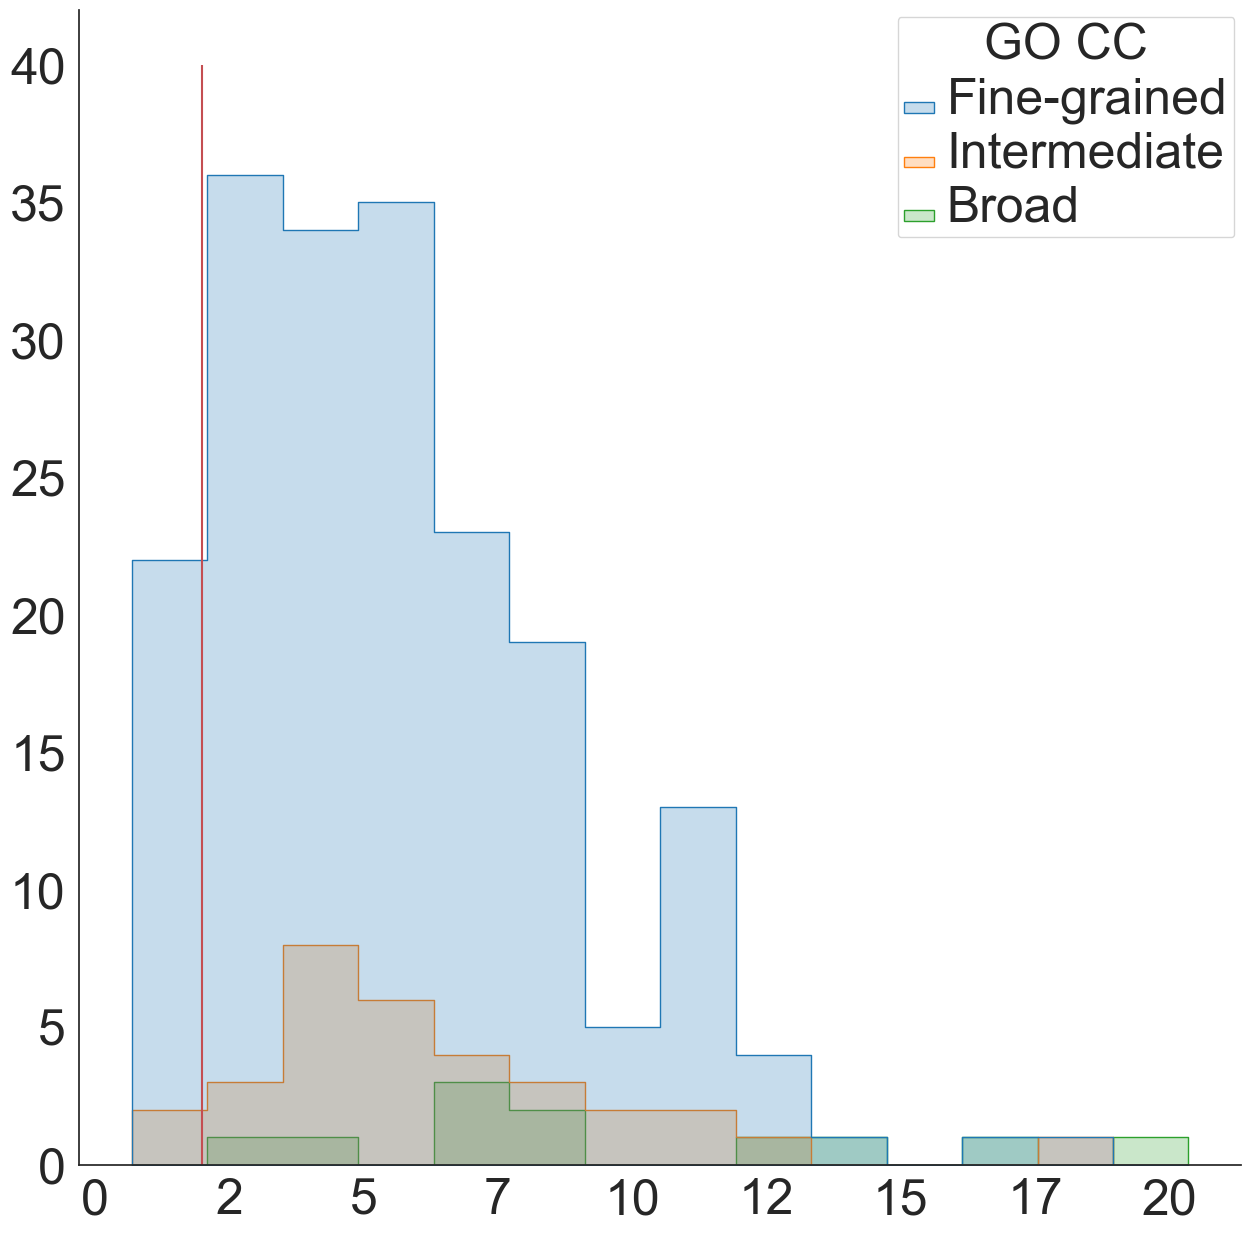

In [297]:

goterms_resnik_zscore_df=pd.DataFrame()

finegrained_CC_resnik_zscore=[]
iteration=[]
for com, zscore_list in rd_fine_grained_communities_gocc_resnik.items():
    if str(zscore_list[1])!="nan" and str(zscore_list[1])!="inf":
        finegrained_CC_resnik_zscore.append(float(zscore_list[1]))
        iteration.append("Fine-grained")

middle_CC_resnik_zscore=[]
for com, zscore_list in rd_middle_communities_gocc_resnik.items():
    if str(zscore_list[1])!="nan" and str(zscore_list[1])!="inf":
        middle_CC_resnik_zscore.append(float(zscore_list[1]))
        iteration.append("Intermediate")

broad_CC_resnik_zscore=[]
for com, zscore_list in rd_broad_communities_gocc_resnik.items():
    if str(zscore_list[1])!="nan" and str(zscore_list[1])!="inf":
        broad_CC_resnik_zscore.append(float(zscore_list[1]))
        iteration.append("Broad")    


goterms_resnik_zscore_df['zscore']=finegrained_CC_resnik_zscore+middle_CC_resnik_zscore+broad_CC_resnik_zscore
goterms_resnik_zscore_df['GO CC']=iteration
fig, ax = plt.subplots(figsize=(15,15))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

#plt.yscale('log')
plt.vlines(x=2,ymin=0,ymax=40,color='r',label='random thershold')
#plt.title('Distribution of lcc z-score for enriched terms GO CC of EEN communities across iterations', fontsize=28)
sns.histplot(
    goterms_resnik_zscore_df, x="zscore", hue="GO CC", element="step",palette='tab10',
)
ax.set_xticklabels([int(i) for i in list(ax.get_xticks())], size = 36)
ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)
plt.setp(ax.get_legend().get_texts(), fontsize='36') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='36') # for legend title
plt.xlabel('',fontsize=36)
plt.ylabel('', fontsize=36)
plt.savefig('output/Figures/SF6B_3_v03.pdf',format='pdf',dpi=300, bbox_inches = "tight")


In [140]:
#Let's calculate the network density for each of the communities of the EEN

def calculate_density_LSD(network, group):
    # Create a subnetwork of the total network
    G_subgraph = network.subgraph(group)
    # Calculate the density of that subnetwork
    density = nx.density(G_subgraph)
    return density



fine_grained_density_com_dict={}
for com,explist in fine_grained_communities_dict.items():
    if len(explist)>2:                    #we exclude communities that have less(equal) than 2 chemicals
        fine_grained_density_com_dict[com]=calculate_density_LSD(backbone_ss_exposure_network,explist)

middle_density_com_dict={}
for com,explist in middle_communities_dict.items():
    if len(explist)>2:                    #we exclude communities that have less(equal) than 2 chemicals      
        middle_density_com_dict[com]=calculate_density_LSD(backbone_ss_exposure_network,explist)

broad_density_com_dict={}
for com,explist in broad_communities_dict.items():
    if len(explist)>2:                    #we exclude communities that have less(equal) than 2 chemicals
        broad_density_com_dict[com]=calculate_density_LSD(backbone_ss_exposure_network,explist)

   
with open('output/Communities/Louvain/fine_grained_density_com_dict.pickle', 'wb') as handle:
    pk.dump(fine_grained_density_com_dict, handle, protocol=pk.HIGHEST_PROTOCOL)
    
with open('output/Communities/Louvain/middle_density_com_dict.pickle', 'wb') as handle:
    pk.dump(middle_density_com_dict, handle, protocol=pk.HIGHEST_PROTOCOL)
    
with open('output/Communities/Louvain/broad_density_com_dict.pickle', 'wb') as handle:
    pk.dump(broad_density_com_dict, handle, protocol=pk.HIGHEST_PROTOCOL)

In [141]:
#Let's import the results
with open('output/Communities/Louvain/fine_grained_density_com_dict.pickle', 'rb') as handle:
    fine_grained_density_com_dict = pk.load(handle) 
    
with open('output/Communities/Louvain/middle_density_com_dict.pickle', 'rb') as handle:
    middle_density_com_dict = pk.load(handle) 
    
with open('output/Communities/Louvain/broad_density_com_dict.pickle', 'rb') as handle:
    broad_density_com_dict = pk.load(handle) 

In [129]:
#Let's create a function that extract unique enriched terms for each community
def extract_unique_terms(hierarchical_community_enrichments):
    from collections import Counter
    lead_genes_all_terms=[]
    hierarchical_community_enrichments_only_unique_terms={}
    for com, gene_enr_list in hierarchical_community_enrichments.items():
        if type(gene_enr_list[1])==list:
            lead_genes_all_terms.extend(gene_enr_list[1])
    count_all_keggterms_enriched_dict=Counter(lead_genes_all_terms)
    for com, gene_enr_list in hierarchical_community_enrichments.items():
        unique_term_list=[]
        if type(gene_enr_list[1])==list:
            for term in gene_enr_list[1]:
                if count_all_keggterms_enriched_dict[term]==1:
                    unique_term_list.append(term)
        hierarchical_community_enrichments_only_unique_terms[com]=unique_term_list
        
    return hierarchical_community_enrichments_only_unique_terms

In [130]:
fine_grained_communities_kegg_unique=extract_unique_terms(fine_grained_communities_kegg)

In [131]:
middle_communities_kegg_uniqe=extract_unique_terms(middle_communities_kegg)

In [132]:
broad_communities_kegg_unique=extract_unique_terms(broad_communities_kegg)

In [163]:
fine_grained_communities_kegg['10_2_2']

[2,
 ['Complement and coagulation cascades',
  'Platelet activation',
  'Phospholipase D signaling pathway',
  'Pathogenic Escherichia coli infection',
  'Regulation of actin cytoskeleton',
  'Coronavirus disease',
  'Neuroactive ligand-receptor interaction']]

In [170]:
fine_grained_communities_kegg['10_2_1']

[2,
 ['Ovarian steroidogenesis',
  'GnRH signaling pathway',
  'cAMP signaling pathway',
  'Neuroactive ligand-receptor interaction',
  'GnRH secretion',
  'Prolactin signaling pathway']]

In [193]:
for exp in fine_grained_communities_dict['10_2_1']:
    print(chem_id_name_conversion[exp])


Contraceptives, Oral, Combined
ABVD protocol
Avosentan
MOPP protocol
kuntai capsule
BEACOPP protocol
EBVP protocol
ganirelix
LHRH, Ala(6)-Gly(10)-ethylamide-
VBA protocol


In [189]:
broad_communities_kegg['10']

[16,
 ['Chemical carcinogenesis',
  'Pathways in cancer',
  'Fluid shear stress and atherosclerosis',
  'Glutathione metabolism',
  'Hepatocellular carcinoma',
  'Metabolism of xenobiotics by cytochrome P450',
  'Drug metabolism',
  'Prolactin signaling pathway',
  'Prostate cancer',
  'Ovarian steroidogenesis',
  'Thyroid hormone synthesis',
  'Complement and coagulation cascades',
  'Neuroactive ligand-receptor interaction',
  'GnRH signaling pathway',
  'Thyroid hormone signaling pathway',
  'FoxO signaling pathway',
  'Estrogen signaling pathway',
  'Breast cancer',
  'Protein processing in endoplasmic reticulum',
  'Proteoglycans in cancer',
  'Lipid and atherosclerosis',
  'cAMP signaling pathway']]

In [164]:
middle_communities_kegg['10_2']

[5,
 ['Neuroactive ligand-receptor interaction',
  'Ovarian steroidogenesis',
  'Complement and coagulation cascades',
  'GnRH signaling pathway',
  'cAMP signaling pathway',
  'GnRH secretion',
  'Prolactin signaling pathway',
  'Parathyroid hormone synthesis, secretion and action',
  'Platelet activation']]

In [165]:
middle_communities_kegg['10_1']

[19,
 ['Chemical carcinogenesis',
  'Glutathione metabolism',
  'Fluid shear stress and atherosclerosis',
  'Metabolism of xenobiotics by cytochrome P450',
  'Hepatocellular carcinoma',
  'Pathways in cancer',
  'Drug metabolism',
  'Prostate cancer',
  'Thyroid hormone signaling pathway',
  'Estrogen signaling pathway',
  'Prolactin signaling pathway',
  'Thyroid hormone synthesis',
  'FoxO signaling pathway',
  'Breast cancer']]

In [140]:
fine_grained_communities_gobp_only_unique_terms=extract_unique_terms(fine_grained_communities_gobp)
middle_communities_gobp_only_unique_terms=extract_unique_terms(middle_communities_gobp)
broad_communities_gobp_only_unique_terms=extract_unique_terms(broad_communities_gobp)








In [145]:
fine_grained_communities_gomf_only_unique_terms=extract_unique_terms(fine_grained_communities_gomf)
middle_communities_gomf_only_unique_terms=extract_unique_terms(middle_communities_gomf)
broad_communities_gomf_only_unique_terms=extract_unique_terms(broad_communities_gomf)





In [146]:
lead_union_levels_uniqe_terms=[]
for com,enr_list in fine_grained_communities_gomf_only_unique_terms.items():
    lead_union_levels_uniqe_terms.extend(enr_list)
for com,enr_list in middle_communities_gomf_only_unique_terms.items():
    lead_union_levels_uniqe_terms.extend(enr_list)
for com,enr_list in broad_communities_gomf_only_unique_terms.items():
    lead_union_levels_uniqe_terms.extend(enr_list)
    
count_lead_union_levels_uniqe_terms=Counter(lead_union_levels_uniqe_terms)

fine_grained_communities_gomf_only_unique_terms_alllevels={}
for com, enr_list in fine_grained_communities_gomf_only_unique_terms.items():
    new_enr_list=[]
    for enr in enr_list:
        if count_lead_union_levels_uniqe_terms[enr]==1:
            new_enr_list.append(enr)
    fine_grained_communities_gomf_only_unique_terms_alllevels[com]=new_enr_list
    
middle_communities_gomf_only_unique_terms_unique_alllevels={}
for com, enr_list in middle_communities_gomf_only_unique_terms.items():
    new_enr_list=[]
    for enr in enr_list:
        if count_lead_union_levels_uniqe_terms[enr]==1:
            new_enr_list.append(enr)
    middle_communities_gomf_only_unique_terms_unique_alllevels[com]=new_enr_list
    
broad_communities_gomf_only_unique_terms_alllevels={}
for com, enr_list in broad_communities_gomf_only_unique_terms.items():
    new_enr_list=[]
    for enr in enr_list:
        if count_lead_union_levels_uniqe_terms[enr]==1:
            new_enr_list.append(enr)
    broad_communities_gomf_only_unique_terms_alllevels[com]=new_enr_list

In [147]:
fine_grained_communities_gocc_only_unique_terms=extract_unique_terms(fine_grained_communities_gocc)
middle_communities_gocc_only_unique_terms=extract_unique_terms(middle_communities_gocc)
broad_communities_gocc_only_unique_terms=extract_unique_terms(broad_communities_gocc)



In [148]:
lead_union_levels_uniqe_terms=[]
for com,enr_list in fine_grained_communities_gocc_only_unique_terms.items():
    lead_union_levels_uniqe_terms.extend(enr_list)
for com,enr_list in middle_communities_gocc_only_unique_terms.items():
    lead_union_levels_uniqe_terms.extend(enr_list)
for com,enr_list in broad_communities_gocc_only_unique_terms.items():
    lead_union_levels_uniqe_terms.extend(enr_list)
    
count_lead_union_levels_uniqe_terms=Counter(lead_union_levels_uniqe_terms)

fine_grained_communities_gocc_only_unique_terms_alllevels={}
for com, enr_list in fine_grained_communities_gocc_only_unique_terms.items():
    new_enr_list=[]
    for enr in enr_list:
        if count_lead_union_levels_uniqe_terms[enr]==1:
            new_enr_list.append(enr)
    fine_grained_communities_gocc_only_unique_terms_alllevels[com]=new_enr_list
    
middle_communities_gocc_only_unique_terms_unique_alllevels={}
for com, enr_list in middle_communities_gocc_only_unique_terms.items():
    new_enr_list=[]
    for enr in enr_list:
        if count_lead_union_levels_uniqe_terms[enr]==1:
            new_enr_list.append(enr)
    middle_communities_gocc_only_unique_terms_unique_alllevels[com]=new_enr_list
    
broad_communities_gocc_only_unique_terms_alllevels={}
for com, enr_list in broad_communities_gocc_only_unique_terms.items():
    new_enr_list=[]
    for enr in enr_list:
        if count_lead_union_levels_uniqe_terms[enr]==1:
            new_enr_list.append(enr)
    broad_communities_gocc_only_unique_terms_alllevels[com]=new_enr_list

Gene Part
===

In [197]:
final_backbone_gene_graph_significant_combo_df = pd.read_csv("output/final_backbone_gene_graph_significant_combo_ji_df.tsv", sep="\t",index_col=0)
backbone_ss_gene_network = nx.from_pandas_edgelist(final_backbone_gene_graph_significant_combo_df, 'Gene A', 'Gene B')


In [198]:
backbone_ss_gene_network.number_of_nodes()

22201

In [200]:
resolution_list = np.linspace(0.1, 2, 20)    # create list of resolution values to check
best_partition, best_resolution, max_modularity = optimal_resolution(backbone_ss_gene_network, resolution_list)
print('Optimal resolution value: ', best_resolution)

Optimal resolution value:  1.0999999999999999


In [201]:
dendo_gg = community_louvain.generate_dendrogram(backbone_ss_gene_network,resolution=1.1,random_state=5495)

In [202]:
len(dendo_gg)

3

In [203]:
len(dendo_gg[0])

22201

In [204]:
len(dendo_gg[1])

284

In [205]:
len(dendo_gg[2])

96

In [206]:
len(set(dendo_gg[2].values()))

92

In [208]:

gg_first_louvain_iteration={}

for com_target in set(list(dendo_gg[1].values())):
    com_list=[]
    for com_source, ncom_target in dendo_gg[1].items():
        if com_target==ncom_target:
            com_list.append(com_source)
    gg_first_louvain_iteration[com_target]=com_list
    
gg_second_louvain_iteration={}

for com_target in set(list(dendo_gg[2].values())):
    com_list=[]
    for com_source, ncom_target in dendo_gg[2].items():
        if com_target==ncom_target:
            com_list.append(com_source)
    gg_second_louvain_iteration[com_target]=com_list


In [211]:
#Let's try to associate some exposures or some chemical class to these communities
gene_chem = {}
for i,v in chem_homo.iterrows():
    try:
        gene_chem[v["GeneSymbol"]] |= {v["ChemicalID"]}
    except KeyError as e:
        gene_chem[v["GeneSymbol"]] = set([v["ChemicalID"]])
        
gene_chem_cleaned={}
for k,v in gene_chem.items():
    if len(v)!=0:
        gene_chem_cleaned[k]=v
    else:
        pass
#Here, we define the fisher test that we will use
def overlap_set_genes(setA, setB,background):    
    """
    Accepts to lists
    M is the population size (previously N)
    n is the number of successes in the population
    N is the sample size (previously n)
    x is still the number of drawn “successes”
    """
    M= len(background) #total number of exposures in chem_gene_cleaned
    n= len(setA)
    N= len(setB)
    x= len(setA.intersection(setB))
    return str(stats.hypergeom.sf(x-1, M, n, N))


from statsmodels.sandbox.stats.multicomp import multipletests
def fdr_adjustment(list_of_pvals,alpha):    
    return multipletests(list_of_pvals,alpha=alpha,method='fdr_bh')[1] #the benjamin hochberg method is used



In [212]:
gg_com_first_louvain_genes={}
gg_com_second_louvain_genes={}
gg_com_third_louvain_genes={}

for com in set(list(dendo_gg[0].values())):
    gene_list=[]
    for gene,comcom in dendo_gg[0].items():
        if com==comcom:
            gene_list.append(gene)
    gg_com_first_louvain_genes[com]=set(gene_list)
    
for com,com_list in gg_first_louvain_iteration.items():
    gene_list=[]
    for comcom in com_list:
        gene_list.extend(gg_com_first_louvain_genes[comcom])
    gg_com_second_louvain_genes[com]=set(gene_list)
    
for com,com_list in gg_second_louvain_iteration.items():
    gene_list=[]
    for comcom in com_list:
        gene_list.extend(list(gg_com_second_louvain_genes[comcom]))
    gg_com_third_louvain_genes[com]=set(gene_list)
    

In [355]:
len(gg_com_third_louvain_genes)

92

In [213]:
#Let's save these communities

with open('output/Communities/Louvain/gg_first_louvain_iteration.pickle', 'wb') as handle:
    pk.dump(gg_first_louvain_iteration, handle, protocol=pk.HIGHEST_PROTOCOL)
    
with open('output/Communities/Louvain/gg_second_louvain_iteration.pickle', 'wb') as handle:
    pk.dump(gg_second_louvain_iteration, handle, protocol=pk.HIGHEST_PROTOCOL)
    
with open('output/Communities/Louvain/gg_com_first_louvain_genes.pickle', 'wb') as handle:
    pk.dump(gg_com_first_louvain_genes, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/Louvain/gg_com_second_louvain_genes.pickle', 'wb') as handle:
    pk.dump(gg_com_second_louvain_genes, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/Louvain/gg_com_third_louvain_genes.pickle', 'wb') as handle:
    pk.dump(gg_com_third_louvain_genes, handle, protocol=pk.HIGHEST_PROTOCOL)

In [24]:
#Let's import these communities

with open('output/Communities/Louvain/gg_first_louvain_iteration.pickle', 'rb') as handle:
    gg_first_louvain_iteration = pk.load(handle)
    
with open('output/Communities/Louvain/gg_second_louvain_iteration.pickle', 'rb') as handle:
    gg_second_louvain_iteration = pk.load(handle)
    
with open('output/Communities/Louvain/gg_com_first_louvain_genes.pickle', 'rb') as handle:
    gg_com_first_louvain_genes = pk.load(handle)
    
with open('output/Communities/Louvain/gg_com_second_louvain_genes.pickle', 'rb') as handle:
    gg_com_second_louvain_genes = pk.load(handle)
    
with open('output/Communities/Louvain/gg_com_third_louvain_genes.pickle', 'rb') as handle:
    gg_com_third_louvain_genes = pk.load(handle)



In [214]:
significant_gg_com_third_louvain_genes={}
for com,gene_set in gg_com_third_louvain_genes.items():
    significant_chem_class=[]
    chem_pval_dict={}
    for exp,geneset in chem_gene_cleaned.items():
        raw_pval=float(overlap_set_genes(gene_set,set(geneset),gene_chem_cleaned))
        chem_pval_dict[exp]=raw_pval

    adj_pval=fdr_adjustment(list(chem_pval_dict.values()),0.05)
    chem_list=list(chem_pval_dict.keys())
    for i in range(len(adj_pval)):
        if adj_pval[i]<0.05:
            significant_chem_class.append([chem_list[i],adj_pval[i]])
        else:
            pass

    significant_gg_com_third_louvain_genes[com]= significant_chem_class
    
significant_gg_com_second_louvain_genes={}
for com,gene_set in gg_com_second_louvain_genes.items():
    significant_chem_class=[]
    chem_pval_dict={}
    for exp,geneset in chem_gene_cleaned.items():
        raw_pval=float(overlap_set_genes(gene_set,set(geneset),gene_chem_cleaned))
        chem_pval_dict[exp]=raw_pval

    adj_pval=fdr_adjustment(list(chem_pval_dict.values()),0.05)
    chem_list=list(chem_pval_dict.keys())
    for i in range(len(adj_pval)):
        if adj_pval[i]<0.05:
            significant_chem_class.append([chem_list[i],adj_pval[i]])
        else:
            pass

    significant_gg_com_second_louvain_genes[com]= significant_chem_class
    
significant_gg_com_first_louvain_genes={}
for com,gene_set in gg_com_first_louvain_genes.items():
    significant_chem_class=[]
    chem_pval_dict={}
    for exp,geneset in chem_gene_cleaned.items():
        raw_pval=float(overlap_set_genes(gene_set,set(geneset),gene_chem_cleaned))
        chem_pval_dict[exp]=raw_pval

    adj_pval=fdr_adjustment(list(chem_pval_dict.values()),0.05)
    chem_list=list(chem_pval_dict.keys())
    for i in range(len(adj_pval)):
        if adj_pval[i]<0.05:
            significant_chem_class.append([chem_list[i],adj_pval[i]])
        else:
            pass

    significant_gg_com_first_louvain_genes[com]= significant_chem_class
    
    

In [215]:
significant_gg_com_first_louvain_genes

{0: [['C029826', 0.004585622946084453]],
 1: [],
 2: [],
 3: [],
 4: [['C029826', 0.004585622946084453]],
 5: [],
 6: [],
 7: [],
 8: [['D003358', 0.00012459207787504555],
  ['D005411', 0.0007255804859493361],
  ['D048789', 0.00034883418749955854],
  ['D010968', 0.00012459207787504555]],
 9: [['C005563', 0.004764861853677839],
  ['D003993', 0.01581319639494881],
  ['C098320', 0.004764861853677839],
  ['D007454', 0.00022665833342019314],
  ['D008713', 0.004764861853677839],
  ['D019829', 0.004764861853677839],
  ['D012974', 9.066333336807728e-05],
  ['D000077484', 0.01296485667163505]],
 10: [['C087114', 0.013675495855841484]],
 11: [],
 12: [['D000395', 5.2018935118942584e-30],
  ['D018501', 9.705497197648004e-72],
  ['D001564', 1.9261321351591612e-10],
  ['D002112', 0.043477107743791495],
  ['D003703', 0.005085830980872406],
  ['D004006', 0.005085830980872406],
  ['C546771', 0.004183073530034125],
  ['C000593030', 0.004183073530034125],
  ['D006886', 0.011040363609416792],
  ['C561695

In [217]:
for k,v in significant_gg_com_first_louvain_genes.items():
    if len(v)==1:
        print(k,v)

0 [['C029826', 0.004585622946084453]]
4 [['C029826', 0.004585622946084453]]
10 [['C087114', 0.013675495855841484]]
19 [['D013196', 0.016296443309332026]]
30 [['C011506', 1.928981969906562e-18]]
46 [['C480342', 3.7933938412215607e-11]]
56 [['C005556', 0.0024894212112198215]]
61 [['D013806', 0.03854338903997234]]
67 [['D004726', 0.04408163418948916]]
79 [['C032642', 0.026207172634303517]]
83 [['C015358', 0.005342540827344122]]
87 [['D014260', 0.047825199648760815]]
93 [['D004026', 0.002751361716069882]]
95 [['D020106', 3.5925233871806457e-12]]
100 [['D011886', 0.00015482736732807934]]
104 [['D002244', 0.0003024237861820451]]
112 [['D002857', 0.008261736816754104]]
127 [['D013759', 9.2213952712341e-09]]
128 [['C496492', 1.9900658740850554e-22]]
142 [['D052638', 3.2576910808997396e-06]]
144 [['D001151', 1.6200193301707855e-26]]
147 [['C511621', 8.821132285596207e-05]]
166 [['C017947', 5.97448103742202e-20]]
170 [['D019344', 3.231125045910635e-14]]
174 [['D008070', 0.010316055413120247]]
17

In [218]:
#Let's run some biological enrichments

thirdgen_gg_communities_louvain_kegg_enrichment={}
secondgen_gg_communities_louvain_kegg_enrichment={}
firstgen_gg_communities_louvain_kegg_enrichment={}
enrichment_libraries = ['KEGG_2021_Human']



import requests
import json
for com,genelist in gg_com_third_louvain_genes.items():
    enriched_terms_specific_net = []
    try:
        ENRICHR_URL = 'http://maayanlab.cloud/Enrichr/addList'
        genes_str = '\n'.join(genelist)
        description = 'Example gene list'
        payload = {
            'list': (None, genes_str),
            'description': (None, description)
        }
        response = requests.post(ENRICHR_URL, files=payload)
        if not response.ok:
            raise Exception('Error analyzing gene list')
        data = json.loads(response.text)
        ENRICHR_URL = 'http://maayanlab.cloud/Enrichr/enrich'
        query_string = '?userListId=%s&backgroundType=%s'
        user_list_id = data['userListId']
        for library in enrichment_libraries:
            gene_set_library = library
            response = requests.get(
                ENRICHR_URL + query_string % (user_list_id, gene_set_library), timeout= None)
            data = json.loads(response.text)
            for k,v in data.items():
                for i in range(len(v)):
                    if (v[i][6])<0.05:
                        enriched_terms_specific_net.append((v[i][1],v[i][6]))
    except:
        pass
    thirdgen_gg_communities_louvain_kegg_enrichment[com]=enriched_terms_specific_net
    
for com,genelist in gg_com_second_louvain_genes.items():
    enriched_terms_specific_net = []
    try:
        ENRICHR_URL = 'http://maayanlab.cloud/Enrichr/addList'
        genes_str = '\n'.join(genelist)
        description = 'Example gene list'
        payload = {
            'list': (None, genes_str),
            'description': (None, description)
        }
        response = requests.post(ENRICHR_URL, files=payload)
        if not response.ok:
            raise Exception('Error analyzing gene list')
        data = json.loads(response.text)
        ENRICHR_URL = 'http://maayanlab.cloud/Enrichr/enrich'
        query_string = '?userListId=%s&backgroundType=%s'
        user_list_id = data['userListId']
        for library in enrichment_libraries:
            gene_set_library = library
            response = requests.get(
                ENRICHR_URL + query_string % (user_list_id, gene_set_library), timeout= None)
            data = json.loads(response.text)
            for k,v in data.items():
                for i in range(len(v)):
                    if (v[i][6])<0.05:
                        enriched_terms_specific_net.append((v[i][1],v[i][6]))
    except:
        pass
    secondgen_gg_communities_louvain_kegg_enrichment[com]=enriched_terms_specific_net
    
for com,genelist in gg_com_first_louvain_genes.items():
    enriched_terms_specific_net = []
    try:
        ENRICHR_URL = 'http://maayanlab.cloud/Enrichr/addList'
        genes_str = '\n'.join(genelist)
        description = 'Example gene list'
        payload = {
            'list': (None, genes_str),
            'description': (None, description)
        }
        response = requests.post(ENRICHR_URL, files=payload)
        if not response.ok:
            raise Exception('Error analyzing gene list')
        data = json.loads(response.text)
        ENRICHR_URL = 'http://maayanlab.cloud/Enrichr/enrich'
        query_string = '?userListId=%s&backgroundType=%s'
        user_list_id = data['userListId']
        for library in enrichment_libraries:
            gene_set_library = library
            response = requests.get(
                ENRICHR_URL + query_string % (user_list_id, gene_set_library), timeout= None)
            data = json.loads(response.text)
            for k,v in data.items():
                for i in range(len(v)):
                    if (v[i][6])<0.05:
                        enriched_terms_specific_net.append((v[i][1],v[i][6]))
    except:
        pass
    firstgen_gg_communities_louvain_kegg_enrichment[com]=enriched_terms_specific_net

In [219]:
#Let's run some biological enrichments

thirdgen_gg_communities_louvain_gobp_enrichment={}
secondgen_gg_communities_louvain_gobp_enrichment={}
firstgen_gg_communities_louvain_gobp_enrichment={}
enrichment_libraries = ['GO_Biological_Process_2021']



import requests
import json
for com,genelist in gg_com_third_louvain_genes.items():
    enriched_terms_specific_net = []
    try:
        ENRICHR_URL = 'http://maayanlab.cloud/Enrichr/addList'
        genes_str = '\n'.join(genelist)
        description = 'Example gene list'
        payload = {
            'list': (None, genes_str),
            'description': (None, description)
        }
        response = requests.post(ENRICHR_URL, files=payload)
        if not response.ok:
            raise Exception('Error analyzing gene list')
        data = json.loads(response.text)
        ENRICHR_URL = 'http://maayanlab.cloud/Enrichr/enrich'
        query_string = '?userListId=%s&backgroundType=%s'
        user_list_id = data['userListId']
        for library in enrichment_libraries:
            gene_set_library = library
            response = requests.get(
                ENRICHR_URL + query_string % (user_list_id, gene_set_library), timeout= None)
            data = json.loads(response.text)
            for k,v in data.items():
                for i in range(len(v)):
                    if (v[i][6])<0.05:
                        enriched_terms_specific_net.append((v[i][1],v[i][6]))
    except:
        pass
    thirdgen_gg_communities_louvain_gobp_enrichment[com]=enriched_terms_specific_net
    
for com,genelist in gg_com_second_louvain_genes.items():
    enriched_terms_specific_net = []
    try:
        ENRICHR_URL = 'http://maayanlab.cloud/Enrichr/addList'
        genes_str = '\n'.join(genelist)
        description = 'Example gene list'
        payload = {
            'list': (None, genes_str),
            'description': (None, description)
        }
        response = requests.post(ENRICHR_URL, files=payload)
        if not response.ok:
            raise Exception('Error analyzing gene list')
        data = json.loads(response.text)
        ENRICHR_URL = 'http://maayanlab.cloud/Enrichr/enrich'
        query_string = '?userListId=%s&backgroundType=%s'
        user_list_id = data['userListId']
        for library in enrichment_libraries:
            gene_set_library = library
            response = requests.get(
                ENRICHR_URL + query_string % (user_list_id, gene_set_library), timeout= None)
            data = json.loads(response.text)
            for k,v in data.items():
                for i in range(len(v)):
                    if (v[i][6])<0.05:
                        enriched_terms_specific_net.append((v[i][1],v[i][6]))
    except:
        pass
    secondgen_gg_communities_louvain_gobp_enrichment[com]=enriched_terms_specific_net
    
for com,genelist in gg_com_first_louvain_genes.items():
    enriched_terms_specific_net = []
    try:
        ENRICHR_URL = 'http://maayanlab.cloud/Enrichr/addList'
        genes_str = '\n'.join(genelist)
        description = 'Example gene list'
        payload = {
            'list': (None, genes_str),
            'description': (None, description)
        }
        response = requests.post(ENRICHR_URL, files=payload)
        if not response.ok:
            raise Exception('Error analyzing gene list')
        data = json.loads(response.text)
        ENRICHR_URL = 'http://maayanlab.cloud/Enrichr/enrich'
        query_string = '?userListId=%s&backgroundType=%s'
        user_list_id = data['userListId']
        for library in enrichment_libraries:
            gene_set_library = library
            response = requests.get(
                ENRICHR_URL + query_string % (user_list_id, gene_set_library), timeout= None)
            data = json.loads(response.text)
            for k,v in data.items():
                for i in range(len(v)):
                    if (v[i][6])<0.05:
                        enriched_terms_specific_net.append((v[i][1],v[i][6]))
    except:
        pass
    firstgen_gg_communities_louvain_gobp_enrichment[com]=enriched_terms_specific_net

In [220]:
#Let's run some biological enrichments

thirdgen_gg_communities_louvain_gomf_enrichment={}
secondgen_gg_communities_louvain_gomf_enrichment={}
firstgen_gg_communities_louvain_gomf_enrichment={}
enrichment_libraries = ['GO_Molecular_Function_2021']



import requests
import json
for com,genelist in gg_com_third_louvain_genes.items():
    enriched_terms_specific_net = []
    try:
        ENRICHR_URL = 'http://maayanlab.cloud/Enrichr/addList'
        genes_str = '\n'.join(genelist)
        description = 'Example gene list'
        payload = {
            'list': (None, genes_str),
            'description': (None, description)
        }
        response = requests.post(ENRICHR_URL, files=payload)
        if not response.ok:
            raise Exception('Error analyzing gene list')
        data = json.loads(response.text)
        ENRICHR_URL = 'http://maayanlab.cloud/Enrichr/enrich'
        query_string = '?userListId=%s&backgroundType=%s'
        user_list_id = data['userListId']
        for library in enrichment_libraries:
            gene_set_library = library
            response = requests.get(
                ENRICHR_URL + query_string % (user_list_id, gene_set_library), timeout= None)
            data = json.loads(response.text)
            for k,v in data.items():
                for i in range(len(v)):
                    if (v[i][6])<0.05:
                        enriched_terms_specific_net.append((v[i][1],v[i][6]))
    except:
        pass
    thirdgen_gg_communities_louvain_gomf_enrichment[com]=enriched_terms_specific_net
    
for com,genelist in gg_com_second_louvain_genes.items():
    enriched_terms_specific_net = []
    try:
        ENRICHR_URL = 'http://maayanlab.cloud/Enrichr/addList'
        genes_str = '\n'.join(genelist)
        description = 'Example gene list'
        payload = {
            'list': (None, genes_str),
            'description': (None, description)
        }
        response = requests.post(ENRICHR_URL, files=payload)
        if not response.ok:
            raise Exception('Error analyzing gene list')
        data = json.loads(response.text)
        ENRICHR_URL = 'http://maayanlab.cloud/Enrichr/enrich'
        query_string = '?userListId=%s&backgroundType=%s'
        user_list_id = data['userListId']
        for library in enrichment_libraries:
            gene_set_library = library
            response = requests.get(
                ENRICHR_URL + query_string % (user_list_id, gene_set_library), timeout= None)
            data = json.loads(response.text)
            for k,v in data.items():
                for i in range(len(v)):
                    if (v[i][6])<0.05:
                        enriched_terms_specific_net.append((v[i][1],v[i][6]))
    except:
        pass
    secondgen_gg_communities_louvain_gomf_enrichment[com]=enriched_terms_specific_net
    
for com,genelist in gg_com_first_louvain_genes.items():
    enriched_terms_specific_net = []
    try:
        ENRICHR_URL = 'http://maayanlab.cloud/Enrichr/addList'
        genes_str = '\n'.join(genelist)
        description = 'Example gene list'
        payload = {
            'list': (None, genes_str),
            'description': (None, description)
        }
        response = requests.post(ENRICHR_URL, files=payload)
        if not response.ok:
            raise Exception('Error analyzing gene list')
        data = json.loads(response.text)
        ENRICHR_URL = 'http://maayanlab.cloud/Enrichr/enrich'
        query_string = '?userListId=%s&backgroundType=%s'
        user_list_id = data['userListId']
        for library in enrichment_libraries:
            gene_set_library = library
            response = requests.get(
                ENRICHR_URL + query_string % (user_list_id, gene_set_library), timeout= None)
            data = json.loads(response.text)
            for k,v in data.items():
                for i in range(len(v)):
                    if (v[i][6])<0.05:
                        enriched_terms_specific_net.append((v[i][1],v[i][6]))
    except:
        pass
    firstgen_gg_communities_louvain_gomf_enrichment[com]=enriched_terms_specific_net

In [221]:
#Let's run some biological enrichments

thirdgen_gg_communities_louvain_gocc_enrichment={}
secondgen_gg_communities_louvain_gocc_enrichment={}
firstgen_gg_communities_louvain_gocc_enrichment={}
enrichment_libraries = ['GO_Cellular_Component_2021']



import requests
import json
for com,genelist in gg_com_third_louvain_genes.items():
    enriched_terms_specific_net = []
    try:
        ENRICHR_URL = 'http://maayanlab.cloud/Enrichr/addList'
        genes_str = '\n'.join(genelist)
        description = 'Example gene list'
        payload = {
            'list': (None, genes_str),
            'description': (None, description)
        }
        response = requests.post(ENRICHR_URL, files=payload)
        if not response.ok:
            raise Exception('Error analyzing gene list')
        data = json.loads(response.text)
        ENRICHR_URL = 'http://maayanlab.cloud/Enrichr/enrich'
        query_string = '?userListId=%s&backgroundType=%s'
        user_list_id = data['userListId']
        for library in enrichment_libraries:
            gene_set_library = library
            response = requests.get(
                ENRICHR_URL + query_string % (user_list_id, gene_set_library), timeout= None)
            data = json.loads(response.text)
            for k,v in data.items():
                for i in range(len(v)):
                    if (v[i][6])<0.05:
                        enriched_terms_specific_net.append((v[i][1],v[i][6]))
    except:
        pass
    thirdgen_gg_communities_louvain_gocc_enrichment[com]=enriched_terms_specific_net
    
for com,genelist in gg_com_second_louvain_genes.items():
    enriched_terms_specific_net = []
    try:
        ENRICHR_URL = 'http://maayanlab.cloud/Enrichr/addList'
        genes_str = '\n'.join(genelist)
        description = 'Example gene list'
        payload = {
            'list': (None, genes_str),
            'description': (None, description)
        }
        response = requests.post(ENRICHR_URL, files=payload)
        if not response.ok:
            raise Exception('Error analyzing gene list')
        data = json.loads(response.text)
        ENRICHR_URL = 'http://maayanlab.cloud/Enrichr/enrich'
        query_string = '?userListId=%s&backgroundType=%s'
        user_list_id = data['userListId']
        for library in enrichment_libraries:
            gene_set_library = library
            response = requests.get(
                ENRICHR_URL + query_string % (user_list_id, gene_set_library), timeout= None)
            data = json.loads(response.text)
            for k,v in data.items():
                for i in range(len(v)):
                    if (v[i][6])<0.05:
                        enriched_terms_specific_net.append((v[i][1],v[i][6]))
    except:
        pass
    secondgen_gg_communities_louvain_gocc_enrichment[com]=enriched_terms_specific_net
    
for com,genelist in gg_com_first_louvain_genes.items():
    enriched_terms_specific_net = []
    try:
        ENRICHR_URL = 'http://maayanlab.cloud/Enrichr/addList'
        genes_str = '\n'.join(genelist)
        description = 'Example gene list'
        payload = {
            'list': (None, genes_str),
            'description': (None, description)
        }
        response = requests.post(ENRICHR_URL, files=payload)
        if not response.ok:
            raise Exception('Error analyzing gene list')
        data = json.loads(response.text)
        ENRICHR_URL = 'http://maayanlab.cloud/Enrichr/enrich'
        query_string = '?userListId=%s&backgroundType=%s'
        user_list_id = data['userListId']
        for library in enrichment_libraries:
            gene_set_library = library
            response = requests.get(
                ENRICHR_URL + query_string % (user_list_id, gene_set_library), timeout= None)
            data = json.loads(response.text)
            for k,v in data.items():
                for i in range(len(v)):
                    if (v[i][6])<0.05:
                        enriched_terms_specific_net.append((v[i][1],v[i][6]))
    except:
        pass
    firstgen_gg_communities_louvain_gocc_enrichment[com]=enriched_terms_specific_net

In [222]:
with open('output/Communities/Louvain/thirdgen_gg_communities_louvain_kegg_enrichment.pickle', 'wb') as handle:
    pk.dump(thirdgen_gg_communities_louvain_kegg_enrichment, handle, protocol=pk.HIGHEST_PROTOCOL)
   
with open('output/Communities/Louvain/secondgen_gg_communities_louvain_kegg_enrichment.pickle', 'wb') as handle:
    pk.dump(secondgen_gg_communities_louvain_kegg_enrichment, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/Louvain/firstgen_gg_communities_louvain_kegg_enrichment.pickle', 'wb') as handle:
    pk.dump(firstgen_gg_communities_louvain_kegg_enrichment, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/Louvain/thirdgen_gg_communities_louvain_gobp_enrichment.pickle', 'wb') as handle:
    pk.dump(thirdgen_gg_communities_louvain_gobp_enrichment, handle, protocol=pk.HIGHEST_PROTOCOL)
   
with open('output/Communities/Louvain/secondgen_gg_communities_louvain_gobp_enrichment.pickle', 'wb') as handle:
    pk.dump(secondgen_gg_communities_louvain_gobp_enrichment, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/Louvain/firstgen_gg_communities_louvain_gobp_enrichment.pickle', 'wb') as handle:
    pk.dump(firstgen_gg_communities_louvain_gobp_enrichment, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/Louvain/thirdgen_gg_communities_louvain_gomf_enrichment.pickle', 'wb') as handle:
    pk.dump(thirdgen_gg_communities_louvain_gomf_enrichment, handle, protocol=pk.HIGHEST_PROTOCOL)
   
with open('output/Communities/Louvain/secondgen_gg_communities_louvain_gomf_enrichment.pickle', 'wb') as handle:
    pk.dump(secondgen_gg_communities_louvain_gomf_enrichment, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/Louvain/firstgen_gg_communities_louvain_gomf_enrichment.pickle', 'wb') as handle:
    pk.dump(firstgen_gg_communities_louvain_gomf_enrichment, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/Louvain/thirdgen_gg_communities_louvain_gocc_enrichment.pickle', 'wb') as handle:
    pk.dump(thirdgen_gg_communities_louvain_gocc_enrichment, handle, protocol=pk.HIGHEST_PROTOCOL)
   
with open('output/Communities/Louvain/secondgen_gg_communities_louvain_gocc_enrichment.pickle', 'wb') as handle:
    pk.dump(secondgen_gg_communities_louvain_gocc_enrichment, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/Louvain/firstgen_gg_communities_louvain_gocc_enrichment.pickle', 'wb') as handle:
    pk.dump(firstgen_gg_communities_louvain_gocc_enrichment, handle, protocol=pk.HIGHEST_PROTOCOL)


In [27]:
with open('output/Communities/Louvain/thirdgen_gg_communities_louvain_kegg_enrichment.pickle', 'rb') as handle:
    thirdgen_gg_communities_louvain_kegg_enrichment = pk.load(handle)
    
with open('output/Communities/Louvain/secondgen_gg_communities_louvain_kegg_enrichment.pickle', 'rb') as handle:
    secondgen_gg_communities_louvain_kegg_enrichment = pk.load(handle)
    
with open('output/Communities/Louvain/firstgen_gg_communities_louvain_kegg_enrichment.pickle', 'rb') as handle:
    firstgen_gg_communities_louvain_kegg_enrichment = pk.load(handle)
    
with open('output/Communities/Louvain/thirdgen_gg_communities_louvain_gobp_enrichment.pickle', 'rb') as handle:
    thirdgen_gg_communities_louvain_gobp_enrichment = pk.load(handle)
    
with open('output/Communities/Louvain/secondgen_gg_communities_louvain_gobp_enrichment.pickle', 'rb') as handle:
    secondgen_gg_communities_louvain_gobp_enrichment = pk.load(handle)
    
with open('output/Communities/Louvain/firstgen_gg_communities_louvain_gobp_enrichment.pickle', 'rb') as handle:
    firstgen_gg_communities_louvain_gobp_enrichment = pk.load(handle)
    
with open('output/Communities/Louvain/thirdgen_gg_communities_louvain_gomf_enrichment.pickle', 'rb') as handle:
    thirdgen_gg_communities_louvain_gomf_enrichment = pk.load(handle)
    
with open('output/Communities/Louvain/secondgen_gg_communities_louvain_gomf_enrichment.pickle', 'rb') as handle:
    secondgen_gg_communities_louvain_gomf_enrichment = pk.load(handle)
with open('output/Communities/Louvain/firstgen_gg_communities_louvain_gomf_enrichment.pickle', 'rb') as handle:
    firstgen_gg_communities_louvain_gomf_enrichment = pk.load(handle)
    
with open('output/Communities/Louvain/thirdgen_gg_communities_louvain_gocc_enrichment.pickle', 'rb') as handle:
    thirdgen_gg_communities_louvain_gocc_enrichment = pk.load(handle)
    
with open('output/Communities/Louvain/secondgen_gg_communities_louvain_gocc_enrichment.pickle', 'rb') as handle:
    secondgen_gg_communities_louvain_gocc_enrichment = pk.load(handle)
    
with open('output/Communities/Louvain/firstgen_gg_communities_louvain_gocc_enrichment.pickle', 'rb') as handle:
    firstgen_gg_communities_louvain_gocc_enrichment = pk.load(handle)


In [164]:
firstgen_gg_communities_louvain_kegg_enrichment[8]

[]

In [165]:
firstgen_gg_communities_louvain_gobp_enrichment[8]

[('cognition (GO:0050890)', 0.0400414596344939)]

In [166]:
firstgen_gg_communities_louvain_gomf_enrichment[8]

[]

In [167]:
firstgen_gg_communities_louvain_gocc_enrichment[8]

[]

In [163]:
secondgen_gg_communities_louvain_kegg_enrichment[22]

[('Olfactory transduction', 1.4824341325850387e-09)]

In [162]:
thirdgen_gg_communities_louvain_kegg_enrichment[24]

[('Olfactory transduction', 2.416222031694961e-09)]

In [168]:
secondgen_gg_communities_louvain_gobp_enrichment[22]

[]

In [357]:
firstgen_gg_communities_louvain_gobp_enrichment[229]

[('organic acid catabolic process (GO:0016054)', 0.03098531113233256),
 ('sulfur amino acid catabolic process (GO:0000098)', 0.03098531113233256),
 ('vesicle transport along actin filament (GO:0030050)', 0.03098531113233256),
 ('aspartate family amino acid metabolic process (GO:0009066)',
  0.03098531113233256),
 ('actin filament-based transport (GO:0099515)', 0.03098531113233256),
 ('sulfur amino acid metabolic process (GO:0000096)', 0.03098531113233256),
 ('vesicle cytoskeletal trafficking (GO:0099518)', 0.03854658250301812),
 ('sulfur compound catabolic process (GO:0044273)', 0.03854658250301812),
 ('alpha-amino acid metabolic process (GO:1901605)', 0.03933251144204977),
 ('organonitrogen compound catabolic process (GO:1901565)',
  0.04823583866847722)]

In [358]:
len(gg_com_first_louvain_genes[229])

13

In [223]:
for k,v in significant_gg_com_first_louvain_genes.items():
    if len(v)==1:
        print(k,v)

0 [['C029826', 0.004585622946084453]]
4 [['C029826', 0.004585622946084453]]
10 [['C087114', 0.013675495855841484]]
19 [['D013196', 0.016296443309332026]]
30 [['C011506', 1.928981969906562e-18]]
46 [['C480342', 3.7933938412215607e-11]]
56 [['C005556', 0.0024894212112198215]]
61 [['D013806', 0.03854338903997234]]
67 [['D004726', 0.04408163418948916]]
79 [['C032642', 0.026207172634303517]]
83 [['C015358', 0.005342540827344122]]
87 [['D014260', 0.047825199648760815]]
93 [['D004026', 0.002751361716069882]]
95 [['D020106', 3.5925233871806457e-12]]
100 [['D011886', 0.00015482736732807934]]
104 [['D002244', 0.0003024237861820451]]
112 [['D002857', 0.008261736816754104]]
127 [['D013759', 9.2213952712341e-09]]
128 [['C496492', 1.9900658740850554e-22]]
142 [['D052638', 3.2576910808997396e-06]]
144 [['D001151', 1.6200193301707855e-26]]
147 [['C511621', 8.821132285596207e-05]]
166 [['C017947', 5.97448103742202e-20]]
170 [['D019344', 3.231125045910635e-14]]
174 [['D008070', 0.010316055413120247]]
17

In [228]:
firstgen_gg_communities_louvain_kegg_enrichment

{0: [],
 1: [('Parkinson disease', 0.04693687327660772),
  ('Pathways of neurodegeneration', 0.04693687327660772)],
 2: [('Cholesterol metabolism', 0.007386408760540924),
  ('PPAR signaling pathway', 0.007386408760540924)],
 3: [],
 4: [],
 5: [],
 6: [],
 7: [],
 8: [],
 9: [('Thyroid hormone synthesis', 4.16245980050899e-05),
  ('Tyrosine metabolism', 0.005293039910401261),
  ('Autoimmune thyroid disease', 0.005293039910401261)],
 10: [],
 11: [('GnRH signaling pathway', 0.03267871471500515),
  ('mRNA surveillance pathway', 0.03267871471500515),
  ('Chagas disease', 0.03267871471500515),
  ('Sphingolipid signaling pathway', 0.03267871471500515),
  ('AMPK signaling pathway', 0.03267871471500515),
  ('Dopaminergic synapse', 0.03267871471500515),
  ('Adrenergic signaling in cardiomyocytes', 0.03267871471500515),
  ('Hepatitis C', 0.03267871471500515),
  ('Hippo signaling pathway', 0.03267871471500515),
  ('Tight junction', 0.03267871471500515)],
 12: [('Hematopoietic cell lineage', 1.23

In [229]:
secondgen_gg_communities_louvain_kegg_enrichment[56]

[('Olfactory transduction', 1.0126474662560643e-45)]

In [230]:
len(gg_com_second_louvain_genes[56])

1282

In [231]:
significant_gg_com_second_louvain_genes[56]

[['D016604', 0.004610253049168353], ['D001564', 1.6196339797756805e-20]]